# Technical Assessment – Data Science – 009749

# Prepared by: Rhea Mirchandani

## Business Case:
A Supervision Manager has asked you to help in allocating scarce resources and identify which firms their team should focus on. Supervisory resource may be allocated according to the following characteristics: 
- Firm size (i.e. the biggest firms need more attention) 
- Changing business profile (are firms’ data changing substantially year-on-year?) 
- Outliers from the norm (when looking at a single reporting period, does a firm deviate significantly from the average?) 

The aim is to achieve an optimal allocation of supervisory resources by steering supervisors in the direction of important or ‘risky’/’outlying’ firms, so as to facilitate the best use of their time and reduce manual effort as much as possible.

## Detailed Code:

## Data Formatting:
- The two datasets are read in as separate data frames (one for the general dataset (df1) and the other for the underwriting dataset (df2)).
- A third data frame (df3) is created by performing an inner join of df1 and df2 to combine information for the common firms in both the datasets. (Kindly note: The assumption here is that ‘Firm 1’ in df1 is the same as ‘Firm 1’ in df2 and so on).
- A fourth dataset (df4) is created for Firms that are present in df2 but not in df1.
- The data is converted from wide to long format to enable ease of manipulation and further engineering.
- A column ‘Year’ is created to extract the year from the string. This is then converted to a datetime object from which the year is extracted as an integer.
- The column names are cleaned to remove spaces within them.

## Importing the requisite libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import datetime
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.ensemble import IsolationForest
from scipy import stats
%matplotlib inline

In [2]:
cf.go_offline()

## Read in the Excel files and format them

The two datasets (one general and the other for underwriting) are provided in two different sheets in the same excel file. The data is in the wide format such that for each Firm, each variable is repeated 5 times (once for each year from 2016 - 2020). This is then converted to the long format such that each Firm now has 5 rows (one for each year from 2016 - 2020).

In [3]:
# Using MultiIndexing as we have sub columns

df1_wide = pd.read_excel('DataScientist_009749_Dataset.xlsx', sheet_name = 'Dataset 1 - General', header = [0, 1])

In [4]:
df1_wide.head()

NWP (£m)                                                           \
              2016YE        2017YE        2018YE        2019YE        2020YE   
Firm 1 -17754.100486      0.000000      0.000000      0.000000      0.000000   
Firm 2      9.244369      0.098771     40.812426     35.643071     13.626145   
Firm 3      0.000000      0.806130     36.620199     86.630018     54.744180   
Firm 4  19677.453353  41072.816156  20885.506445  14719.672914  49204.465136   
Firm 5    128.812208     10.407371     79.579663     79.423623     61.727295   

            SCR (£m)                                                          \
              2016YE        2017YE        2018YE        2019YE        2020YE   
Firm 1   2021.321862  6.940043e-09      0.000000      0.000000      0.000000   
Firm 2     16.459756  1.500907e+01     14.227214     15.037066      1.591638   
Firm 3    486.887796  4.957863e+02    626.612217     81.242579    362.092922   
Firm 4  15975.652771  1.536789e+04  10797.123319  22788.359468  16090.310420   
Firm 5     32.742279  4.395404e+01     31.622572     30.119285     91.515289   

            ...      Total liabilities (£m)                              \
            ...                      2016YE        2017YE        2018YE   
Firm 1      ...                40171.683156      0.000000      0.000000   
Firm 2      ...                    7.970519     12.796789     11.332857   
Firm 3      ...                   68.000844   1592.310597   1005.328927   
Firm 4      ...                48416.743356  30870.226541  68145.069079   
Firm 5      ...                  267.458967     22.979292     69.343245   

                                    \
              2019YE        2020YE   
Firm 1      0.000000      0.000000   
Firm 2      6.730190     16.173862   
Firm 3    593.689101    374.712155   
Firm 4  92600.140108  92273.053968   
Firm 5     16.837470    106.179543   

       Excess of assets over liabilities (£m) [= equity]               \
                                                  2016YE       2017YE   
Firm 1                                       1243.924991     4.398725   
Firm 2                                          8.755261    48.425189   
Firm 3                                        210.918808   100.776891   
Firm 4                                      24862.167211  7191.961836   
Firm 5                                        262.683530     7.592281   

                                                  
              2018YE        2019YE        2020YE  
Firm 1      0.000000      0.000000      0.000000  
Firm 2      0.070823     43.368380     12.456319  
Firm 3     87.586067    922.487659    412.466207  
Firm 4  12910.346383  12586.973993  24127.839035  
Firm 5     96.945192    104.609768    103.180972  

[5 rows x 40 columns]

In [5]:
# Using MultiIndexing as we have sub columns

df2_wide = pd.read_excel('DataScientist_009749_Dataset.xlsx', sheet_name = 'Dataset 2 - Underwriting', header = [0, 1])

In [6]:
df2_wide.head()

Gross claims incurred (£m)                                      \
                           2016YE      2017YE      2018YE      2019YE   
Firm 1                   0.000000    0.005515    0.000000    0.000000   
Firm 2                  44.467865   29.489599   34.100482    0.000000   
Firm 3                   0.000000    0.000000    0.000000    0.000000   
Firm 4                  14.340938   71.062447   87.912471   42.280402   
Firm 5                  48.738606  425.748869  691.379669  174.101260   

                 Gross BEL (inc. TPs as whole, pre-TMTP) (£m)              \
          2020YE                                       2016YE      2017YE   
Firm 1  0.000000                                     0.000000    0.588994   
Firm 2  0.000000                                   221.327680   59.474691   
Firm 3  0.000000                                     0.000000    0.000000   
Firm 4  3.668494                                   -35.112768    7.848685   
Firm 5  5.927624                                     8.386701  253.149414   

                                              ...    Gross expense ratio  \
            2018YE      2019YE      2020YE    ...                 2016YE   
Firm 1    0.000000    0.000000    0.000000    ...               0.000000   
Firm 2  266.118414    0.000000    0.000000    ...               0.391179   
Firm 3    0.000000    0.000000    0.000000    ...               0.000000   
Firm 4  100.876270  167.959536    0.057599    ...               0.231139   
Firm 5  587.461209  226.977435  722.239498    ...               0.236128   

                                                Gross combined ratio  \
           2017YE    2018YE    2019YE    2020YE               2016YE   
Firm 1  77.251254  0.000000  0.000000  0.000000             0.000000   
Firm 2   0.685941  1.433284  0.000000  0.000000             1.750946   
Firm 3   0.000000  0.000000  0.000000  0.000000             0.000000   
Firm 4   0.285471  0.054150  0.051848 -0.162883             1.047234   
Firm 5   0.232725  0.204508  0.131739  0.048703             0.243611   

                                                
          2017YE    2018YE    2019YE    2020YE  
Firm 1  0.675051  0.000000  0.000000  0.000000  
Firm 2  1.321523  1.545325  0.000000  0.000000  
Firm 3  0.000000  0.000000  0.000000  0.000000  
Firm 4  0.476384  3.307379  1.247403 -2.303093  
Firm 5  1.977732  2.495287  0.365455  1.133645  

[5 rows x 45 columns]

In [7]:
# Convert the data from wide to long format (df1)

df1_long = df1_wide.stack(level=1).reset_index().rename(columns={"level_0": "Firm", "level_1":"Year"})

df1_long['Year'] = df1_long['Year'].apply(lambda x:x[:4])
df1_long = df1_long.sort_values(['Firm','Year'])
df1_long.columns = df1_long.columns.str.replace(' ', '')
df1_long['Year'] = pd.to_datetime(df1_long['Year']).dt.year

In [8]:
df1_long.head()

Firm  Year  EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]  \
0  Firm 1  2016    2416.559785                                 1243.924991   
1  Firm 1  2017       3.796177                                    4.398725   
2  Firm 1  2018       0.000000                                    0.000000   
3  Firm 1  2019       0.000000                                    0.000000   
4  Firm 1  2020       0.000000                                    0.000000   

    GWP(£m)       NWP(£m)       SCR(£m)  SCRcoverageratio  Totalassets(£m)  \
0  46.76803 -17754.100486  2.021322e+03      1.625197e-01     63676.869102   
1   0.00000      0.000000  6.940043e-09      5.588700e+07         9.566096   
2   0.00000      0.000000  0.000000e+00      0.000000e+00         0.000000   
3   0.00000      0.000000  0.000000e+00      0.000000e+00         0.000000   
4   0.00000      0.000000  0.000000e+00      0.000000e+00         0.000000   

   Totalliabilities(£m)  
0          40171.683156  
1              0.000000  
2              0.000000  
3              0.000000  
4              0.000000

In [9]:
# Applying the same data formatting to df2
# Convert the data from wide to long format (df2)

df2_long = df2_wide.stack(level=1).reset_index().rename(columns={"level_0": "Firm", "level_1":"Year"})

df2_long['Year'] = df2_long['Year'].apply(lambda x:x[:4])
df2_long = df2_long.sort_values(['Firm','Year'])
df2_long.columns = df2_long.columns.str.replace(' ', '')
df2_long['Year'] = pd.to_datetime(df2_long['Year']).dt.year

In [10]:
df2_long.head()

Firm  Year  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
0  Firm 1  2016                               0.000000   
1  Firm 1  2017                               0.588994   
2  Firm 1  2018                               0.000000   
3  Firm 1  2019                               0.000000   
4  Firm 1  2020                               0.000000   

   Grossclaimsincurred(£m)  Grosscombinedratio  Grossexpenseratio  \
0                 0.000000            0.000000           0.000000   
1                 0.005515            0.675051          77.251254   
2                 0.000000            0.000000           0.000000   
3                 0.000000            0.000000           0.000000   
4                 0.000000            0.000000           0.000000   

   NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  Netexpenseratio  \
0                              0.000000          0.000000          0.00000   
1                              9.894597         71.298841         41.01306   
2                              0.000000          0.000000          0.00000   
3                              0.000000          0.000000          0.00000   
4                              0.000000          0.000000          0.00000   

   Puregrossclaimsratio  Purenetclaimsratio  
0              0.000000            0.000000  
1             17.534691           17.184308  
2              0.000000            0.000000  
3              0.000000            0.000000  
4              0.000000            0.000000

## Explore the datasets


In [11]:
df1_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1625 entries, 0 to 494
Data columns (total 10 columns):
Firm                                          1625 non-null object
Year                                          1625 non-null int64
EoFforSCR(£m)                                 1625 non-null float64
Excessofassetsoverliabilities(£m)[=equity]    1625 non-null float64
GWP(£m)                                       1625 non-null float64
NWP(£m)                                       1625 non-null float64
SCR(£m)                                       1625 non-null float64
SCRcoverageratio                              1625 non-null float64
Totalassets(£m)                               1625 non-null float64
Totalliabilities(£m)                          1625 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 139.6+ KB


In [12]:
df1_long['Firm'].nunique()

325

In [13]:
df1_long.describe()

Year  EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]  \
count  1625.000000    1625.000000                                 1625.000000   
mean   2018.000000     504.096123                                  539.107196   
std       1.414649    2262.296981                                 2174.167392   
min    2016.000000    -162.245016                                 -123.609578   
25%    2017.000000       2.879599                                    3.515754   
50%    2018.000000      25.548589                                   29.582864   
75%    2019.000000     162.428978                                  166.413248   
max    2020.000000   41636.299252                                26705.042053   

            GWP(£m)       NWP(£m)       SCR(£m)  SCRcoverageratio  \
count   1625.000000   1625.000000   1625.000000      1.625000e+03   
mean     936.694961    731.756135    346.635184      1.228704e+06   
std     4757.190907   3969.009525   1570.005997      3.383049e+07   
min      -19.777480 -17754.100486      0.000000     -3.488211e+00   
25%        0.000000      0.000000      0.738866      2.914672e-01   
50%        8.686859      3.625627     11.637984      1.587490e+00   
75%      178.699850     90.225184     91.415724      3.061232e+00   
max    74078.635849  75526.673293  22788.359468      9.993029e+08   

       Totalassets(£m)  Totalliabilities(£m)  
count      1625.000000           1625.000000  
mean       7244.856179           7080.304690  
std       33462.818642          33527.811705  
min        -207.356238          -1487.107764  
25%           6.543713              0.847367  
50%          85.932872             45.545844  
75%         926.199445            643.826070  
max      553549.903858         494498.525611

In [14]:
df1_long.dtypes

Firm                                           object
Year                                            int64
EoFforSCR(£m)                                 float64
Excessofassetsoverliabilities(£m)[=equity]    float64
GWP(£m)                                       float64
NWP(£m)                                       float64
SCR(£m)                                       float64
SCRcoverageratio                              float64
Totalassets(£m)                               float64
Totalliabilities(£m)                          float64
dtype: object

In [15]:
df2_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2280 entries, 0 to 494
Data columns (total 11 columns):
Firm                                     2280 non-null object
Year                                     2280 non-null int64
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)    2280 non-null float64
Grossclaimsincurred(£m)                  2280 non-null float64
Grosscombinedratio                       2280 non-null float64
Grossexpenseratio                        2280 non-null float64
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)     2280 non-null float64
Netcombinedratio                         2280 non-null float64
Netexpenseratio                          2280 non-null float64
Puregrossclaimsratio                     2280 non-null float64
Purenetclaimsratio                       2280 non-null float64
dtypes: float64(9), int64(1), object(1)
memory usage: 213.8+ KB


In [16]:
df2_long['Firm'].nunique()

456

In [17]:
df2_long.describe()

Year  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
count  2280.000000                            2280.000000   
mean   2018.000000                             285.115521   
std       1.414524                            1007.437106   
min    2016.000000                            -167.815824   
25%    2017.000000                               0.000000   
50%    2018.000000                               4.514229   
75%    2019.000000                             146.634626   
max    2020.000000                           19292.066525   

       Grossclaimsincurred(£m)  Grosscombinedratio  Grossexpenseratio  \
count              2280.000000        2.280000e+03        2280.000000   
mean                128.384523        1.744681e+03         247.213953   
std                 431.408877        8.331728e+04       12050.858858   
min                -189.936333       -1.406448e+04      -16112.406623   
25%                   0.000000        0.000000e+00           0.000000   
50%                   0.687716        9.849834e-02           0.039206   
75%                  65.630329        9.810006e-01           0.347480   
max                6844.014131        3.978266e+06      575064.786983   

       NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  \
count                           2280.000000      2.280000e+03   
mean                             181.363743     -2.403903e+03   
std                              637.592586      1.145433e+05   
min                             -182.381851     -5.468706e+06   
25%                                0.000000      0.000000e+00   
50%                                1.319210      5.092779e-02   
75%                               80.476426      9.978883e-01   
max                            11351.609021      4.318219e+04   

       Netexpenseratio  Puregrossclaimsratio  Purenetclaimsratio  
count     2.280000e+03           2280.000000         2280.000000  
mean     -7.911175e+02            422.752181          349.188087  
std       1.097487e+05          20635.934856        17372.269636  
min      -4.495420e+06         -24817.785823       -33721.020240  
25%       0.000000e+00              0.000000            0.000000  
50%       2.420209e-02              0.025116            0.000000  
75%       4.022814e-01              0.602362            0.532303  
max       2.691212e+06         985011.303759       828809.371523

In [18]:
df2_long.dtypes

Firm                                      object
Year                                       int64
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)    float64
Grossclaimsincurred(£m)                  float64
Grosscombinedratio                       float64
Grossexpenseratio                        float64
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)     float64
Netcombinedratio                         float64
Netexpenseratio                          float64
Puregrossclaimsratio                     float64
Purenetclaimsratio                       float64
dtype: object

Checking for missing data - we find out that there is no missing data in either of the data frames.

In [19]:
df1_long.isnull().sum()

Firm                                          0
Year                                          0
EoFforSCR(£m)                                 0
Excessofassetsoverliabilities(£m)[=equity]    0
GWP(£m)                                       0
NWP(£m)                                       0
SCR(£m)                                       0
SCRcoverageratio                              0
Totalassets(£m)                               0
Totalliabilities(£m)                          0
dtype: int64

In [20]:
df2_long.isnull().sum()

Firm                                     0
Year                                     0
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)    0
Grossclaimsincurred(£m)                  0
Grosscombinedratio                       0
Grossexpenseratio                        0
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)     0
Netcombinedratio                         0
Netexpenseratio                          0
Puregrossclaimsratio                     0
Purenetclaimsratio                       0
dtype: int64

#### Join the two dataframes

In [21]:
# Assuming that the Firm Numbers indicate the same firms in both datasets - doing an inner join

df3_long = pd.merge(df1_long,df2_long,on=['Firm','Year'],how='inner')

In [22]:
df3_long.shape

(1625, 19)

In [23]:
df3_long['Firm'].nunique()

325

In [24]:
df3_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1625 entries, 0 to 1624
Data columns (total 19 columns):
Firm                                          1625 non-null object
Year                                          1625 non-null int64
EoFforSCR(£m)                                 1625 non-null float64
Excessofassetsoverliabilities(£m)[=equity]    1625 non-null float64
GWP(£m)                                       1625 non-null float64
NWP(£m)                                       1625 non-null float64
SCR(£m)                                       1625 non-null float64
SCRcoverageratio                              1625 non-null float64
Totalassets(£m)                               1625 non-null float64
Totalliabilities(£m)                          1625 non-null float64
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)         1625 non-null float64
Grossclaimsincurred(£m)                       1625 non-null float64
Grosscombinedratio                            1625 non-null float64
Grossexpense

In [25]:
df3_long.describe()

Year  EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]  \
count  1625.000000    1625.000000                                 1625.000000   
mean   2018.000000     504.096123                                  539.107196   
std       1.414649    2262.296981                                 2174.167392   
min    2016.000000    -162.245016                                 -123.609578   
25%    2017.000000       2.879599                                    3.515754   
50%    2018.000000      25.548589                                   29.582864   
75%    2019.000000     162.428978                                  166.413248   
max    2020.000000   41636.299252                                26705.042053   

            GWP(£m)       NWP(£m)       SCR(£m)  SCRcoverageratio  \
count   1625.000000   1625.000000   1625.000000      1.625000e+03   
mean     936.694961    731.756135    346.635184      1.228704e+06   
std     4757.190907   3969.009525   1570.005997      3.383049e+07   
min      -19.777480 -17754.100486      0.000000     -3.488211e+00   
25%        0.000000      0.000000      0.738866      2.914672e-01   
50%        8.686859      3.625627     11.637984      1.587490e+00   
75%      178.699850     90.225184     91.415724      3.061232e+00   
max    74078.635849  75526.673293  22788.359468      9.993029e+08   

       Totalassets(£m)  Totalliabilities(£m)  \
count      1625.000000           1625.000000   
mean       7244.856179           7080.304690   
std       33462.818642          33527.811705   
min        -207.356238          -1487.107764   
25%           6.543713              0.847367   
50%          85.932872             45.545844   
75%         926.199445            643.826070   
max      553549.903858         494498.525611   

       GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  Grossclaimsincurred(£m)  \
count                            1625.000000              1625.000000   
mean                              304.059010               141.658590   
std                              1120.236417               481.249608   
min                              -167.815824               -74.422893   
25%                                 0.000000                 0.000000   
50%                                 4.566094                 1.459435   
75%                               146.538410                69.639397   
max                             19292.066525              6844.014131   

       Grosscombinedratio  Grossexpenseratio  \
count        1.625000e+03        1625.000000   
mean         2.462693e+03         351.735068   
std          9.868916e+04       14272.329426   
min         -2.354862e+03      -16112.406623   
25%          0.000000e+00           0.000000   
50%          1.395327e-01           0.048912   
75%          1.000998e+00           0.355549   
max          3.978266e+06      575064.786983   

       NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  \
count                           1625.000000       1625.000000   
mean                             190.665436        -11.063437   
std                              697.911607       2117.644387   
min                             -182.381851     -73450.271014   
25%                                0.000000          0.000000   
50%                                1.565938          0.091701   
75%                               78.081918          1.015109   
max                            11351.609021      43182.186323   

       Netexpenseratio  Puregrossclaimsratio  Purenetclaimsratio  
count     1.625000e+03           1625.000000         1625.000000  
mean      1.653949e+03            594.768338          490.690520  
std       6.676106e+04          24443.596779        20577.732970  
min      -7.038624e+03         -24817.785823       -33721.020240  
25%       0.000000e+00              0.000000            0.000000  
50%       3.236163e-02              0.060352            0.010179  
75%       4.058003e-01              0.634058            0.563139  
max       2.6912

In [26]:
df3_long.dtypes

Firm                                           object
Year                                            int64
EoFforSCR(£m)                                 float64
Excessofassetsoverliabilities(£m)[=equity]    float64
GWP(£m)                                       float64
NWP(£m)                                       float64
SCR(£m)                                       float64
SCRcoverageratio                              float64
Totalassets(£m)                               float64
Totalliabilities(£m)                          float64
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)         float64
Grossclaimsincurred(£m)                       float64
Grosscombinedratio                            float64
Grossexpenseratio                             float64
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)          float64
Netcombinedratio                              float64
Netexpenseratio                               float64
Puregrossclaimsratio                          float64
Purenetclaimsratio          

In [27]:
df3_long.isnull().sum()

Firm                                          0
Year                                          0
EoFforSCR(£m)                                 0
Excessofassetsoverliabilities(£m)[=equity]    0
GWP(£m)                                       0
NWP(£m)                                       0
SCR(£m)                                       0
SCRcoverageratio                              0
Totalassets(£m)                               0
Totalliabilities(£m)                          0
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)         0
Grossclaimsincurred(£m)                       0
Grosscombinedratio                            0
Grossexpenseratio                             0
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)          0
Netcombinedratio                              0
Netexpenseratio                               0
Puregrossclaimsratio                          0
Purenetclaimsratio                            0
dtype: int64

#### Creating a new dataframe with the firms that are in df2 but not in df1 

In [28]:
df4_long = df2_long[~df2_long.Firm.isin(df1_long['Firm'])]

In [29]:
df4_long.shape

(655, 11)

In [30]:
df4_long['Firm'].nunique()

131

In [31]:
df4_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 1625 to 2279
Data columns (total 11 columns):
Firm                                     655 non-null object
Year                                     655 non-null int64
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)    655 non-null float64
Grossclaimsincurred(£m)                  655 non-null float64
Grosscombinedratio                       655 non-null float64
Grossexpenseratio                        655 non-null float64
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)     655 non-null float64
Netcombinedratio                         655 non-null float64
Netexpenseratio                          655 non-null float64
Puregrossclaimsratio                     655 non-null float64
Purenetclaimsratio                       655 non-null float64
dtypes: float64(9), int64(1), object(1)
memory usage: 61.4+ KB


In [32]:
df4_long.describe()

Year  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
count   655.000000                             655.000000   
mean   2018.000000                             238.118317   
std       1.415294                             646.075898   
min    2016.000000                              -7.044298   
25%    2017.000000                               0.000000   
50%    2018.000000                               4.136772   
75%    2019.000000                             146.379961   
max    2020.000000                            4780.147939   

       Grossclaimsincurred(£m)  Grosscombinedratio  Grossexpenseratio  \
count               655.000000          655.000000         655.000000   
mean                 95.452677          -36.646051         -12.094157   
std                 268.179776          725.620121         379.261560   
min                -189.936333       -14064.481353       -9671.516722   
25%                   0.000000            0.000000           0.000000   
50%                   0.060988            0.000000           0.012246   
75%                  46.743212            0.886692           0.320577   
max                2266.537626         1577.909736         585.143234   

       NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  \
count                            655.000000      6.550000e+02   
mean                             158.287022     -8.340339e+03   
std                              454.270548      2.136804e+05   
min                              -13.905716     -5.468706e+06   
25%                                0.000000      0.000000e+00   
50%                                0.698622      0.000000e+00   
75%                               84.633501      9.434061e-01   
max                             4224.114868      4.115110e+03   

       Netexpenseratio  Puregrossclaimsratio  Purenetclaimsratio  
count     6.550000e+02            655.000000          655.000000  
mean     -6.857121e+03             -4.005460           -1.867568  
std       1.756509e+05             70.843535          108.330340  
min      -4.495420e+06          -1311.344107        -2244.620155  
25%       0.000000e+00              0.000000            0.000000  
50%       0.000000e+00              0.000000            0.000000  
75%       3.874555e-01              0.498395            0.461766  
max       1.607416e+03            553.027812         1203.731652

In [33]:
df4_long.dtypes

Firm                                      object
Year                                       int64
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)    float64
Grossclaimsincurred(£m)                  float64
Grosscombinedratio                       float64
Grossexpenseratio                        float64
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)     float64
Netcombinedratio                         float64
Netexpenseratio                          float64
Puregrossclaimsratio                     float64
Purenetclaimsratio                       float64
dtype: object

In [34]:
df4_long.isnull().sum()

Firm                                     0
Year                                     0
GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)    0
Grossclaimsincurred(£m)                  0
Grosscombinedratio                       0
Grossexpenseratio                        0
NetBEL(inc.TPsasawhole,pre-TMTP)(£m)     0
Netcombinedratio                         0
Netexpenseratio                          0
Puregrossclaimsratio                     0
Purenetclaimsratio                       0
dtype: int64

# Exploratory Data Analysis

The data frames are explored using methods like info(), describe(), dtypes. 
All variables in the data are numeric except the firm number (e.g. ‘Firm 1’) which is later set as the index before running any algorithms on it.
- I have checked for missing values in the data using isnull() and identified that there are no missing values in any of the datasets.
- Before proceeding with data visualisations, I have engineered the following features:
    - Size_of_Buffer: This is the surplus over 100% of the SCR Coverage Ratio
    - Profitable_Binary: If the net combined ratio is less than 100%, this variable will take the value of 1 (indicating a profit), else it will take a value of 0.
    - NWP_abs_change_YoY: This is the year-wise absolute change of NWP for each firm.
    - NWP_perc_change_YoY: This is the year-wise percentage change of NWP for each firm.
    - SCRCovRatio_abs_change_YoY: This is the year-wise absolute change of the SCR Coverage ratio for each firm.
    - SCRCovRatio_perc_change_YoY: This is the year-wise percentage change of the SCR Coverage ratio for each firm.
    - Grossclaimsincur_abs_change_YoY: This is the year-wise absolute change of the gross claims incurred for each firm.
    - Grossclaimsincur_perc_change_YoY: This is the year-wise percentage change of the gross claims incurred for each firm.
    - Netcombratio_abs_change_YoY: This is the year-wise absolute change of the net combined ratio for each firm.
    - Netcombratio_perc_change_YoY: This is the year-wise percentage change of the net combined ratio for each firm.
    
The reasons for creating derived variables for these metrics is to see how firms are changing year-on-year. As we will see ahead, these metrics are correlated with several other features and hence their trends also would be captured through these metrics. 


### Creating Derived Variables

In [35]:
# Creating a copy of df3_long

df3_long_copy = df3_long.copy()

#### Surplus over 100% of the SCR coverage ratio (Assuming it is a ratio and not percentage, hence subtracting 1)

In [36]:
df3_long['Size_of_Buffer'] = df3_long['SCRcoverageratio'] - 1

#### Profitable or not (1 indicates profit)

In [37]:
df3_long['Profitable_Binary'] = df3_long['Netcombinedratio'].apply(lambda x:1 if x<1 else 0)

#### Creating a variable to see whether firms' data are changing substantitally year-on-year

In [38]:
df3_long['NWP_abs_change_YoY'] = df3_long.groupby('Firm')['NWP(£m)'].diff().fillna(0, downcast='int')

In [39]:
df3_long['NWP_perc_change_YoY'] = (df3_long.groupby('Firm')['NWP(£m)'].pct_change().fillna(0, downcast='int'))*100

In [40]:
df3_long['SCRCovRatio_abs_change_YoY'] = df3_long.groupby('Firm')['SCRcoverageratio'].diff().fillna(0, downcast='int')

In [41]:
df3_long['SCRCovRatio_perc_change_YoY'] = (df3_long.groupby('Firm')['SCRcoverageratio'].pct_change().fillna(0, downcast='int'))*100

In [42]:
df3_long['Grossclaimsincur_abs_change_YoY'] = df3_long.groupby('Firm')['Grossclaimsincurred(£m)'].diff().fillna(0, downcast='int')

In [43]:
df3_long['Grossclaimsincur_perc_change_YoY'] = (df3_long.groupby('Firm')['Grossclaimsincurred(£m)'].pct_change().fillna(0, downcast='int'))*100

In [44]:
df3_long['Netcombratio_abs_change_YoY'] = df3_long.groupby('Firm')['Netcombinedratio'].diff().fillna(0, downcast='int')

In [45]:
df3_long['Netcombratio_perc_change_YoY'] = (df3_long.groupby('Firm')['Netcombinedratio'].pct_change().fillna(0, downcast='int'))*100

In [46]:
# Replacing the first value within each firm to be NaN as it doesn't have a preceeding value

df3_long.loc[df3_long.groupby('Firm')['NWP_abs_change_YoY'].head(1).index, 'NWP_abs_change_YoY'] = np.NaN

In [47]:
df3_long.loc[df3_long.groupby('Firm')['NWP_perc_change_YoY'].head(1).index, 'NWP_perc_change_YoY'] = np.NaN
df3_long.loc[df3_long.groupby('Firm')['SCRCovRatio_abs_change_YoY'].head(1).index, 'SCRCovRatio_abs_change_YoY'] = np.NaN
df3_long.loc[df3_long.groupby('Firm')['SCRCovRatio_perc_change_YoY'].head(1).index, 'SCRCovRatio_perc_change_YoY'] = np.NaN
df3_long.loc[df3_long.groupby('Firm')['Grossclaimsincur_abs_change_YoY'].head(1).index, 'Grossclaimsincur_abs_change_YoY'] = np.NaN
df3_long.loc[df3_long.groupby('Firm')['Grossclaimsincur_perc_change_YoY'].head(1).index, 'Grossclaimsincur_perc_change_YoY'] = np.NaN
df3_long.loc[df3_long.groupby('Firm')['Netcombratio_abs_change_YoY'].head(1).index, 'Netcombratio_abs_change_YoY'] = np.NaN
df3_long.loc[df3_long.groupby('Firm')['Netcombratio_perc_change_YoY'].head(1).index, 'Netcombratio_perc_change_YoY'] = np.NaN

In [48]:
# Replacing the inf generated due to division by 0, by NaN values

df3_long.replace([np.inf, -np.inf], np.nan, inplace=True)

In [49]:
df3_long[['Firm','Year','NWP(£m)','Grossclaimsincurred(£m)','NWP_abs_change_YoY', 'Grossclaimsincur_perc_change_YoY']].head(20)

Firm  Year       NWP(£m)  Grossclaimsincurred(£m)  NWP_abs_change_YoY  \
0     Firm 1  2016 -17754.100486                 0.000000                 NaN   
1     Firm 1  2017      0.000000                 0.005515        17754.100486   
2     Firm 1  2018      0.000000                 0.000000            0.000000   
3     Firm 1  2019      0.000000                 0.000000            0.000000   
4     Firm 1  2020      0.000000                 0.000000            0.000000   
5    Firm 10  2016    404.116022                 3.671436                 NaN   
6    Firm 10  2017   3882.087306               100.897254         3477.971284   
7    Firm 10  2018   6640.433866               138.345633         2758.346559   
8    Firm 10  2019   5196.618355               122.984554        -1443.815510   
9    Firm 10  2020    221.986516               189.697324        -4974.631840   
10  Firm 100  2016     22.372518                52.918338                 NaN   
11  Firm 100  2017     16.450420               468.979671           -5.922098   
12  Firm 100  2018      5.194659                71.433660          -11.255761   
13  Firm 100  2019     49.257908                61.108119           44.063249   
14  Firm 100  2020     55.765640               106.679797            6.507733   
15  Firm 101  2016   7932.403100                 0.000000                 NaN   
16  Firm 101  2017   3304.202645                 0.000000        -4628.200455   
17  Firm 101  2018   2397.454118                 0.000000         -906.748526   
18  Firm 101  2019   4804.131318                 0.000000         2406.677200   
19  Firm 101  2020      0.000000                 0.000000        -4804.131318   

    Grossclaimsincur_perc_change_YoY  
0                                NaN  
1                                NaN  
2                        -100.000000  
3                           0.000000  
4                           0.000000  
5                                NaN  
6                        2648.168824  
7                          37.115360  
8                         -11.103407  
9                          54.244836  
10                               NaN  
11                        786.232803  
12                        -84.768282  
13                        -14.454727  
14                         74.575488  
15                               NaN  
16                          0.000000  
17                          0.000000  
18                          0.000000  
19                          0.000000

# Data Visualisations

I have conducted an Exploratory Data Analysis (EDA) through various types of data visualisations. My aim through this section was to get a better understanding of the data and create visualisations that focus on the priorities of supervisory resource allocation. I wanted to come up with certain ‘gating rules’ to weed out or identify the important or obviously ‘risky’ firms from the population. These kinds of rules can be used by supervisors while examining dashboards/reports to identify the obvious ‘target’ firms, before delving deeper into the results provided by more sophisticated machine learning algorithms on the data.

Since we have numeric (continuous) data, we will start with pairplots using the seaborn library. This helps us visualise the pairwise relationships between variables in our dataset. 

In [55]:
#import warnings
#warnings.filterwarnings("ignore")

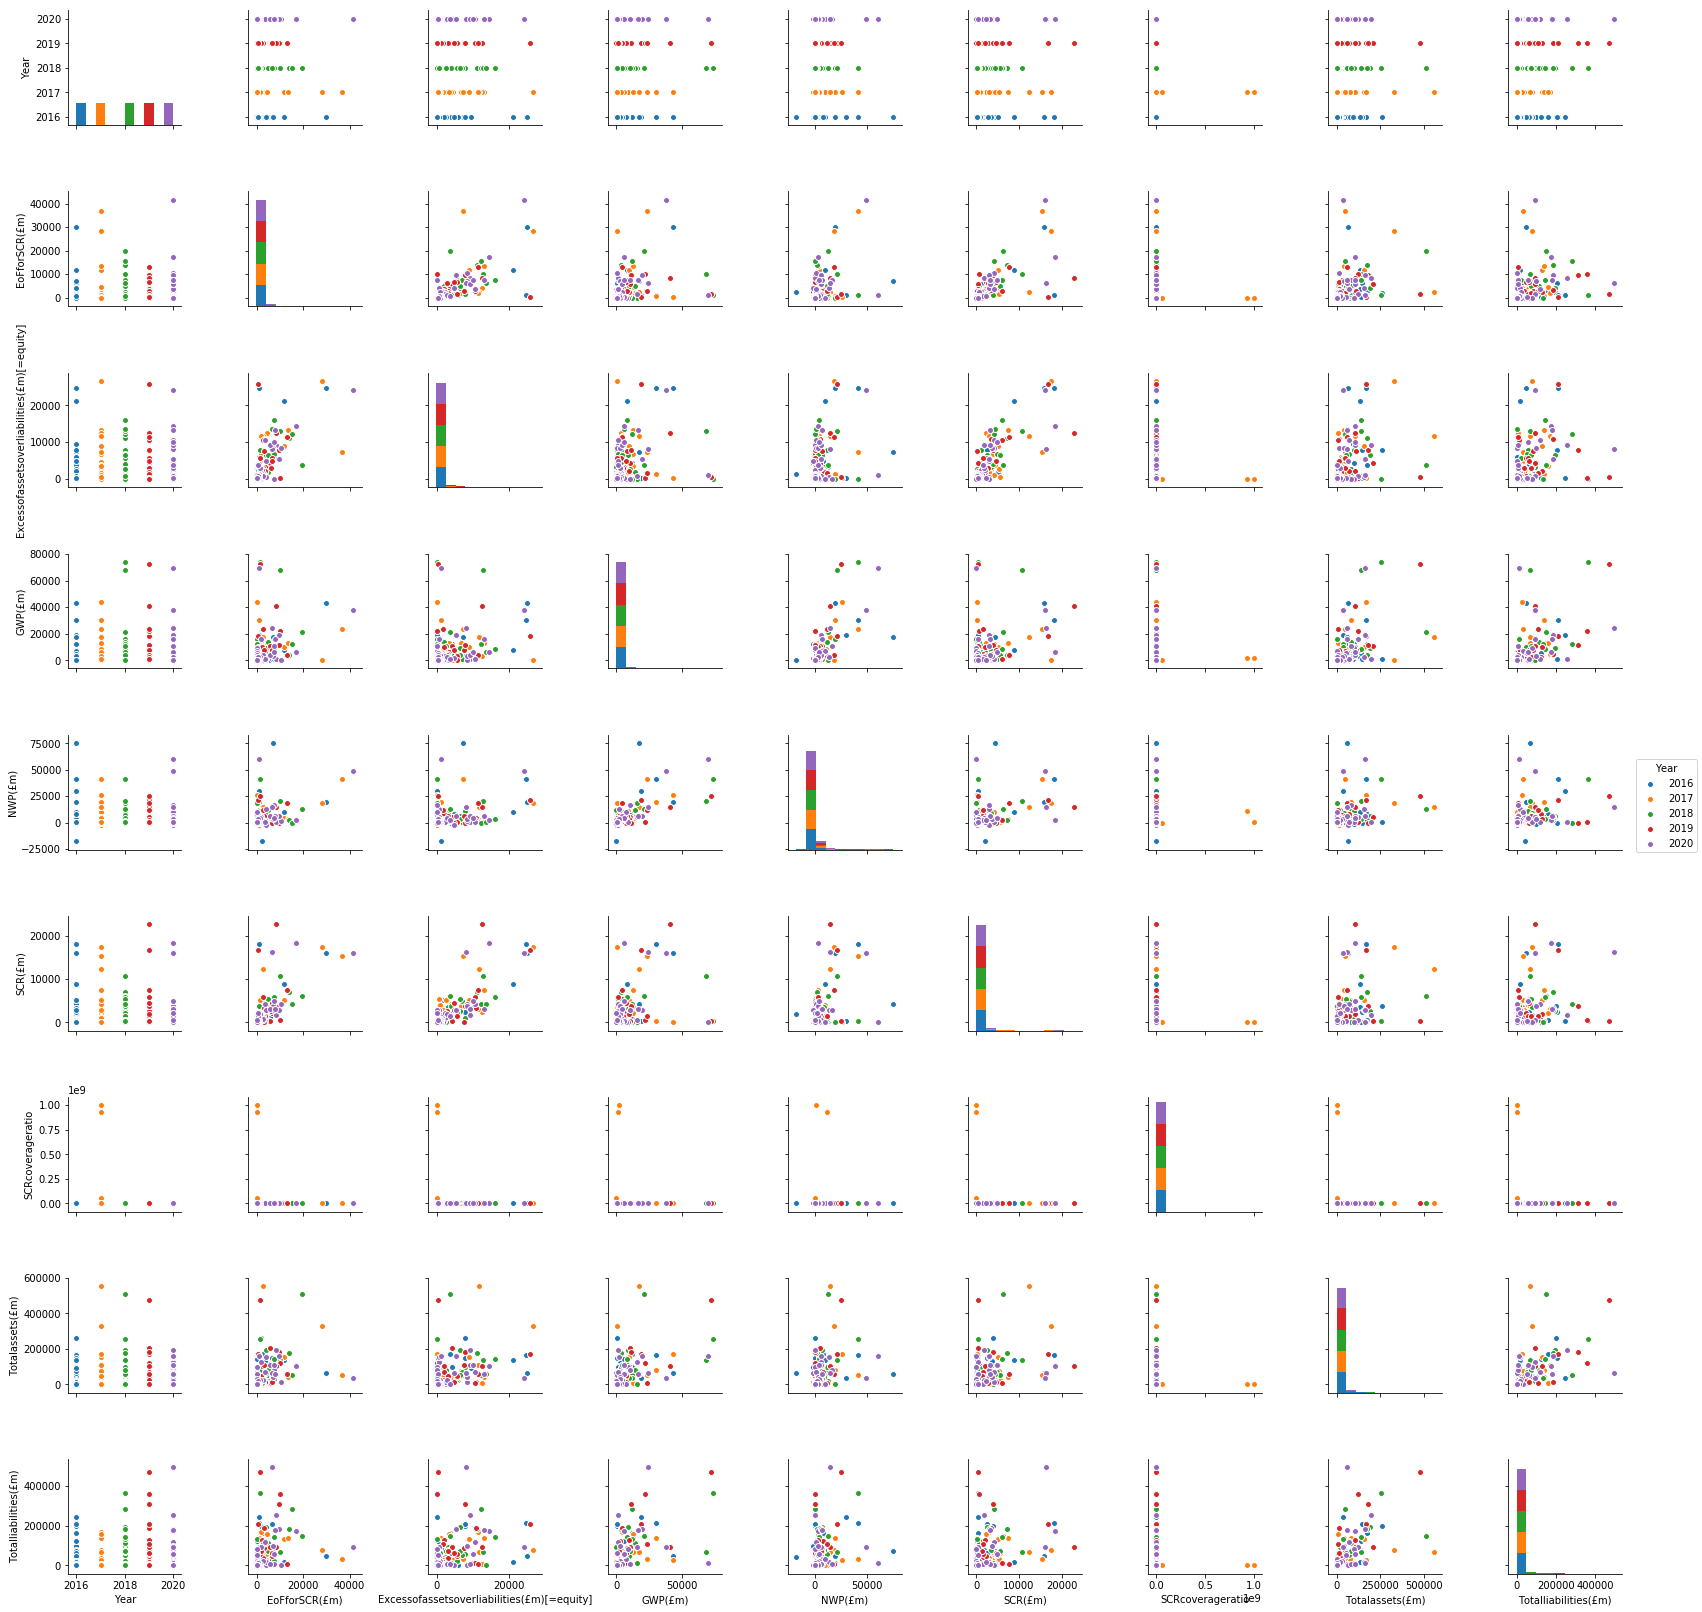

In [51]:
sns.pairplot(df1_long,hue='Year')

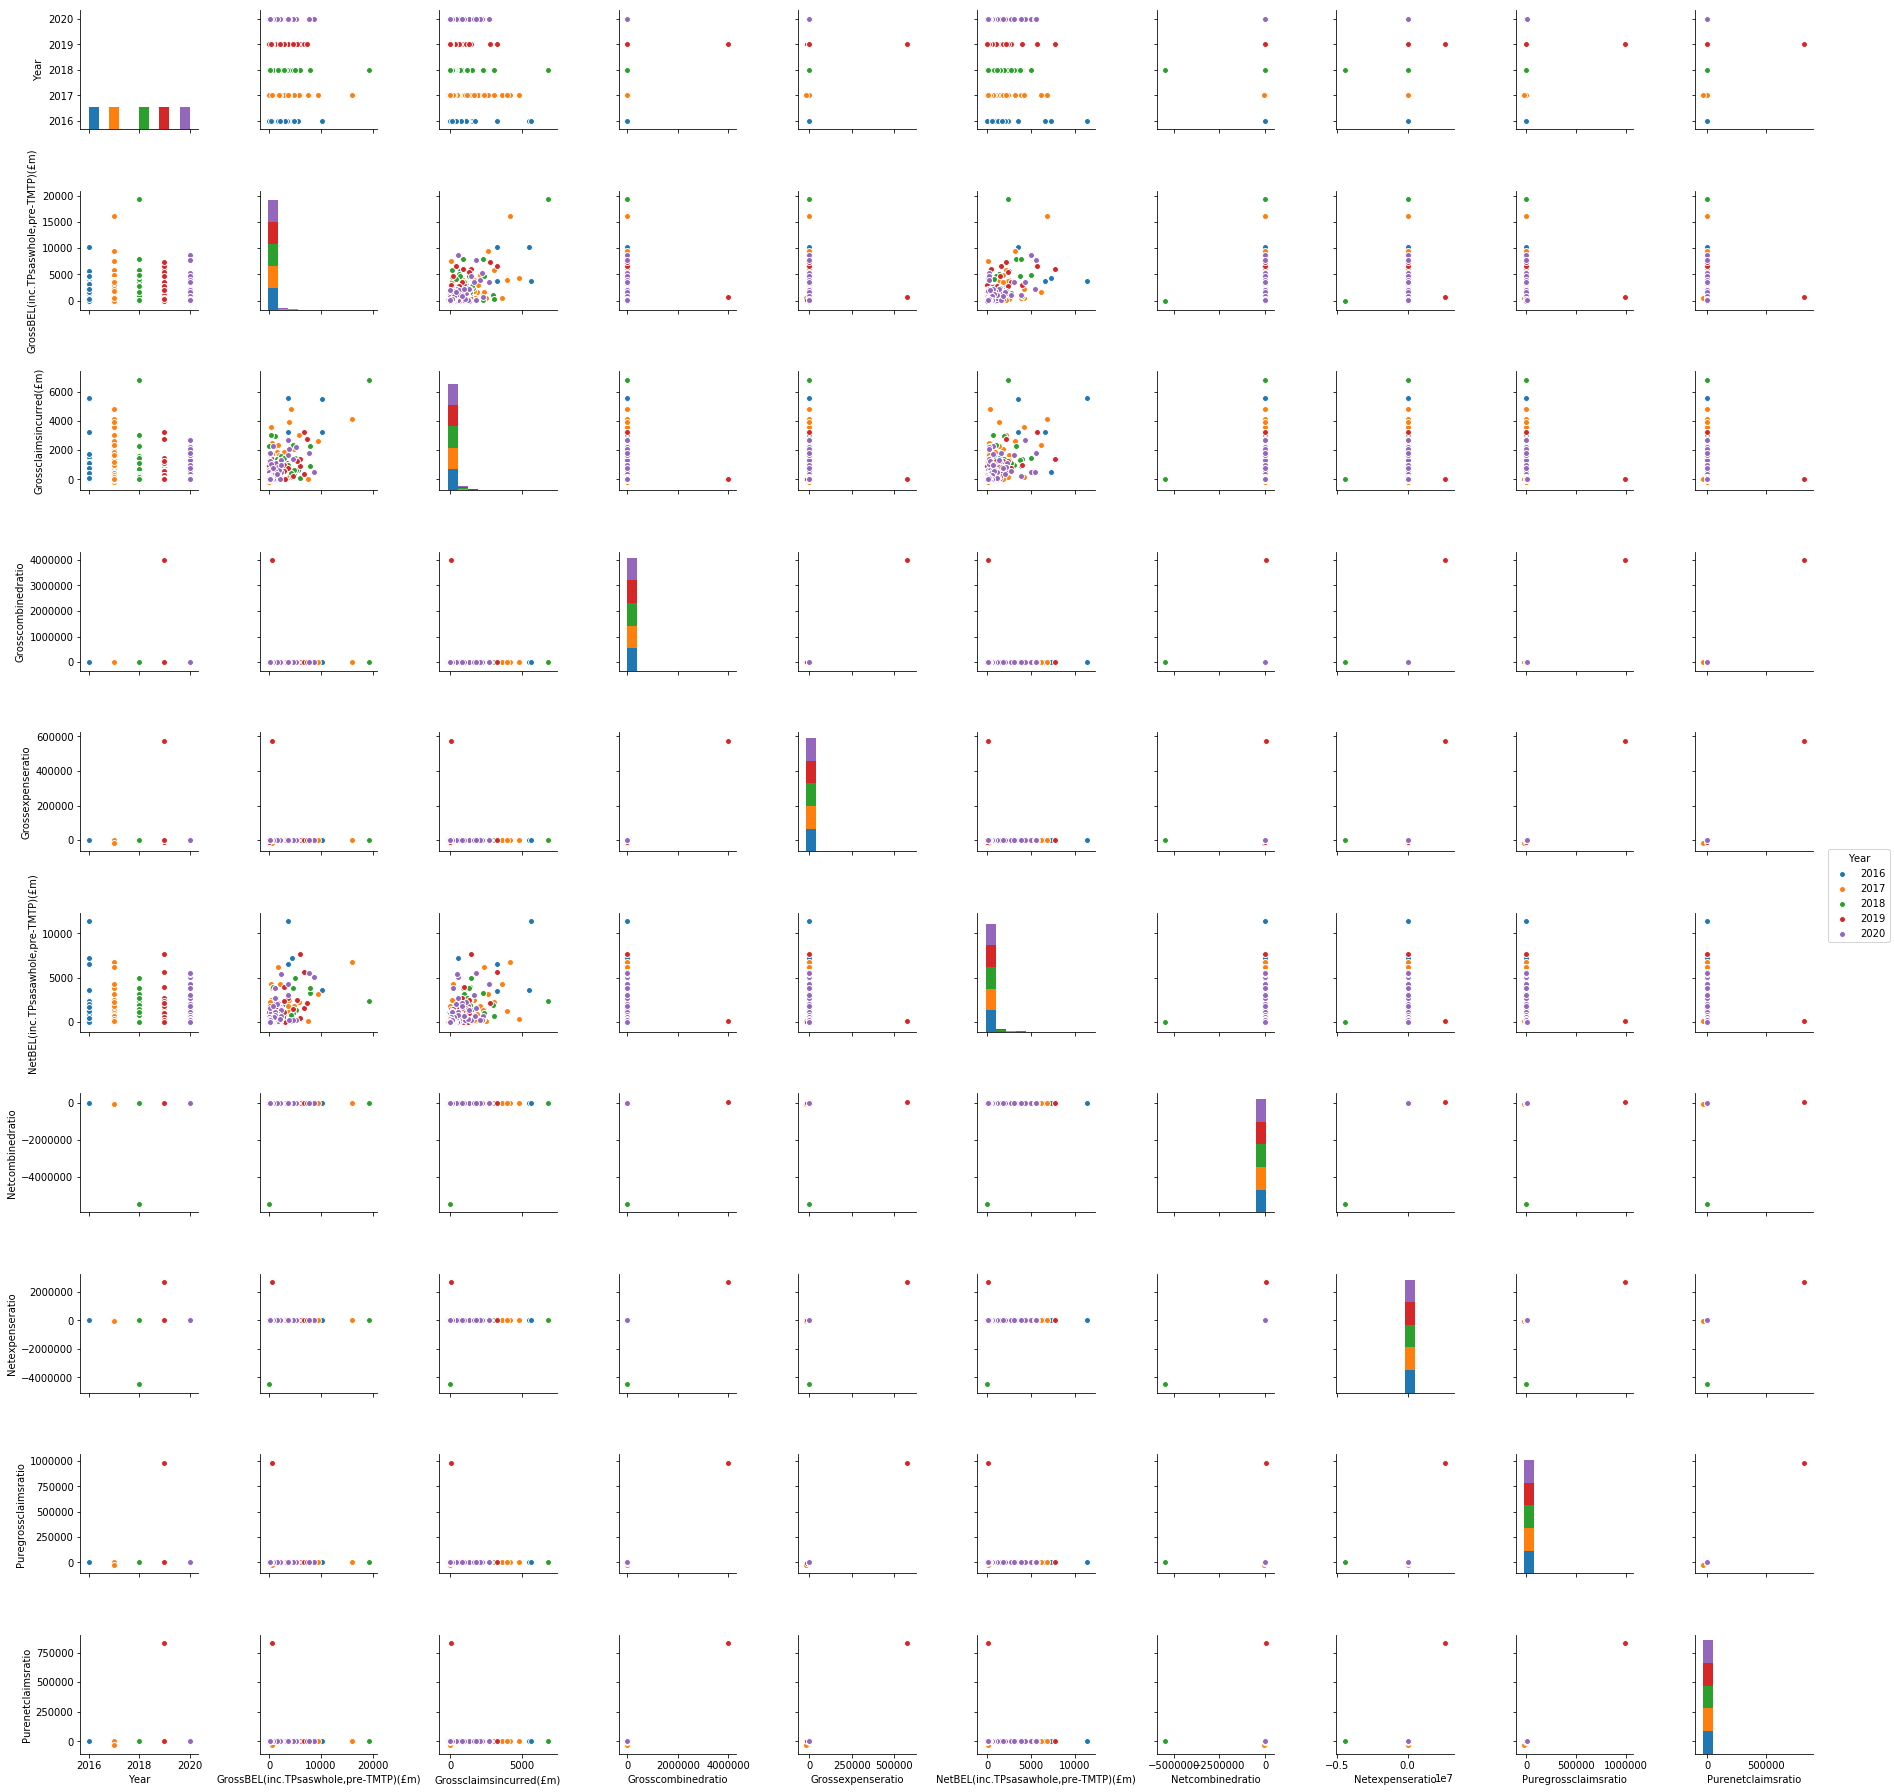

In [52]:
sns.pairplot(df2_long,hue='Year')

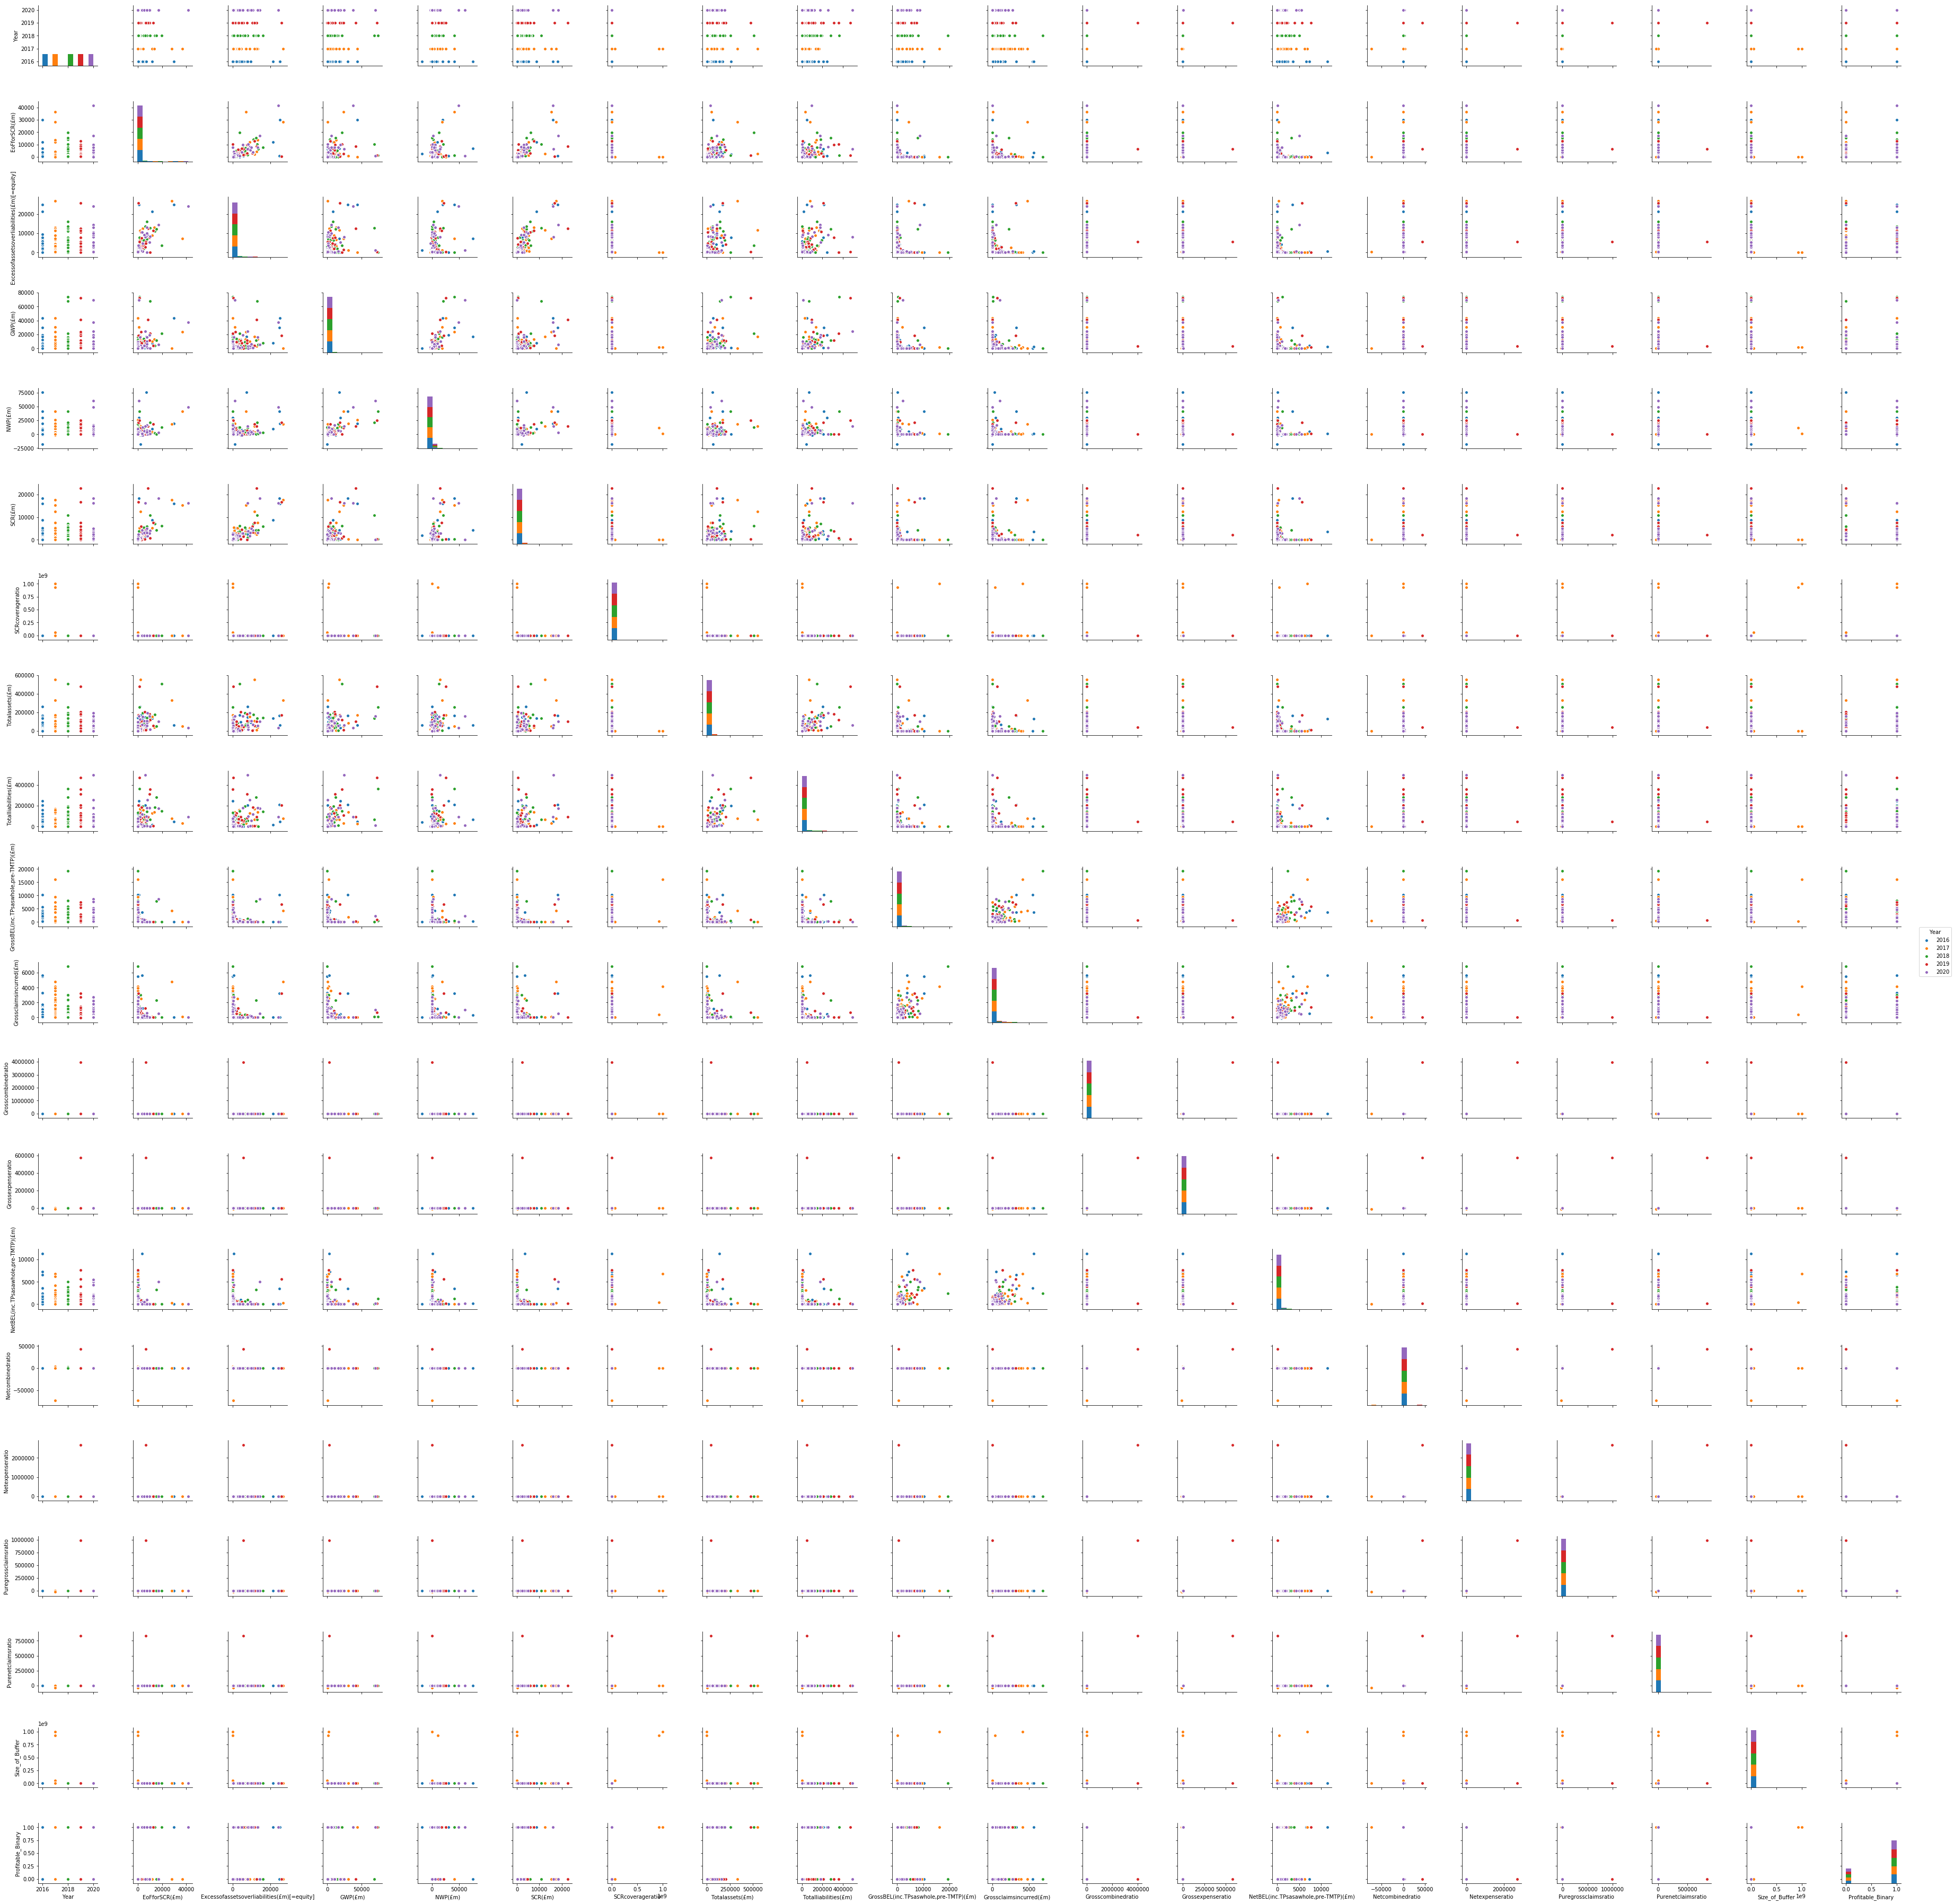

In [53]:
sns.pairplot(df3_long.drop(['NWP_abs_change_YoY',
       'NWP_perc_change_YoY', 'SCRCovRatio_abs_change_YoY',
       'SCRCovRatio_perc_change_YoY', 'Grossclaimsincur_abs_change_YoY',
       'Grossclaimsincur_perc_change_YoY', 'Netcombratio_abs_change_YoY',
       'Netcombratio_perc_change_YoY'],axis=1),hue='Year')

I have created a pairplot for df1 and df2 individually, and then for the joint data frame df3, as there could be a relationship between variables between the two datasets. We see that several variables have correlations with each other. Additionally, it is quite clearly visible that there are several outliers in the data as indicated by anomalous data points on majority of the plots. We can delve deeper by making bivariate scatterplots to examine the relationships between these variables. I have also explored a heatmap with annotations to quantify the relationship between the variables.

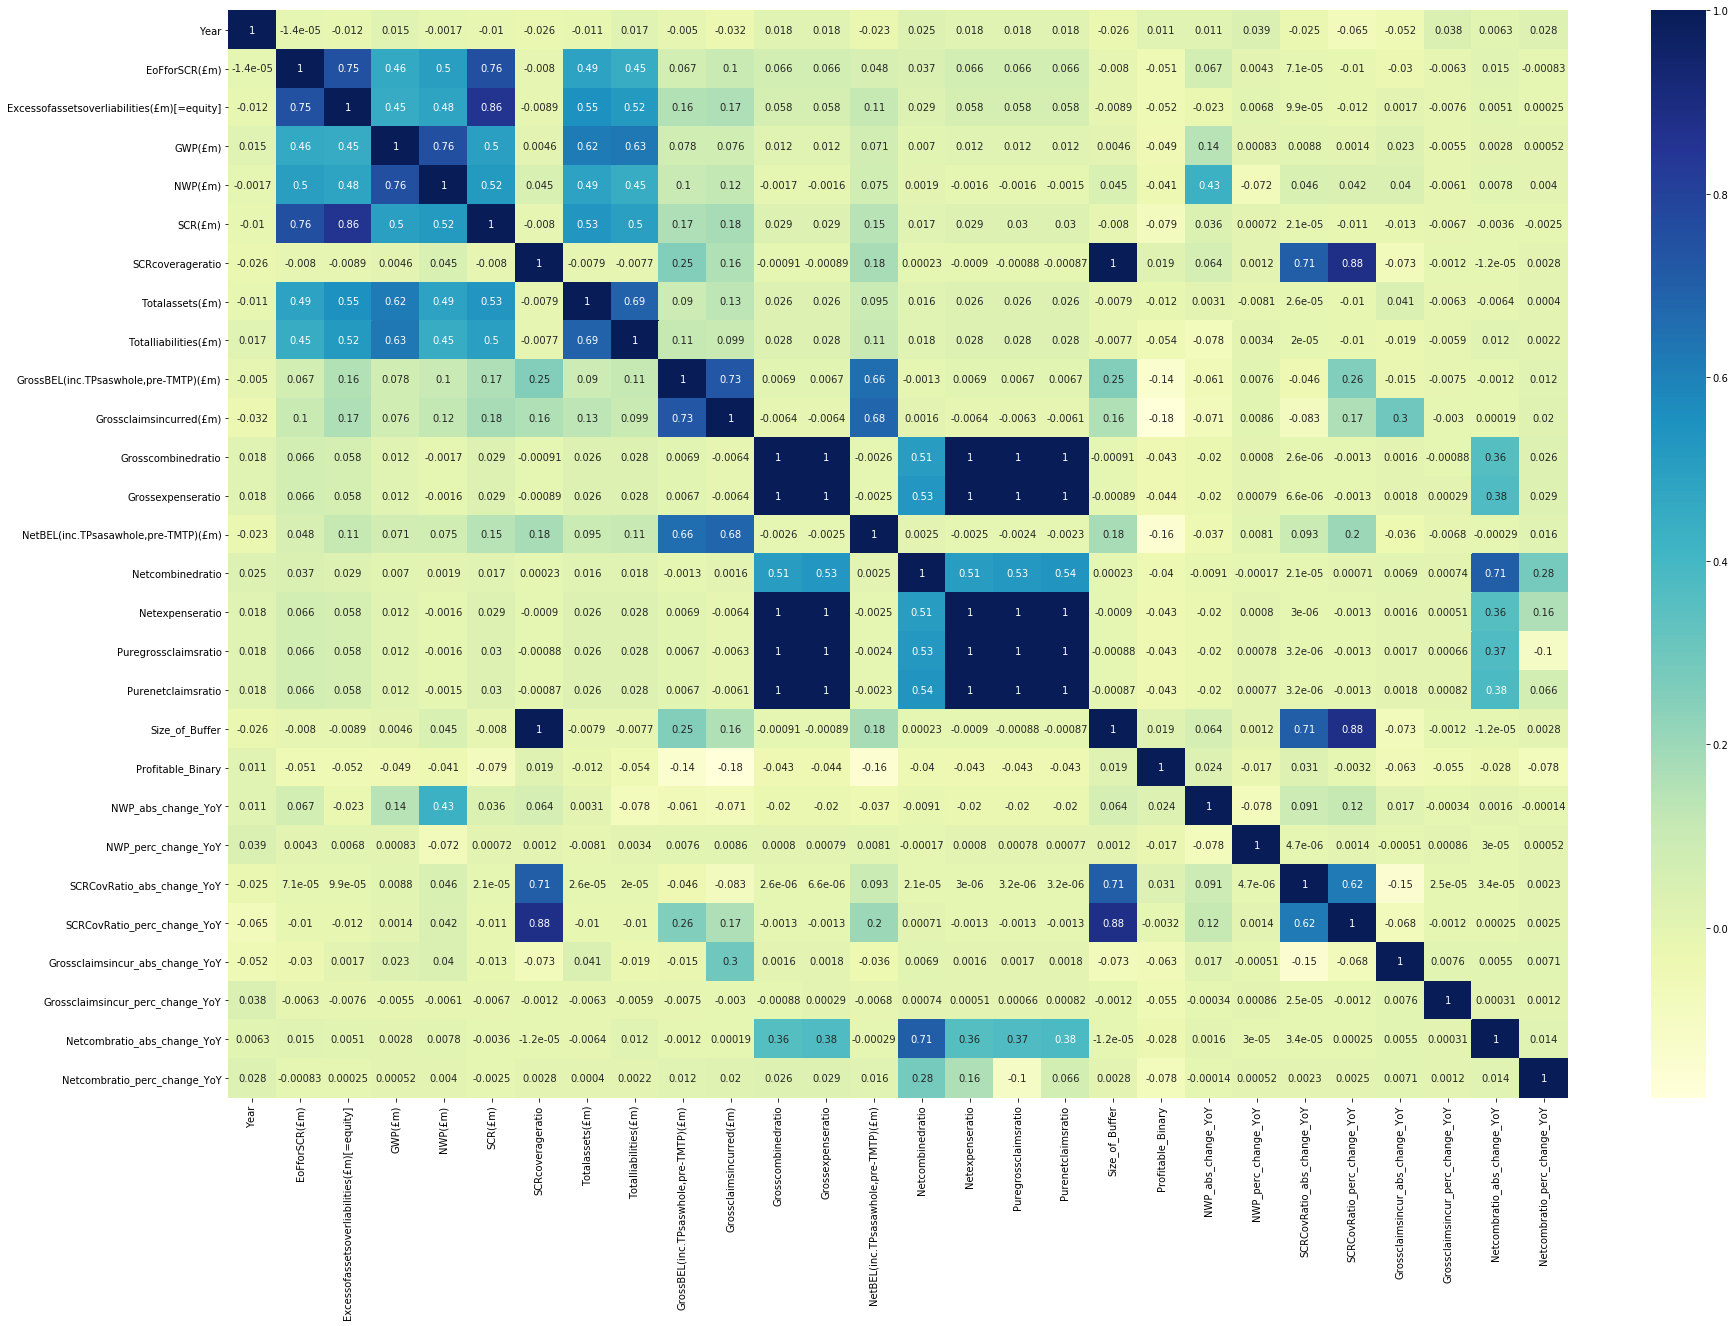

In [49]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df3_long.corr(),annot=True,cmap="YlGnBu")

From this heatmap, it is clearly visible that the following variables are directly correlated:
    - Totalassets(£m) with Totalliabilities(£m)
    - EoFforSCR(£m) with Totalassets(£m), Totalliabilities(£m), SCR(£m), NWP(£m), GWP(£m), Excessofassetsoverliabilities(£m)[=equity]
    - GWP(£m) with NWP(£m)
    - Grossclaimsincurred(£m) with GrossBEL
    - Netexpenseratio, Grosscombinedratio, Grossexpenseratio, Puregrossclaimsratio, Purenetclaimsratio with each other (perfect correlation)
to name a few.

### Keeping in mind our first objective of giving more attention to the biggest firms, the following is a plot of the total assets vs. the total liabilities:

Indicators of a firm's size could be their Gross Written Premium, Net Written Premium, Total Assets, Total Liabilities, to name a few. As we see from the heatmap, these variables are positively correlated as well.

#### Examining Total assets (£m) vs. Total liabilities (£m)

In [50]:
# Using plotly and cufflinks

df3_long.iplot(kind='scatter',x='Totalassets(£m)',y='Totalliabilities(£m)',mode='markers',title='Total assets (£m) vs. Total liabilities (£m)',
          xTitle='Totalassets(£m)',yTitle='Totalliabilities(£m)')


This plot is created using plotly and cufflinks so as to make it interactive. Note that each firm occurs multiple times on this plot (due to multiple rows – one for each year). From this, we can infer that firms with total assets > 100K or total liabilities > 100K should be given more attention to. The following are the unique firms that satisfy this criteria:

In [51]:
firms_size_assets_liab = df3_long[(df3_long['Totalassets(£m)']>100000) | (df3_long['Totalliabilities(£m)']>100000)]['Firm'].unique()

In [52]:
print(firms_size_assets_liab)

['Firm 10' 'Firm 101' 'Firm 105' 'Firm 151' 'Firm 199' 'Firm 210'
 'Firm 216' 'Firm 247' 'Firm 26' 'Firm 298' 'Firm 311' 'Firm 34' 'Firm 4'
 'Firm 6' 'Firm 7' 'Firm 73']


In [53]:
len(firms_size_assets_liab)

16

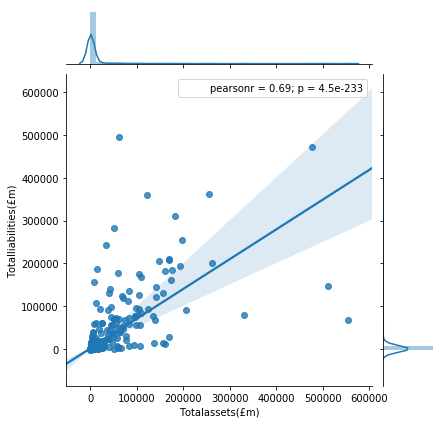

In [56]:
# Adding a regression line to the above plot for data exploration

sns.jointplot(x='Totalassets(£m)',y='Totalliabilities(£m)',data=df3_long, kind='reg',)

#### Examining NWP(£m) vs. GWP(£m)

In [57]:
# Using NWP(£m) and GWP(£m)

df3_long.iplot(kind='scatter',x='GWP(£m)',y='NWP(£m)',mode='markers',color='purple'
                                       ,title='GWP(£m) vs. NWP(£m)',xTitle='Gross Written Premium (£m)',yTitle='Net Written Premium(£m)')

On zooming into this interactive plot, we see that there are big firms that need to be focused on where GWP(£m) > 10K or NWP(£m) > 5K

In [58]:
firms_size_gwp_nwp = df3_long[(df3_long['GWP(£m)']>10000) | (df3_long['NWP(£m)']>5000)]['Firm'].unique()

In [59]:
firms_size_gwp_nwp

array(['Firm 10', 'Firm 101', 'Firm 104', 'Firm 105', 'Firm 120',
       'Firm 131', 'Firm 151', 'Firm 17', 'Firm 199', 'Firm 210',
       'Firm 23', 'Firm 234', 'Firm 247', 'Firm 25', 'Firm 26',
       'Firm 276', 'Firm 30', 'Firm 311', 'Firm 34', 'Firm 38', 'Firm 4',
       'Firm 51', 'Firm 6', 'Firm 7', 'Firm 73'], dtype=object)

In [60]:
len(firms_size_gwp_nwp)

25

In [61]:
print(list(np.intersect1d(firms_size_assets_liab, firms_size_gwp_nwp)) )

['Firm 10', 'Firm 101', 'Firm 105', 'Firm 151', 'Firm 199', 'Firm 210', 'Firm 247', 'Firm 26', 'Firm 311', 'Firm 34', 'Firm 4', 'Firm 6', 'Firm 7', 'Firm 73']


In [62]:
len(list(np.intersect1d(firms_size_assets_liab, firms_size_gwp_nwp)) )

14

#### Top 10 Largest Firms Based on Total Revenue (GWP(£m)) in the Year 2020

In [63]:
df3_long[df3_long['Year']==2020].sort_values('GWP(£m)',ascending=False)[['Firm','Year','GWP(£m)']].head(10)

Firm  Year       GWP(£m)
624   Firm 210  2020  69697.928286
1299    Firm 4  2020  37761.883321
1184  Firm 311  2020  24251.481358
1269   Firm 34  2020  19274.956159
1464    Firm 7  2020  16183.565614
294   Firm 151  2020  15824.692457
894    Firm 26  2020  10352.250388
824   Firm 247  2020   9115.194999
839    Firm 25  2020   7031.517005
1484   Firm 73  2020   6173.505533

#### Top 10 Largest Firms Based on Total Revenue (GWP(£m)) in the Year 2019

In [64]:
df3_long[df3_long['Year']==2019].sort_values('GWP(£m)',ascending=False)[['Firm','Year','GWP(£m)']].head(10)

Firm  Year       GWP(£m)
623   Firm 210  2019  72456.772879
1298    Firm 4  2019  41081.453449
1483   Firm 73  2019  23667.380816
1183  Firm 311  2019  21730.533088
38    Firm 105  2019  18504.741252
1268   Firm 34  2019  11427.643882
8      Firm 10  2019  10552.586690
553   Firm 199  2019   9572.917261
893    Firm 26  2019   8013.277032
1408    Firm 6  2019   7464.344112

#### Firm-wise Gross Written Premium(£m)

In [65]:
df3_long.iplot(kind='scatter',x='Firm',y='GWP(£m)',mode='markers',title='Firm-wise Gross Written Premium(£m)',
          xTitle='Firm',yTitle='GWP(£m)',color='blue')

From this, we can infer that firms with turnover i.e. GWP (£m) > 10K should be given more attention to. The following are the unique firms that satisfy this criteria:

In [66]:
firms_size_gwp = df3_long[(df3_long['GWP(£m)']>10000)]['Firm'].unique()

In [67]:
firms_size_gwp

array(['Firm 10', 'Firm 101', 'Firm 104', 'Firm 105', 'Firm 151',
       'Firm 199', 'Firm 210', 'Firm 247', 'Firm 26', 'Firm 311',
       'Firm 34', 'Firm 4', 'Firm 7', 'Firm 73'], dtype=object)

#### Firm-wise Size of Buffer

In [68]:
df3_long.iplot(kind='scatter',x='Firm',y='Size_of_Buffer',mode='markers',title='Firm-wise Size of Buffer',
          xTitle='Firm',yTitle='Size of Buffer',color='pink')

The size of buffer is derived from the SCR coverage ratio. There are clear anomalies here which may actually be a case of **erroneous** reporting which I have explored later.

The threshold below may provide a mix of anomalies and erroneous reporting. On increasing it, we can obtain the firms that have incorrectly reported the SCR coverage ratio (explored ahead).

In [69]:
firms_size_sizeofbuffer = df3_long[(df3_long['Size_of_Buffer']>10000)]['Firm'].unique()

In [70]:
firms_size_sizeofbuffer

array(['Firm 1', 'Firm 127', 'Firm 131', 'Firm 216', 'Firm 320',
       'Firm 66'], dtype=object)

#### Based on the above graphical representations, the following firms need attention based on their size:

In [71]:
print(list(np.intersect1d(firms_size_assets_liab, firms_size_gwp_nwp)) )

['Firm 10', 'Firm 101', 'Firm 105', 'Firm 151', 'Firm 199', 'Firm 210', 'Firm 247', 'Firm 26', 'Firm 311', 'Firm 34', 'Firm 4', 'Firm 6', 'Firm 7', 'Firm 73']


Based on the availability of resources, the above thresholds can be tweaked to see firms sitting in buckets just below the ones defined above.

## Evaluating our second objective on the changing business profile of firms i.e. are firms' data changing substantially year-on-year?

#### I have created variables around the absolute and percentage changes year-on-year for each firm. This is created across several important metrics such as NWP(£m), SCR Coverage ratio, Gross claims incurred and net combined ratio. These variables are correlated with many others in the dataset and hence we don't need to use all metrics as the main trends will be gauged from these.

In [72]:
df3_long[['NWP_abs_change_YoY', 'NWP_perc_change_YoY',
       'SCRCovRatio_abs_change_YoY', 'SCRCovRatio_perc_change_YoY',
       'Grossclaimsincur_abs_change_YoY', 'Grossclaimsincur_perc_change_YoY',
       'Netcombratio_abs_change_YoY', 'Netcombratio_perc_change_YoY']].iplot(kind='box', title='Boxplot of Change Metrics Y-o-Y',
          xTitle='Metric',yTitle='Values')

Another indicator of SCR Coverage ratio having erroneous values.

### Using z-score to identify these massive changes in firms (threshold = 2.5)

In [73]:
df3_long['NWP_abs_change_YoY_z'] = stats.zscore(df3_long['NWP_abs_change_YoY'],nan_policy='omit')

In [74]:
z_thresh = 2.5
np.sum(np.abs(df3_long['NWP_abs_change_YoY_z']) > z_thresh)

30

In [75]:
df3_long[(np.abs(df3_long['NWP_abs_change_YoY_z']) > z_thresh)]['Firm'].nunique()

13

#### The following firms have unusal movements based on NWP(£m):

In [76]:
df3_long[np.abs(df3_long['NWP_abs_change_YoY_z']) > z_thresh][['Firm','Year','NWP(£m)','NWP_abs_change_YoY']]['Firm'].unique()

array(['Firm 1', 'Firm 104', 'Firm 105', 'Firm 131', 'Firm 151',
       'Firm 199', 'Firm 210', 'Firm 247', 'Firm 26', 'Firm 276',
       'Firm 311', 'Firm 4', 'Firm 7'], dtype=object)

#### Delving deeper into the raw data for Firm 104 to see an unusual spike in NWP(£m) in 2018 and then a massive fall in 2019 - both of these movements are flagged through our z-score checks to flag that the firm's data are changing substantially year-on-year.

In [77]:
df3_long[df3_long['Firm']=='Firm 104'][['Firm','Year','NWP(£m)','NWP_abs_change_YoY']]

Firm  Year       NWP(£m)  NWP_abs_change_YoY
30  Firm 104  2016     12.743263                 NaN
31  Firm 104  2017     63.765439           51.022177
32  Firm 104  2018  18870.464612        18806.699173
33  Firm 104  2019   1697.619649       -17172.844963
34  Firm 104  2020   6174.582162         4476.962513

#### Doing a similar analysis to identify firms changing more than the norm based on Gross claims incurred:

In [78]:
df3_long['Grossclaimsincur_abs_change_YoY_z'] = stats.zscore(df3_long['Grossclaimsincur_abs_change_YoY'],nan_policy='omit')

In [79]:
z_thresh = 2.5
np.sum(np.abs(df3_long['Grossclaimsincur_abs_change_YoY_z']) > z_thresh)

36

In [80]:
df3_long[np.abs(df3_long['Grossclaimsincur_abs_change_YoY_z']) > z_thresh]['Firm'].unique()

array(['Firm 105', 'Firm 112', 'Firm 158', 'Firm 17', 'Firm 200',
       'Firm 216', 'Firm 22', 'Firm 234', 'Firm 25', 'Firm 261',
       'Firm 275', 'Firm 283', 'Firm 286', 'Firm 37', 'Firm 49',
       'Firm 52', 'Firm 74', 'Firm 96'], dtype=object)

#### The following firms have unusal movements based on Grossclaimsincurred(£m):

In [81]:
df3_long[np.abs(df3_long['Grossclaimsincur_abs_change_YoY_z']) > z_thresh][['Firm','Year','Grossclaimsincurred(£m)','Grossclaimsincur_abs_change_YoY']]

Firm  Year  Grossclaimsincurred(£m)  Grossclaimsincur_abs_change_YoY
36    Firm 105  2017              4801.320297                      1560.070803
37    Firm 105  2018              2293.386064                     -2507.934233
39    Firm 105  2020               530.529650                     -2693.230933
76    Firm 112  2017              3056.395527                     -2437.356738
78    Firm 112  2019               911.681579                     -2064.958506
79    Firm 112  2020              2296.659215                      1384.977636
329   Firm 158  2020              2214.251988                      2163.514768
391    Firm 17  2017              3608.238396                      3091.626156
392    Firm 17  2018               628.252809                     -2979.985587
567   Firm 200  2018               109.130335                     -1990.516906
651   Firm 216  2017              4134.248614                     -1485.363131
652   Firm 216  2018              6844.014131                      2709.765517
653   Firm 216  2019                 0.000000                     -6844.014131
671    Firm 22  2017              1664.599984                      1012.135251
673    Firm 22  2019               977.572233                     -1390.332809
751   Firm 234  2017              2521.344970                      1310.391220
753   Firm 234  2019              1248.740155                     -1782.908896
836    Firm 25  2017              2624.947115                      1477.956072
837    Firm 25  2018              1398.276871                     -1226.670244
838    Firm 25  2019                 0.000000                     -1398.276871
901   Firm 261  2017              1840.060421                      1330.106055
976   Firm 275  2017              1701.492419                      1460.665774
977   Firm 275  2018                 6.391807                     -1695.100612
1021  Firm 283  2017              1706.520629                     -1570.659668
1024  Firm 283  2020              2730.730064                      1379.462493
1036  Firm 286  2017              3946.754593                      3663.654251
1037  Firm 286  2018               986.399281                     -2960.355312
1281   Firm 37  2017                 0.161450                     -1724.192631
1282   Firm 37  2018              1366.018019                      1365.856569
1347   Firm 49  2018              1586.381799                      1605.122661
1348   Firm 49  2019               596.443074                      -989.938725
1366   Firm 52  2017              2373.620757                      1634.213451
1368   Firm 52  2019              2771.217904                      1306.413708
1369   Firm 52  2020              1783.541113                      -987.676791
1486   Firm 74  2017              1645.533721                      1260.705708
1607   Firm 96  2018               134.719630                     -1038.977560

#### Delving deeper into the raw data for Firm 216 to see an unusual fall to 0 in Grossclaimsincurred(£m) in 2019 and 2020 - these movements are flagged through our z-score checks to see firms' data changing substantially year-on-year.

In [82]:
df3_long[df3_long['Firm']=='Firm 216'][['Firm','Year','Grossclaimsincurred(£m)','Grossclaimsincur_abs_change_YoY']]

Firm  Year  Grossclaimsincurred(£m)  Grossclaimsincur_abs_change_YoY
650  Firm 216  2016              5619.611745                              NaN
651  Firm 216  2017              4134.248614                     -1485.363131
652  Firm 216  2018              6844.014131                      2709.765517
653  Firm 216  2019                 0.000000                     -6844.014131
654  Firm 216  2020                 0.000000                         0.000000

#### The same analysis above can be done on multiple variables to see the firms changing year-on-year based on certain parameters, and can then be investigated.

In [83]:
df3_long['Grossclaimsincur_perc_change_YoY_z'] = stats.zscore(df3_long['Grossclaimsincur_perc_change_YoY'],nan_policy='omit')

In [84]:
z_thresh = 2.5
np.sum(np.abs(df3_long['Grossclaimsincur_perc_change_YoY_z']) > z_thresh)

2

The following firms have unusal movements based on percentage changes in the Grossclaimsincurred(£m):

In [85]:
df3_long[np.abs(df3_long['Grossclaimsincur_perc_change_YoY_z']) > z_thresh][['Firm','Year','Grossclaimsincurred(£m)','Grossclaimsincur_perc_change_YoY_z']]

Firm  Year  Grossclaimsincurred(£m)  \
717   Firm 228  2018                 0.338289   
1059   Firm 29  2020                21.451748   

      Grossclaimsincur_perc_change_YoY_z  
717                            -3.112369  
1059                           35.269378

In [86]:
df3_long[df3_long['Firm']=='Firm 29'][['Firm','Year','Grossclaimsincurred(£m)','Grossclaimsincur_perc_change_YoY']]

Firm  Year  Grossclaimsincurred(£m)  Grossclaimsincur_perc_change_YoY
1055  Firm 29  2016                 3.021324                               NaN
1056  Firm 29  2017                 1.085875                     -6.405963e+01
1057  Firm 29  2018                 6.538803                      5.021690e+02
1058  Firm 29  2019                 0.000140                     -9.999786e+01
1059  Firm 29  2020                21.451748                      1.535760e+07

Even though there is a large percentage change in the gross claims incurred, the values are still small and hence these firms may not actually require deep investigation as compared to some others. We need to take into account the volume as well while looking at the percentage i.e. look at variables in  conjunction with each other.

Identifying firms with major changes Y-o-Y through graphs:

In [87]:
df3_long.iplot(kind='scatter',x='Firm',y='Grossclaimsincur_abs_change_YoY',mode='markers',title='Firm-wise Gross Claims Incurred - Absolute Change Y-o-Y',
          xTitle='Firm',yTitle='Gross Claims Incurred Absolute change Y-o-Y',color='blue')

### Interquartile Range

In [88]:
### Using IQR to identify these massive changes in firms

# Firms changing based on IQR
# Checking based on NWP first

out_low_NWP_abs_change_YoY = df3_long['NWP_abs_change_YoY'].quantile(0.25) - 1.5 * (df3_long['NWP_abs_change_YoY'].quantile(0.75) - df3_long['NWP_abs_change_YoY'].quantile(0.25))
out_high_NWP_abs_change_YoY = df3_long['NWP_abs_change_YoY'].quantile(0.75) + 1.5 * (df3_long['NWP_abs_change_YoY'].quantile(0.75) - df3_long['NWP_abs_change_YoY'].quantile(0.25))

In [89]:
np.sum((df3_long.loc[:, 'NWP_abs_change_YoY'] < out_low_NWP_abs_change_YoY) | (df3_long.loc[:, 'NWP_abs_change_YoY'] > out_high_NWP_abs_change_YoY))

473

In [90]:
df3_long[(df3_long.loc[:, 'NWP_abs_change_YoY'] < out_low_NWP_abs_change_YoY) | (df3_long.loc[:, 'NWP_abs_change_YoY'] > out_high_NWP_abs_change_YoY)]['Firm'].nunique()

161

In [91]:
(df3_long[(df3_long.loc[:, 'NWP_abs_change_YoY'] < out_low_NWP_abs_change_YoY) | (df3_long.loc[:, 'NWP_abs_change_YoY'] > out_high_NWP_abs_change_YoY)]['Firm'].nunique())/(df3_long['Firm'].nunique())

0.49538461538461537

The IQR may not be the best method to use here as it flags ~50% of the firms to investigate.

#### Monitoring gross claims incurred over time

In [92]:
fig = px.line(df3_long,x='Firm',y='Grossclaimsincurred(£m)',color='Year')
fig.show()

From the interactive chart for gross claims incurred, we see that gross claims incurred are reducing over time, from 2018 to 2020. Validating the same with the mean and median below.

In [93]:
df3_long.groupby('Year')['Grossclaimsincurred(£m)'].mean()

Year
2016    132.566675
2017    190.527551
2018    152.946654
2019    117.908900
2020    114.343167
Name: Grossclaimsincurred(£m), dtype: float64

In [94]:
df3_long.groupby('Year')['Grossclaimsincurred(£m)'].median()

Year
2016    0.769720
2017    3.038800
2018    3.957942
2019    1.103056
2020    0.358256
Name: Grossclaimsincurred(£m), dtype: float64

### Proceeding with Data visualisations

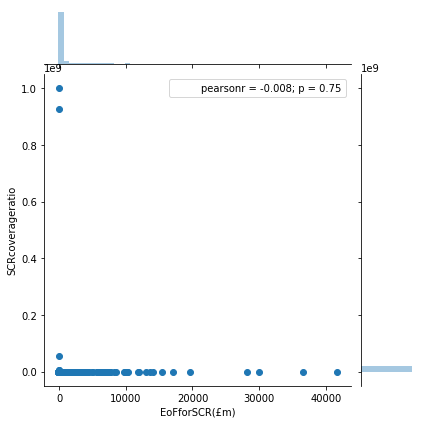

In [95]:
# Using seaborn
sns.jointplot(x='EoFforSCR(£m)',y='SCRcoverageratio',data=df3_long, kind='scatter')

We see clear anomalies at high values of EoFforSCR(£m) and SCRCoverageRatio.

#### Outliers from the norm for a single reporting period

Examining Total assets (£m) vs. Total liabilities (£m) for the Year 2016

In [96]:
df3_long[df3_long['Year']==2016].iplot(kind='scatter',x='Totalassets(£m)',y='Totalliabilities(£m)',mode='markers',color='red'
                                       ,title='Total assets (£m) vs. Total liabilities (£m) for the Year 2016',xTitle='Totalassets(£m)',yTitle='Totalliabilities(£m)')

From this, we can infer that firms with total assets > 100K or total liabilities > 100K should be given more attention to. The following are the unique firms that satisfy this criteria. These firms are a subset of the ones we saw above in a similar graph for all years:

In [97]:
print(df3_long[(df3_long['Year']==2016) & ((df3_long['Totalassets(£m)']>100000) | (df3_long['Totalliabilities(£m)']>100000))]['Firm'].unique())

['Firm 10' 'Firm 101' 'Firm 105' 'Firm 210' 'Firm 216' 'Firm 247'
 'Firm 311' 'Firm 34']


Examining GWP(£m) vs. NWP(£m) for the Year 2020

In [98]:
df3_long[df3_long['Year']==2020].iplot(kind='scatter',x='GWP(£m)',y='NWP(£m)',mode='markers',color='green'
                                       ,title='GWP(£m) vs. NWP(£m) for the Year 2020',xTitle='Gross Written Premium (£m)',yTitle='Net Written Premium(£m)')

On zooming into this interactive plot, we see that there are clear anomalies or firms that need to be focused on where at higher values of GWP(£m) and NWP(£m).

#### Examining some more boxplots

Boxplots to detect outliers

In [99]:
df3_long[['GWP(£m)','NWP(£m)','SCR(£m)','EoFforSCR(£m)','SCRcoverageratio','Totalassets(£m)','Totalliabilities(£m)','Excessofassetsoverliabilities(£m)[=equity]','GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)','NetBEL(inc.TPsasawhole,pre-TMTP)(£m)','Grossclaimsincurred(£m)']].iplot(kind='box')

This points to anomalous/erroneous values in the SCRcoverageratio. I will check this in detail in the erroneous reporting section.

In [100]:
df3_long[['Grosscombinedratio','Grossexpenseratio','Netcombinedratio','Netexpenseratio','Puregrossclaimsratio','Purenetclaimsratio']].iplot(kind='box')

Using matplotlib - Plotting using other visualisation libraries

Text(0,0.5,'EoF for SCR (£m)')

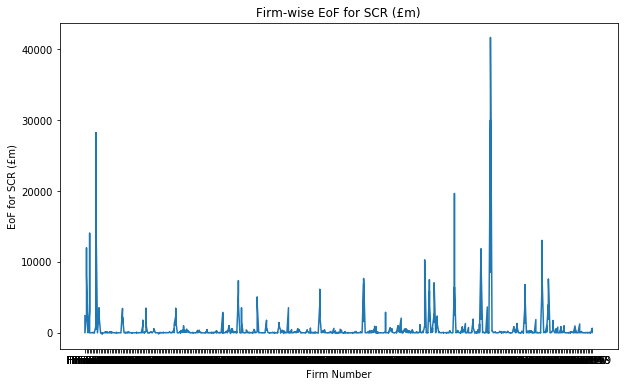

In [101]:
x = df3_long['Firm']
y = df3_long['EoFforSCR(£m)']

plt.figure(figsize=(10,6))
plt.plot(x, y)
plt.title('Firm-wise EoF for SCR (£m)')
plt.xlabel('Firm Number')
plt.ylabel('EoF for SCR (£m)')

## Focusing on the third objective to identify outliers from the norm (when looking at a single reporting period, does a firm deviate significantly from the average?)

The reason for choosing 2020 as the single period for analysis, is that based on prior knowledge and discussions, supervisors may tend to focus their attention on the most recent data of firms. Since our dataset has 2020 as the most recent year, I have selected this for my analysis. However, the same can be replicated on the previous years' data as well.

Before we proceed with Machine Learning techniques on the data to identify firms deviating from the norm, we need to perform certain preprocessing as the variables have different scales. This can be achieved through scaling. 

### Data Preprocessing

In [102]:
# Copy of df3_long

df3_long_copy2 = df3_long.copy()

In [103]:
# Break df3_long year-wise

df3_long_2020 = df3_long[df3_long['Year']==2020]
df3_long_2019 = df3_long[df3_long['Year']==2019]
df3_long_2018 = df3_long[df3_long['Year']==2018]
df3_long_2017 = df3_long[df3_long['Year']==2017]
df3_long_2016 = df3_long[df3_long['Year']==2016]

In [104]:
df3_long_2020.shape

(325, 32)

In [105]:
# Setting the index of the dataframe as the firm and dropping the year column

df3_long_2020 = df3_long_2020.set_index('Firm')
df3_long_2020 = df3_long_2020.drop('Year',axis=1)

In [106]:
df3_long_2020.head()

EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]  \
Firm                                                                  
Firm 1         0.000000                                    0.000000   
Firm 10     8207.819857                                 9062.225268   
Firm 100      65.980958                                   71.114779   
Firm 101       0.000000                                    0.000000   
Firm 102       0.000000                                    0.000000   

             GWP(£m)     NWP(£m)      SCR(£m)  SCRcoverageratio  \
Firm                                                              
Firm 1      0.000000    0.000000     0.000000          0.000000   
Firm 10   882.479158  221.986516  1773.693684          0.598787   
Firm 100   29.951861   55.765640    70.577824          0.205001   
Firm 101    0.000000    0.000000     0.000000          0.000000   
Firm 102    0.000000    0.000000     0.000000          0.000000   

          Totalassets(£m)  Totalliabilities(£m)  \
Firm                                              
Firm 1           0.000000              0.000000   
Firm 10     195835.579311         254270.412386   
Firm 100         9.149835            134.552953   
Firm 101         0.000000              0.000000   
Firm 102         0.000000              0.000000   

          GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  Grossclaimsincurred(£m)  \
Firm                                                                       
Firm 1                                 0.000000                 0.000000   
Firm 10                              253.330250               189.697324   
Firm 100                             128.466329               106.679797   
Firm 101                               0.000000                 0.000000   
Firm 102                              23.180702               137.973399   

                         ...                  NWP_perc_change_YoY  \
Firm                     ...                                        
Firm 1                   ...                             0.000000   
Firm 10                  ...                           -95.728251   
Firm 100                 ...                            13.211549   
Firm 101                 ...                          -100.000000   
Firm 102                 ...                             0.000000   

          SCRCovRatio_abs_change_YoY  SCRCovRatio_perc_change_YoY  \
Firm                                                                
Firm 1                      0.000000                     0.000000   
Firm 10                    -0.513246                   -46.153849   
Firm 100                   -0.701313                   -77.380840   
Firm 101                   -1.875703                  -100.000000   
Firm 102                    0.000000                     0.000000   

          Grossclaimsincur_abs_change_YoY  Grossclaimsincur_perc_change_YoY  \
Firm                                                                          
Firm 1                           0.000000                          0.000000   
Firm 10                         66.712770                         54.244836   
Firm 100                        45.571678                         74.575488   
Firm 101                         0.000000                          0.000000   
Firm 102                      -438.830842                        -76.079684   

          Netcombratio_abs_change_YoY  Netcombratio_perc_change_YoY  \
Firm                                                                  
Firm 1                       0.000000                      0.000000   
Firm 10                     -1.435704                    -95.052935   
Firm 100                    -0.879147                    -95.390923   
Firm 101                     0.000000                      0.000000   
Firm 102                     0.298935                     21.684020   

          NWP_abs_change_YoY_z  Grossclaimsincur_abs_change_YoY_z  \
Firm                                                          

In [107]:
df3_long_2020.shape

(325, 30)

I have tested the RobustScaler(), StandardScaler() and MinMaxScaler() for this, with the MinMaxScaler() giving a better performance for identifying anomalous clusters through the clustering algorithm. The underlying reason for this could be that the robust scaler uses the interquartile range so that it is robust to outliers, and hence the scaled data for outliers and the ‘normal’ data points are not very different, thereby making it harder for the clustering algorithm to separate them into a different cluster. However, the MinMaxScaler() uses the maximum and minimum values for the variable, so the outliers would correspond to the maximum and minimum scaled values, while the ‘normal’ data points will be squished into a narrower range, making it easier for the clustering algorithm to differentiate them.

In [108]:
# Using MinMaxScaler() 

scaler = preprocessing.MinMaxScaler()
df3_long_2020_scaled = scaler.fit_transform(df3_long_2020)

In [109]:
df3_long_2020_scaled.shape

(325, 30)

In [110]:
df3_long_2020_scaled = pd.DataFrame(df3_long_2020_scaled, columns=df3_long_2020.columns, index = df3_long_2020.index)

In [111]:
df3_long_2020_scaled.head(5)

EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]   GWP(£m)  \
Firm                                                                            
Firm 1         0.003882                                    0.004871  0.000121   
Firm 10        0.200248                                    0.378634  0.012781   
Firm 100       0.005460                                    0.007804  0.000551   
Firm 101       0.003882                                    0.004871  0.000121   
Firm 102       0.003882                                    0.004871  0.000121   

           NWP(£m)   SCR(£m)  SCRcoverageratio  Totalassets(£m)  \
Firm                                                              
Firm 1    0.032739  0.000000          0.000008         0.000204   
Firm 10   0.036277  0.096735          0.000015         1.000000   
Firm 100  0.033628  0.003849          0.000010         0.000251   
Firm 101  0.032739  0.000000          0.000008         0.000204   
Firm 102  0.032739  0.000000          0.000008         0.000204   

          Totalliabilities(£m)  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
Firm                                                                    
Firm 1                0.002998                               0.016682   
Firm 10               0.515655                               0.045586   
Firm 100              0.003270                               0.031340   
Firm 101              0.002998                               0.016682   
Firm 102              0.002998                               0.019327   

          Grossclaimsincurred(£m)                 ...                  \
Firm                                              ...                   
Firm 1                   0.012433                 ...                   
Firm 10                  0.081037                 ...                   
Firm 100                 0.051014                 ...                   
Firm 101                 0.012433                 ...                   
Firm 102                 0.062331                 ...                   

          NWP_perc_change_YoY  SCRCovRatio_abs_change_YoY  \
Firm                                                        
Firm 1               0.620734                    0.024469   
Firm 10              0.618077                    0.024369   
Firm 100             0.621101                    0.024332   
Firm 101             0.617959                    0.024103   
Firm 102             0.620734                    0.024469   

          SCRCovRatio_perc_change_YoY  Grossclaimsincur_abs_change_YoY  \
Firm                                                                     
Firm 1                       0.009549                         0.554534   
Firm 10                      0.005142                         0.568270   
Firm 100                     0.002160                         0.563917   
Firm 101                     0.000000                         0.554534   
Firm 102                     0.009549                         0.464179   

          Grossclaimsincur_perc_change_YoY  Netcombratio_abs_change_YoY  \
Firm                                                                      
Firm 1                            0.000090                     0.963348   
Firm 10                           0.000093                     0.963316   
Firm 100                          0.000094                     0.963328   
Firm 101                          0.000090                     0.963348   
Firm 102                          0.000085                     0.963355   

          Netcombratio_perc_change_YoY  NWP_abs_change_YoY_z  \
Firm                                                           
Firm 1                        0.136042              0.347051   
Firm 10                       0.125112              0.254843   
Firm 100                      0.125073              0.347171   
Firm 101                      0.136042              0.258003   
Firm 102                      0.138535              0.347051   

          Grossclaimsincur

Even though clustering doesn't rely on linear assumptions, and so collinearity wouldn't cause major issues, it may lead to overly redundant features, large computational requirements and we may be using more data than required to reach the same patterns. Additionally, as the data in the PRA for supervision can be very large, we need to be conscious of ensuring an optimum utilisation of computational resources.

#### Preparing the data frame for unsupervised learning by retaining only one of two highly correlated variables

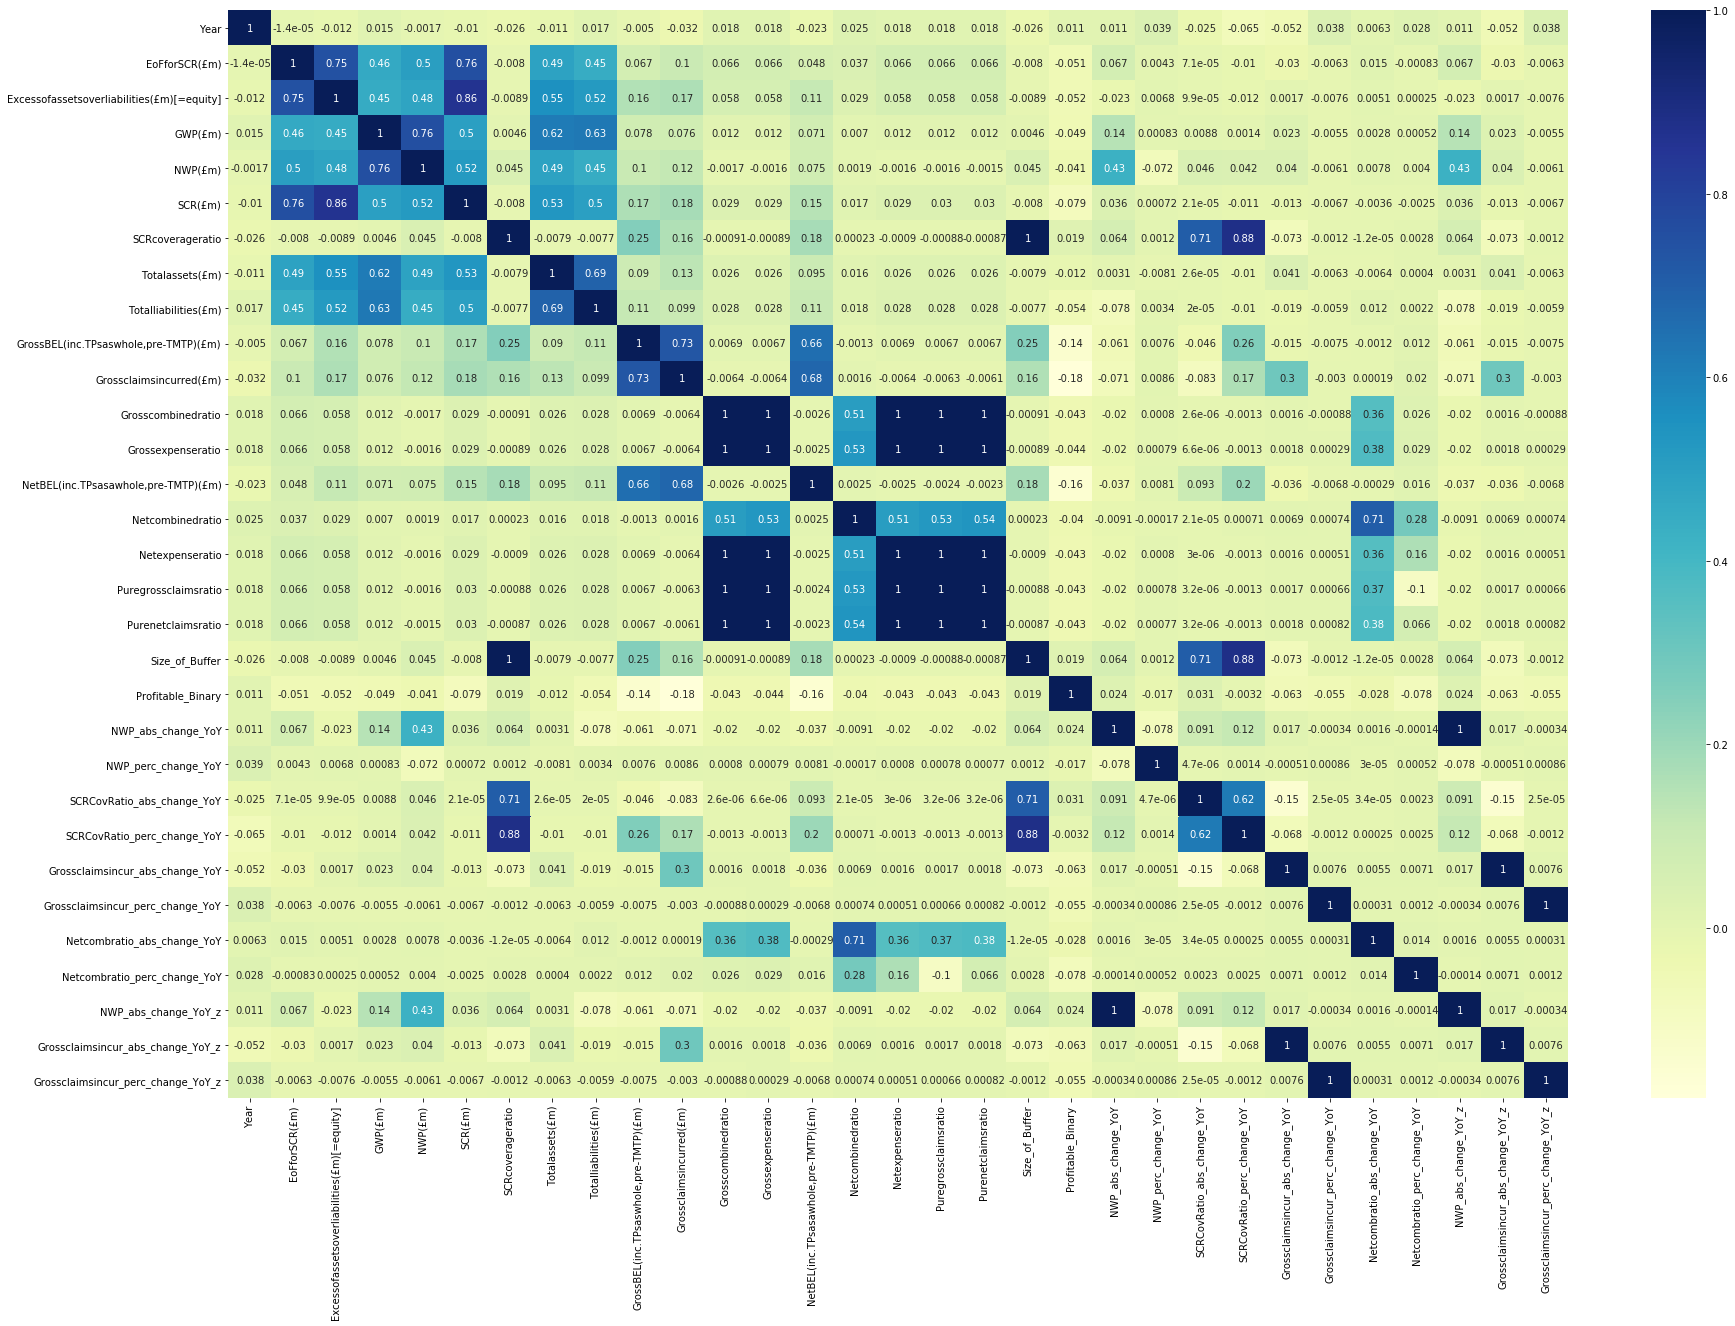

In [112]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df3_long.corr(),annot=True,cmap="YlGnBu")

From the ratios, I am retaining netcombinedratio and Puregrossclaims ratio. I am dropping the derived variables on year-on-year changes and the excess of assets over liabilities

In [113]:
df3_long_2020_scaled2 = df3_long_2020_scaled.copy()

In [114]:
df3_long_2020_scaled2 = df3_long_2020_scaled2.drop(['Grosscombinedratio','Grossexpenseratio','Netexpenseratio','Purenetclaimsratio',
                                                    'Excessofassetsoverliabilities(£m)[=equity]','NWP_abs_change_YoY',
                                                    'NWP_perc_change_YoY', 'SCRCovRatio_abs_change_YoY','SCRCovRatio_perc_change_YoY', 
                                                    'Grossclaimsincur_abs_change_YoY',
                                                       'Grossclaimsincur_perc_change_YoY', 'Netcombratio_abs_change_YoY',
                                                   'Netcombratio_perc_change_YoY', 'NWP_abs_change_YoY_z',
                                                   'Grossclaimsincur_abs_change_YoY_z','Grossclaimsincur_perc_change_YoY_z',
                                                   'Profitable_Binary'],axis=1)

In [115]:
df3_long_2020_scaled2.columns

Index(['EoFforSCR(£m)', 'GWP(£m)', 'NWP(£m)', 'SCR(£m)', 'SCRcoverageratio',
       'Totalassets(£m)', 'Totalliabilities(£m)',
       'GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)', 'Grossclaimsincurred(£m)',
       'NetBEL(inc.TPsasawhole,pre-TMTP)(£m)', 'Netcombinedratio',
       'Puregrossclaimsratio', 'Size_of_Buffer'],
      dtype='object')

In [116]:
df3_long_2020_scaled2.shape

(325, 13)

# Unsupervised Learning

### - Partitional (K-Means Clustering), Hierarchical Clustering and Density Based Clustering (Using DBSCAN())
### - Isolation Forest for Anomaly Detection

I started with k-means clustering which is a method of partitional clustering. It is faster and more computationally efficient and provides a good view of our data. 

An important decision in K-means is the choice of 'k' beforehand. I am examining this through the elbow plot and silhouette coefficient.

In [125]:
kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 101,
   }

sse = []

for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(df3_long_2020_scaled2)
            sse.append(kmeans.inertia_)

The graph shows an elbow point at 3 and 6 clusters, but does not completely flatten. However, it is not a clear elbow, making the choice of the number of clusters a subjective decision. 

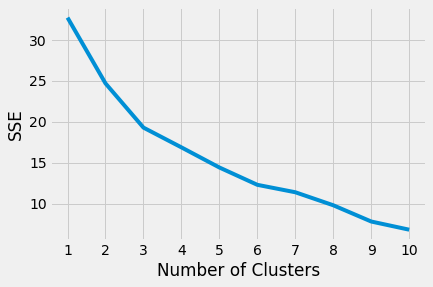

In [126]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [127]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

In [128]:
kl.elbow

3

In [129]:
# Using the silhouette coefficient
silhouette_coefficients = []
for k in range(2, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(df3_long_2020_scaled2)
     score = silhouette_score(df3_long_2020_scaled2, kmeans.labels_)
     silhouette_coefficients.append(score)

The best choice for k is 3, 4 or 6 since they have high silhouette scores

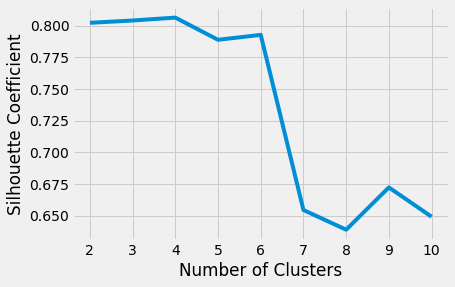

In [138]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [130]:
# Fitting the k-means algorithm to our data
kmeans = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=101)

kmeans.fit(df3_long_2020_scaled2)

KMeans(init='random', n_clusters=3, random_state=101)

The kmeans.inertia_ gives us the lowest SSE value i.e. the lower the model inertia, the better the fit. An inertia of 19.29 indicates a good fit. 

In [131]:
kmeans.inertia_

19.285219599086727

In [132]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[1.97794551e-01, 2.39719297e-01, 2.57604705e-01, 2.47018456e-01,
        2.88398343e-05, 5.58592120e-01, 2.49918394e-01, 5.81720596e-02,
        8.29488576e-02, 5.25099617e-02, 6.91435241e-03, 2.71801433e-02,
        2.88398343e-05],
       [4.52560435e-02, 1.08550234e-02, 3.73470427e-02, 9.45608065e-02,
        2.59479895e-05, 5.19631001e-02, 3.61290680e-02, 4.14963799e-01,
        5.49478047e-01, 4.63205765e-01, 7.42346699e-03, 2.82070239e-02,
        2.59479895e-05],
       [8.33089838e-03, 3.66423617e-03, 3.63579107e-02, 6.45512540e-03,
        3.35829865e-03, 9.44962861e-03, 6.36688626e-03, 3.37583416e-02,
        3.44107947e-02, 2.91575566e-02, 1.60905083e-02, 3.61365962e-02,
        3.35829865e-03]])

In [133]:
# The number of iterations required to converge
kmeans.n_iter_

6

In [134]:
kmeans.labels_

array([2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,

Our data is multivariate i.e. it has many dimensions. The best way to plot the clusters would be by reducing it to two dimensions using Principal Component Analysis (PCA) and then plotting it. 

In [135]:
df3_long_2020_scaled2['clusters'] = kmeans.fit_predict(df3_long_2020_scaled2)

In [136]:
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df3_long_2020_scaled2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'],index=df3_long_2020_scaled2.index)

In [137]:
results['clusters'] = df3_long_2020_scaled2['clusters']

In [138]:
results['clusters'].value_counts()

2    301
0     13
1     11
Name: clusters, dtype: int64

In [139]:
fig = px.scatter(results,x='pca1',y='pca2',color='clusters')
fig.show()

Identifying firms in Clusters 0 and 1 to investigate

In [141]:
df3_long_2020_scaled2[(df3_long_2020_scaled2['clusters']==0) | (df3_long_2020_scaled2['clusters']==1)] 

EoFforSCR(£m)   GWP(£m)   NWP(£m)   SCR(£m)  SCRcoverageratio  \
Firm                                                                      
Firm 10        0.200248  0.012781  0.036277  0.096735          0.000015   
Firm 105       0.414271  0.084145  0.074371  1.000000          0.000021   
Firm 112       0.003882  0.000121  0.032739  0.000000          0.000008   
Firm 151       0.044966  0.227140  0.121247  0.026119          0.000015   
Firm 158       0.012220  0.017513  0.039636  0.020882          0.000041   
Firm 17        0.003882  0.000121  0.032739  0.000000          0.000008   
Firm 199       0.104688  0.033194  0.242023  0.159187          0.000024   
Firm 210       0.027681  1.000000  1.000000  0.000635          0.000010   
Firm 22        0.006421  0.000897  0.033193  0.006964          0.000027   
Firm 247       0.004455  0.130887  0.035792  0.000699          0.000097   
Firm 26        0.187170  0.148633  0.294006  0.161477          0.000012   
Firm 261       0.003882  0.000121  0.032739  0.000000          0.000008   
Firm 280       0.020690  0.014916  0.032767  0.010071          0.000042   
Firm 283       0.016758  0.000304  0.032935  0.000493          0.000038   
Firm 286       0.007116  0.000659  0.033824  0.000761          0.000012   
Firm 298       0.094568  0.015721  0.046190  0.229613          0.000021   
Firm 304       0.004333  0.000445  0.033121  0.000753          0.000042   
Firm 311       0.157278  0.348030  0.264855  0.890266          0.000028   
Firm 34        0.238183  0.276637  0.130031  0.162038          0.000036   
Firm 4         1.000000  0.541849  0.816818  0.877546          0.000021   
Firm 52        0.004363  0.000163  0.032752  0.000245          0.000038   
Firm 6         0.138538  0.060504  0.127867  0.169233          0.000036   
Firm 7         0.187908  0.232289  0.136105  0.169397          0.000009   
Firm 73        0.185646  0.088685  0.097649  0.268293          0.000051   

          Totalassets(£m)  Totalliabilities(£m)  \
Firm                                              
Firm 10          1.000000              0.515655   
Firm 105         0.537345              0.356088   
Firm 112         0.000204              0.002998   
Firm 151         0.634923              0.192494   
Firm 158         0.000988              0.004472   
Firm 17          0.000204              0.002998   
Firm 199         0.795411              0.032125   
Firm 210         0.819697              0.027853   
Firm 22          0.004569              0.004566   
Firm 247         0.511167              0.163597   
Firm 26          0.424941              0.018757   
Firm 261         0.000204              0.002998   
Firm 280         0.008895              0.005445   
Firm 283         0.001296              0.003337   
Firm 286         0.016383              0.007899   
Firm 298         0.351814              0.241845   
Firm 304         0.001182              0.003593   
Firm 311         0.315897              1.000000   
Firm 34          0.817685              0.370476   
Firm 4           0.191262              0.189038   
Firm 52          0.000324              0.003026   
Firm 6           0.549266              0.018957   
Firm 7           0.300497              0.362470   
Firm 73          0.549139              0.115671   

          GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  Grossclaimsincurred(£m)  \
Firm                                                                       
Firm 10                                0.045586                 0.081037   
Firm 105                               1.000000                 0.204299   
Firm 112                               0.098224                 0.843019   
Firm 151                               0.057403                 0.007277   
Firm 158                               0.606831                 0.813216   
Firm 17                                0.549922                 0.528190   
Firm 199                               0.126254                 0.100869   
Firm 210                               0.263092 

|k |Inertia|No. of Iterations to Converge| 
|-----|:-----|:---:|:-----:|
|3 |19.3  |6   |
|4|22.5|5   |
|6|12.3|12   |

I tried clustering with k as 3,4 and 6. The best choice of k is 3 as inertia is not very high and number of iterations to converge is half of that at 6 clusters. Also, the outlying firms are sitting in two distinct clusters out of 3 (as seen above). Proceeding to see whether density based and hierarchical clustering has different results.

In [142]:
clus_kmeans_firms = (df3_long_2020_scaled2[(df3_long_2020_scaled2['clusters']==0) | (df3_long_2020_scaled2['clusters']==1)]).index

In [143]:
clus_kmeans_firms

Index(['Firm 10', 'Firm 105', 'Firm 112', 'Firm 151', 'Firm 158', 'Firm 17',
       'Firm 199', 'Firm 210', 'Firm 22', 'Firm 247', 'Firm 26', 'Firm 261',
       'Firm 280', 'Firm 283', 'Firm 286', 'Firm 298', 'Firm 304', 'Firm 311',
       'Firm 34', 'Firm 4', 'Firm 52', 'Firm 6', 'Firm 7', 'Firm 73'],
      dtype='object', name='Firm')

The k-means algorithm flagged 24 firms (out of the 325 input firms) sitting in the two ‘anomalous’ clusters.

In [144]:
len(clus_kmeans_firms)

24

# Density Based Clustering Using DBSCAN ()

DBSCAN tends to be robust to the presence of noise and outliers in the data, while k-means clustering could be sensitive to outliers. The possible reason why k-means is performing well on our data, is that our aim is to give a differential treatment to outliers (essentially, to identify them), and not treat them as the ‘normal’ data points, which may be desired in most other use cases where k-means is used on a conventional dataset that has outliers. In other words, in k-means, since the cluster centroids are the means, there will be very few observations in the clusters where the 'outlier' firms sit, thereby facilitating their isolation.

Removing derived columns and highly correlated columns from the data

In [145]:
df3_long_2020_db = df3_long_2020.copy()

Using MinMaxScaler() 

In [146]:
scaler = preprocessing.MinMaxScaler()
df3_long_2020_scaled_db = scaler.fit_transform(df3_long_2020_db)

In [147]:
df3_long_2020_scaled_db.shape

(325, 30)

In [148]:
df3_long_2020_scaled_db = pd.DataFrame(df3_long_2020_scaled_db, columns=df3_long_2020_db.columns, index = df3_long_2020_db.index)

In [149]:
df3_long_2020_scaled_db.head(2)

EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]   GWP(£m)  \
Firm                                                                           
Firm 1        0.003882                                    0.004871  0.000121   
Firm 10       0.200248                                    0.378634  0.012781   

          NWP(£m)   SCR(£m)  SCRcoverageratio  Totalassets(£m)  \
Firm                                                             
Firm 1   0.032739  0.000000          0.000008         0.000204   
Firm 10  0.036277  0.096735          0.000015         1.000000   

         Totalliabilities(£m)  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
Firm                                                                   
Firm 1               0.002998                               0.016682   
Firm 10              0.515655                               0.045586   

         Grossclaimsincurred(£m)                 ...                  \
Firm                                             ...                   
Firm 1                  0.012433                 ...                   
Firm 10                 0.081037                 ...                   

         NWP_perc_change_YoY  SCRCovRatio_abs_change_YoY  \
Firm                                                       
Firm 1              0.620734                    0.024469   
Firm 10             0.618077                    0.024369   

         SCRCovRatio_perc_change_YoY  Grossclaimsincur_abs_change_YoY  \
Firm                                                                    
Firm 1                      0.009549                         0.554534   
Firm 10                     0.005142                         0.568270   

         Grossclaimsincur_perc_change_YoY  Netcombratio_abs_change_YoY  \
Firm                                                                     
Firm 1                           0.000090                     0.963348   
Firm 10                          0.000093                     0.963316   

         Netcombratio_perc_change_YoY  NWP_abs_change_YoY_z  \
Firm                                                          
Firm 1                       0.136042              0.347051   
Firm 10                      0.125112              0.254843   

         Grossclaimsincur_abs_change_YoY_z  Grossclaimsincur_perc_change_YoY_z  
Firm                                                                            
Firm 1                            0.554534                            0.000090  
Firm 10                           0.568270                            0.000093  

[2 rows x 30 columns]

In [150]:
df3_long_2020_scaled_db = df3_long_2020_scaled_db.drop(['Grosscombinedratio','Grossexpenseratio','Netexpenseratio','Purenetclaimsratio',
                                                    'Excessofassetsoverliabilities(£m)[=equity]','NWP_abs_change_YoY',
                                                    'NWP_perc_change_YoY', 'SCRCovRatio_abs_change_YoY','SCRCovRatio_perc_change_YoY', 
                                                    'Grossclaimsincur_abs_change_YoY',
                                                       'Grossclaimsincur_perc_change_YoY', 'Netcombratio_abs_change_YoY',
                                                   'Netcombratio_perc_change_YoY', 'NWP_abs_change_YoY_z',
                                                   'Grossclaimsincur_abs_change_YoY_z','Grossclaimsincur_perc_change_YoY_z',
                                                   'Profitable_Binary'],axis=1)

In [151]:
df3_long_2020_scaled_db.shape

(325, 13)

For DBSCAN, the choice of minPts and E is a subjective one, however advised as the following: 
    - minPts: The minimum number of points (a threshold) clustered together for a region to be considered dense. For multidimensional dataset, minPts should be 2 * number of dimensions. Here, minPts = 2 x 13 = 26
    - eps (ε): A distance measure that will be used to locate the points in the neighborhood of any point.

Choosing the optimal value of E (Using KNN)

In [152]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 26 (taking odd number) as kneighbors function returns distance of point to itself 
nbrs = NearestNeighbors(n_neighbors = 25).fit(df3_long_2020_scaled_db)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df3_long_2020_scaled_db)
# sort the neighbor distances (lengths to points) in ascending order
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

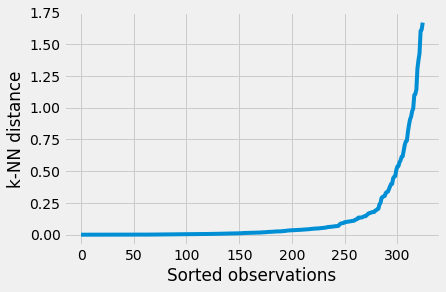

In [153]:
k_dist = sort_neigh_dist[:, 24]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations")
plt.show()

In [154]:
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
print(kneedle.knee_y)

0.6133096306380261


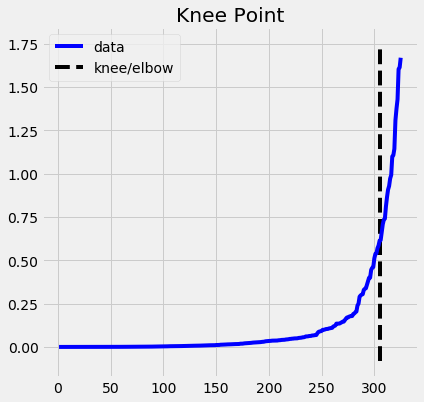

In [183]:
kneedle.plot_knee()

In [155]:
clustering = DBSCAN(eps=0.3, min_samples=26).fit(df3_long_2020_scaled_db)

In [156]:
DBSCAN_dataset = df3_long_2020_scaled_db.copy()

In [157]:
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

In [158]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

Cluster
 0      298
-1       27

In [159]:
# Similar outlying firms as obtained by the K-means algorithm

DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

EoFforSCR(£m)   GWP(£m)   NWP(£m)       SCR(£m)  SCRcoverageratio  \
Firm                                                                          
Firm 10        0.200248  0.012781  0.036277  9.673512e-02          0.000015   
Firm 105       0.414271  0.084145  0.074371  1.000000e+00          0.000021   
Firm 112       0.003882  0.000121  0.032739  0.000000e+00          0.000008   
Firm 127       0.003882  0.000121  0.032739  1.025380e-11          1.000000   
Firm 151       0.044966  0.227140  0.121247  2.611859e-02          0.000015   
Firm 158       0.012220  0.017513  0.039636  2.088170e-02          0.000041   
Firm 166       0.004713  0.000223  0.032797  7.183114e-04          0.000040   
Firm 17        0.003882  0.000121  0.032739  0.000000e+00          0.000008   
Firm 199       0.104688  0.033194  0.242023  1.591873e-01          0.000024   
Firm 210       0.027681  1.000000  1.000000  6.347216e-04          0.000010   
Firm 22        0.006421  0.000897  0.033193  6.963569e-03          0.000027   
Firm 228       0.004850  0.000337  0.032873  1.655100e-03          0.000034   
Firm 26        0.187170  0.148633  0.294006  1.614774e-01          0.000012   
Firm 270       0.003882  0.000121  0.032739  0.000000e+00          0.000008   
Firm 283       0.016758  0.000304  0.032935  4.928271e-04          0.000038   
Firm 284       0.005051  0.000552  0.033453  1.154657e-02          0.000016   
Firm 286       0.007116  0.000659  0.033824  7.610750e-04          0.000012   
Firm 304       0.004333  0.000445  0.033121  7.530766e-04          0.000042   
Firm 311       0.157278  0.348030  0.264855  8.902661e-01          0.000028   
Firm 34        0.238183  0.276637  0.130031  1.620383e-01          0.000036   
Firm 4         1.000000  0.541849  0.816818  8.775461e-01          0.000021   
Firm 52        0.004363  0.000163  0.032752  2.452999e-04          0.000038   
Firm 6         0.138538  0.060504  0.127867  1.692333e-01          0.000036   
Firm 7         0.187908  0.232289  0.136105  1.693972e-01          0.000009   
Firm 72        0.023621  0.014396  0.040663  1.636959e-02          0.000038   
Firm 73        0.185646  0.088685  0.097649  2.682934e-01          0.000051   
Firm 99        0.005675  0.006802  0.035010  2.451153e-02          0.000036   

          Totalassets(£m)  Totalliabilities(£m)  \
Firm                                              
Firm 10          1.000000              0.515655   
Firm 105         0.537345              0.356088   
Firm 112         0.000204              0.002998   
Firm 127         0.000206              0.002999   
Firm 151         0.634923              0.192494   
Firm 158         0.000988              0.004472   
Firm 166         0.000426              0.003125   
Firm 17          0.000204              0.002998   
Firm 199         0.795411              0.032125   
Firm 210         0.819697              0.027853   
Firm 22          0.004569              0.004566   
Firm 228         0.000620              0.003047   
Firm 26          0.424941              0.018757   
Firm 270         0.000204              0.002998   
Firm 283         0.001296              0.003337   
Firm 284         0.091970              0.009265   
Firm 286         0.016383              0.007899   
Firm 304         0.001182              0.003593   
Firm 311         0.315897              1.000000   
Firm 34          0.817685              0.370476   
Firm 4           0.191262              0.189038   
Firm 52          0.000324              0.003026   
Firm 6           0.549266              0.018957   
Firm 7           0.300497              0.362470   
Firm 72          0.005690              0.003367   
Firm 73          0.549139              0.115671   
Firm 99          0.007050              0.005990   

          GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  Grossclaimsincurred(£m)  \
Firm                                                                       
Firm 10                                0.045586                 0.081037   
Firm 105  

In [160]:
clus_dbscan_firms = (DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]).index

In [161]:
clus_dbscan_firms

Index(['Firm 10', 'Firm 105', 'Firm 112', 'Firm 127', 'Firm 151', 'Firm 158',
       'Firm 166', 'Firm 17', 'Firm 199', 'Firm 210', 'Firm 22', 'Firm 228',
       'Firm 26', 'Firm 270', 'Firm 283', 'Firm 284', 'Firm 286', 'Firm 304',
       'Firm 311', 'Firm 34', 'Firm 4', 'Firm 52', 'Firm 6', 'Firm 7',
       'Firm 72', 'Firm 73', 'Firm 99'],
      dtype='object', name='Firm')

The results from density-based clustering are two clusters, with one containing the outlying firms (27 firms out of the 325 firms input into the model). 

In [162]:
len(clus_dbscan_firms)

27

In [163]:
print(list(np.intersect1d(clus_kmeans_firms, clus_dbscan_firms)) )

['Firm 10', 'Firm 105', 'Firm 112', 'Firm 151', 'Firm 158', 'Firm 17', 'Firm 199', 'Firm 210', 'Firm 22', 'Firm 26', 'Firm 283', 'Firm 286', 'Firm 304', 'Firm 311', 'Firm 34', 'Firm 4', 'Firm 52', 'Firm 6', 'Firm 7', 'Firm 73']


Validating this by seeing the intersection of the anomalous firms highlighted by k-means and DBSCAN, to see that there is an overlap of 20 firms between the two algorithms.

In [164]:
len(list(np.intersect1d(clus_kmeans_firms, clus_dbscan_firms)) )

20

# Hierarchical Clustering (Agglomerative)

In [165]:
df3_long_2020_hc = df3_long_2020.copy()

Using MinMaxScaler() 

In [166]:
scaler = preprocessing.MinMaxScaler()
df3_long_2020_scaled_hc = scaler.fit_transform(df3_long_2020_hc)

In [167]:
df3_long_2020_scaled_hc.shape

(325, 30)

In [168]:
df3_long_2020_scaled_hc = pd.DataFrame(df3_long_2020_scaled_hc, columns=df3_long_2020_hc.columns, index = df3_long_2020_hc.index)

In [169]:
df3_long_2020_scaled_hc.head(2)

EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]   GWP(£m)  \
Firm                                                                           
Firm 1        0.003882                                    0.004871  0.000121   
Firm 10       0.200248                                    0.378634  0.012781   

          NWP(£m)   SCR(£m)  SCRcoverageratio  Totalassets(£m)  \
Firm                                                             
Firm 1   0.032739  0.000000          0.000008         0.000204   
Firm 10  0.036277  0.096735          0.000015         1.000000   

         Totalliabilities(£m)  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
Firm                                                                   
Firm 1               0.002998                               0.016682   
Firm 10              0.515655                               0.045586   

         Grossclaimsincurred(£m)                 ...                  \
Firm                                             ...                   
Firm 1                  0.012433                 ...                   
Firm 10                 0.081037                 ...                   

         NWP_perc_change_YoY  SCRCovRatio_abs_change_YoY  \
Firm                                                       
Firm 1              0.620734                    0.024469   
Firm 10             0.618077                    0.024369   

         SCRCovRatio_perc_change_YoY  Grossclaimsincur_abs_change_YoY  \
Firm                                                                    
Firm 1                      0.009549                         0.554534   
Firm 10                     0.005142                         0.568270   

         Grossclaimsincur_perc_change_YoY  Netcombratio_abs_change_YoY  \
Firm                                                                     
Firm 1                           0.000090                     0.963348   
Firm 10                          0.000093                     0.963316   

         Netcombratio_perc_change_YoY  NWP_abs_change_YoY_z  \
Firm                                                          
Firm 1                       0.136042              0.347051   
Firm 10                      0.125112              0.254843   

         Grossclaimsincur_abs_change_YoY_z  Grossclaimsincur_perc_change_YoY_z  
Firm                                                                            
Firm 1                            0.554534                            0.000090  
Firm 10                           0.568270                            0.000093  

[2 rows x 30 columns]

In [170]:
df3_long_2020_scaled_hc = df3_long_2020_scaled_hc.drop(['Grosscombinedratio','Grossexpenseratio','Netexpenseratio','Purenetclaimsratio',
                                                    'Excessofassetsoverliabilities(£m)[=equity]','NWP_abs_change_YoY',
                                                    'NWP_perc_change_YoY', 'SCRCovRatio_abs_change_YoY','SCRCovRatio_perc_change_YoY', 
                                                    'Grossclaimsincur_abs_change_YoY',
                                                       'Grossclaimsincur_perc_change_YoY', 'Netcombratio_abs_change_YoY',
                                                   'Netcombratio_perc_change_YoY', 'NWP_abs_change_YoY_z',
                                                   'Grossclaimsincur_abs_change_YoY_z','Grossclaimsincur_perc_change_YoY_z',
                                                   'Profitable_Binary'],axis=1)

#### Creating a dendrogram to decide the number of clusters we want

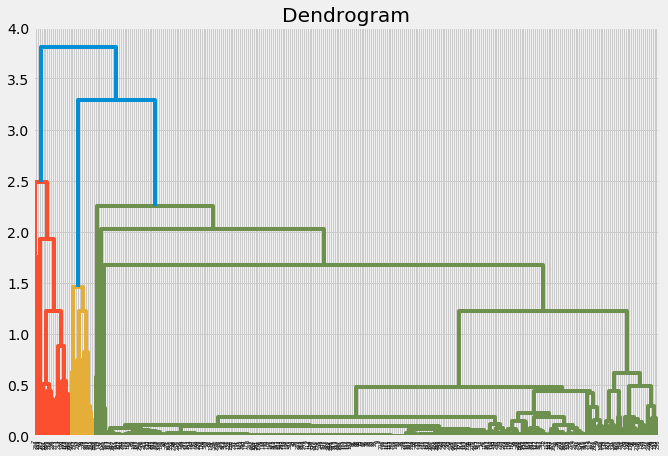

In [171]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(df3_long_2020_scaled_hc, method='ward'))

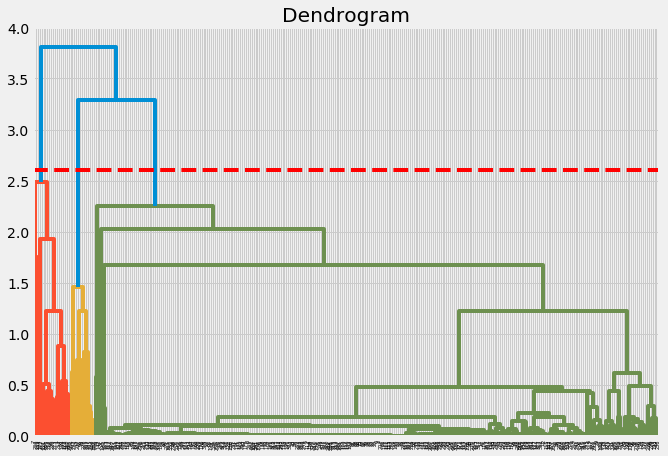

In [172]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(df3_long_2020_scaled_hc, method='ward'))
plt.axhline(y=2.6, color='r', linestyle='--')

In [173]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df3_long_2020_scaled_hc)

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1,

In [174]:
df3_long_2020_scaled_hc['Clusters'] = cluster.labels_

In [175]:
df3_long_2020_scaled_hc['Clusters'].value_counts()

1    293
0     20
2     12
Name: Clusters, dtype: int64

In [176]:
df3_long_2020_scaled_hc[(df3_long_2020_scaled_hc['Clusters']==2) | (df3_long_2020_scaled_hc['Clusters']==0)]

EoFforSCR(£m)   GWP(£m)   NWP(£m)   SCR(£m)  SCRcoverageratio  \
Firm                                                                      
Firm 10        0.200248  0.012781  0.036277  0.096735          0.000015   
Firm 105       0.414271  0.084145  0.074371  1.000000          0.000021   
Firm 112       0.003882  0.000121  0.032739  0.000000          0.000008   
Firm 151       0.044966  0.227140  0.121247  0.026119          0.000015   
Firm 158       0.012220  0.017513  0.039636  0.020882          0.000041   
Firm 17        0.003882  0.000121  0.032739  0.000000          0.000008   
Firm 188       0.100843  0.020918  0.000000  0.156137          0.000017   
Firm 199       0.104688  0.033194  0.242023  0.159187          0.000024   
Firm 208       0.003962  0.010180  0.065834  0.001711          0.000011   
Firm 210       0.027681  1.000000  1.000000  0.000635          0.000010   
Firm 22        0.006421  0.000897  0.033193  0.006964          0.000027   
Firm 247       0.004455  0.130887  0.035792  0.000699          0.000097   
Firm 26        0.187170  0.148633  0.294006  0.161477          0.000012   
Firm 261       0.003882  0.000121  0.032739  0.000000          0.000008   
Firm 276       0.008897  0.080274  0.081720  0.014353          0.000017   
Firm 280       0.020690  0.014916  0.032767  0.010071          0.000042   
Firm 283       0.016758  0.000304  0.032935  0.000493          0.000038   
Firm 286       0.007116  0.000659  0.033824  0.000761          0.000012   
Firm 295       0.249998  0.005363  0.054990  0.225959          0.000045   
Firm 298       0.094568  0.015721  0.046190  0.229613          0.000021   
Firm 30        0.172720  0.044504  0.086859  0.203422          0.000041   
Firm 304       0.004333  0.000445  0.033121  0.000753          0.000042   
Firm 311       0.157278  0.348030  0.264855  0.890266          0.000028   
Firm 34        0.238183  0.276637  0.130031  0.162038          0.000036   
Firm 4         1.000000  0.541849  0.816818  0.877546          0.000021   
Firm 51        0.003919  0.036339  0.093132  0.000244          0.000035   
Firm 52        0.004363  0.000163  0.032752  0.000245          0.000038   
Firm 6         0.138538  0.060504  0.127867  0.169233          0.000036   
Firm 7         0.187908  0.232289  0.136105  0.169397          0.000009   
Firm 73        0.185646  0.088685  0.097649  0.268293          0.000051   
Firm 74        0.003896  0.007627  0.038468  0.013157          0.000046   
Firm 81        0.003994  0.000122  0.032742  0.000090          0.000065   

          Totalassets(£m)  Totalliabilities(£m)  \
Firm                                              
Firm 10          1.000000              0.515655   
Firm 105         0.537345              0.356088   
Firm 112         0.000204              0.002998   
Firm 151         0.634923              0.192494   
Firm 158         0.000988              0.004472   
Firm 17          0.000204              0.002998   
Firm 188         0.331965              0.007459   
Firm 199         0.795411              0.032125   
Firm 208         0.279814              0.124795   
Firm 210         0.819697              0.027853   
Firm 22          0.004569              0.004566   
Firm 247         0.511167              0.163597   
Firm 26          0.424941              0.018757   
Firm 261         0.000204              0.002998   
Firm 276         0.287973              0.102590   
Firm 280         0.008895              0.005445   
Firm 283         0.001296              0.003337   
Firm 286         0.016383              0.007899   
Firm 295         0.083522              0.007485   
Firm 298         0.351814              0.241845   
Firm 30          0.226403              0.203709   
Firm 304         0.001182              0.003593   
Firm 311         0.315897              1.000000   
Firm 34          0.817685              0.370476   
Firm 4           0.191262              0.189038   
Firm 51          0.164960              0.044375   
Firm 52          0.000324      

In [177]:
clus_hier_firms = (df3_long_2020_scaled_hc[(df3_long_2020_scaled_hc['Clusters']==2) | (df3_long_2020_scaled_hc['Clusters']==0)]).index

In [178]:
clus_hier_firms

Index(['Firm 10', 'Firm 105', 'Firm 112', 'Firm 151', 'Firm 158', 'Firm 17',
       'Firm 188', 'Firm 199', 'Firm 208', 'Firm 210', 'Firm 22', 'Firm 247',
       'Firm 26', 'Firm 261', 'Firm 276', 'Firm 280', 'Firm 283', 'Firm 286',
       'Firm 295', 'Firm 298', 'Firm 30', 'Firm 304', 'Firm 311', 'Firm 34',
       'Firm 4', 'Firm 51', 'Firm 52', 'Firm 6', 'Firm 7', 'Firm 73',
       'Firm 74', 'Firm 81'],
      dtype='object', name='Firm')

In [179]:
print(list(np.intersect1d(clus_kmeans_firms, clus_hier_firms)) )

['Firm 10', 'Firm 105', 'Firm 112', 'Firm 151', 'Firm 158', 'Firm 17', 'Firm 199', 'Firm 210', 'Firm 22', 'Firm 247', 'Firm 26', 'Firm 261', 'Firm 280', 'Firm 283', 'Firm 286', 'Firm 298', 'Firm 304', 'Firm 311', 'Firm 34', 'Firm 4', 'Firm 52', 'Firm 6', 'Firm 7', 'Firm 73']


The firms highlighted through K-means are a perfect subset of those highlighted through hierarchical clustering.

In [180]:
len(clus_kmeans_firms)

24

In [181]:
len(clus_hier_firms)

32

In [182]:
len(clus_dbscan_firms)

27

In [183]:
len(set(clus_kmeans_firms) & set(clus_hier_firms) & set(clus_dbscan_firms))

20

In [184]:
print(set(clus_kmeans_firms) & set(clus_hier_firms) & set(clus_dbscan_firms))

{'Firm 286', 'Firm 6', 'Firm 210', 'Firm 199', 'Firm 311', 'Firm 10', 'Firm 17', 'Firm 7', 'Firm 34', 'Firm 304', 'Firm 151', 'Firm 112', 'Firm 283', 'Firm 105', 'Firm 26', 'Firm 158', 'Firm 52', 'Firm 73', 'Firm 4', 'Firm 22'}


### Summary of conclusions obtained from clustering

Out of the 325 firms in our dataset, 24 firms are flagged by k-means, 27 firms are flagged by DBSCAN and 32 firms are flagged by agglomerative clustering. Out of these, there are 20 firms in common, that are flagged by all three algorithms. Thus, we see that all three algorithms flag a similar set of firms as being in an anomalous cluster. 
As described above, for a conventional use case, DBSCAN() is expected to work best with data containing noise and outliers. However, our use case is unique in that it requires outliers to actually be treated differently from the ‘normal’ data points and hence we get a good performance with k-means as well. Additionally, this dataset is partly anonymised using a random multiplier, which may be distorting certain trends. It is important to note that we might need to tweak parameters like 'k' and ‘eps’, depending on the number of firms that can be supervised based on the availability of scarce resources for supervision.

# Anomaly Detection - Isolation Forest

Isolation forest can be employed here, to identify firms that are significantly different from the others in the population (i.e. outliers). In this model, randomly sub-sampled data is processed in a tree structure based on randomly selected features. The samples that travel deeper into the tree are less likely to be outliers as they needed more cuts to isolate them. However, the samples which ended up in shorter branches could indicate anomalies as it was easier for the tree to separate them from other observations. I am trying out this approach on data for a given year i.e. 2020.

In [185]:
df3_long_2020_if = df3_long_2020.copy()

Using MinMaxScaler()

In [186]:
scaler = preprocessing.MinMaxScaler()
df3_long_2020_scaled_if = scaler.fit_transform(df3_long_2020_if)

In [187]:
df3_long_2020_scaled_if.shape

(325, 30)

In [188]:
df3_long_2020_scaled_if = pd.DataFrame(df3_long_2020_scaled_if, columns=df3_long_2020_if.columns, index = df3_long_2020_if.index)

In [189]:
df3_long_2020_scaled_if.head(2)

EoFforSCR(£m)  Excessofassetsoverliabilities(£m)[=equity]   GWP(£m)  \
Firm                                                                           
Firm 1        0.003882                                    0.004871  0.000121   
Firm 10       0.200248                                    0.378634  0.012781   

          NWP(£m)   SCR(£m)  SCRcoverageratio  Totalassets(£m)  \
Firm                                                             
Firm 1   0.032739  0.000000          0.000008         0.000204   
Firm 10  0.036277  0.096735          0.000015         1.000000   

         Totalliabilities(£m)  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
Firm                                                                   
Firm 1               0.002998                               0.016682   
Firm 10              0.515655                               0.045586   

         Grossclaimsincurred(£m)                 ...                  \
Firm                                             ...                   
Firm 1                  0.012433                 ...                   
Firm 10                 0.081037                 ...                   

         NWP_perc_change_YoY  SCRCovRatio_abs_change_YoY  \
Firm                                                       
Firm 1              0.620734                    0.024469   
Firm 10             0.618077                    0.024369   

         SCRCovRatio_perc_change_YoY  Grossclaimsincur_abs_change_YoY  \
Firm                                                                    
Firm 1                      0.009549                         0.554534   
Firm 10                     0.005142                         0.568270   

         Grossclaimsincur_perc_change_YoY  Netcombratio_abs_change_YoY  \
Firm                                                                     
Firm 1                           0.000090                     0.963348   
Firm 10                          0.000093                     0.963316   

         Netcombratio_perc_change_YoY  NWP_abs_change_YoY_z  \
Firm                                                          
Firm 1                       0.136042              0.347051   
Firm 10                      0.125112              0.254843   

         Grossclaimsincur_abs_change_YoY_z  Grossclaimsincur_perc_change_YoY_z  
Firm                                                                            
Firm 1                            0.554534                            0.000090  
Firm 10                           0.568270                            0.000093  

[2 rows x 30 columns]

In [190]:
df3_long_2020_scaled_if = df3_long_2020_scaled_if.drop(['Grosscombinedratio','Grossexpenseratio','Netexpenseratio','Purenetclaimsratio',
                                                    'Excessofassetsoverliabilities(£m)[=equity]','NWP_abs_change_YoY',
                                                    'NWP_perc_change_YoY', 'SCRCovRatio_abs_change_YoY','SCRCovRatio_perc_change_YoY', 
                                                    'Grossclaimsincur_abs_change_YoY',
                                                       'Grossclaimsincur_perc_change_YoY', 'Netcombratio_abs_change_YoY',
                                                   'Netcombratio_perc_change_YoY', 'NWP_abs_change_YoY_z',
                                                   'Grossclaimsincur_abs_change_YoY_z','Grossclaimsincur_perc_change_YoY_z',
                                                   'Profitable_Binary'],axis=1)

In [191]:
df3_long_2020_scaled_if.shape

(325, 13)

In [192]:
df3_long_2020_scaled_if.columns

Index(['EoFforSCR(£m)', 'GWP(£m)', 'NWP(£m)', 'SCR(£m)', 'SCRcoverageratio',
       'Totalassets(£m)', 'Totalliabilities(£m)',
       'GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)', 'Grossclaimsincurred(£m)',
       'NetBEL(inc.TPsasawhole,pre-TMTP)(£m)', 'Netcombinedratio',
       'Puregrossclaimsratio', 'Size_of_Buffer'],
      dtype='object')

### Fitting the Isolation Forest Model

In [193]:
model=IsolationForest(n_estimators=100,max_samples=300,contamination=float(0.10),max_features=8,random_state=101)

In [194]:
model.fit(df3_long_2020_scaled_if)

IsolationForest(contamination=0.1, max_features=8, max_samples=300,
                random_state=101)

In [195]:
df3_long_2020_scaled_if['scores']=model.decision_function(df3_long_2020_scaled_if)

In [196]:
df3_long_2020_scaled_if['anomaly']=model.predict(df3_long_2020_scaled_if.drop('scores',axis=1))

In [197]:
df3_long_2020_scaled_if['anomaly'].value_counts()

 1    292
-1     33
Name: anomaly, dtype: int64

In [198]:
df3_long_2020_scaled_if[df3_long_2020_scaled_if['anomaly']==-1]

EoFforSCR(£m)   GWP(£m)   NWP(£m)       SCR(£m)  SCRcoverageratio  \
Firm                                                                          
Firm 10        0.200248  0.012781  0.036277  9.673512e-02          0.000015   
Firm 105       0.414271  0.084145  0.074371  1.000000e+00          0.000021   
Firm 112       0.003882  0.000121  0.032739  0.000000e+00          0.000008   
Firm 127       0.003882  0.000121  0.032739  1.025380e-11          1.000000   
Firm 151       0.044966  0.227140  0.121247  2.611859e-02          0.000015   
Firm 158       0.012220  0.017513  0.039636  2.088170e-02          0.000041   
Firm 166       0.004713  0.000223  0.032797  7.183114e-04          0.000040   
Firm 17        0.003882  0.000121  0.032739  0.000000e+00          0.000008   
Firm 188       0.100843  0.020918  0.000000  1.561370e-01          0.000017   
Firm 199       0.104688  0.033194  0.242023  1.591873e-01          0.000024   
Firm 210       0.027681  1.000000  1.000000  6.347216e-04          0.000010   
Firm 22        0.006421  0.000897  0.033193  6.963569e-03          0.000027   
Firm 228       0.004850  0.000337  0.032873  1.655100e-03          0.000034   
Firm 234       0.064318  0.058243  0.057743  3.736891e-02          0.000009   
Firm 247       0.004455  0.130887  0.035792  6.989938e-04          0.000097   
Firm 25        0.004116  0.100994  0.188356  1.253235e-05          0.000043   
Firm 26        0.187170  0.148633  0.294006  1.614774e-01          0.000012   
Firm 280       0.020690  0.014916  0.032767  1.007133e-02          0.000042   
Firm 283       0.016758  0.000304  0.032935  4.928271e-04          0.000038   
Firm 284       0.005051  0.000552  0.033453  1.154657e-02          0.000016   
Firm 295       0.249998  0.005363  0.054990  2.259593e-01          0.000045   
Firm 298       0.094568  0.015721  0.046190  2.296134e-01          0.000021   
Firm 30        0.172720  0.044504  0.086859  2.034217e-01          0.000041   
Firm 304       0.004333  0.000445  0.033121  7.530766e-04          0.000042   
Firm 311       0.157278  0.348030  0.264855  8.902661e-01          0.000028   
Firm 34        0.238183  0.276637  0.130031  1.620383e-01          0.000036   
Firm 4         1.000000  0.541849  0.816818  8.775461e-01          0.000021   
Firm 52        0.004363  0.000163  0.032752  2.452999e-04          0.000038   
Firm 6         0.138538  0.060504  0.127867  1.692333e-01          0.000036   
Firm 7         0.187908  0.232289  0.136105  1.693972e-01          0.000009   
Firm 72        0.023621  0.014396  0.040663  1.636959e-02          0.000038   
Firm 73        0.185646  0.088685  0.097649  2.682934e-01          0.000051   
Firm 99        0.005675  0.006802  0.035010  2.451153e-02          0.000036   

          Totalassets(£m)  Totalliabilities(£m)  \
Firm                                              
Firm 10          1.000000              0.515655   
Firm 105         0.537345              0.356088   
Firm 112         0.000204              0.002998   
Firm 127         0.000206              0.002999   
Firm 151         0.634923              0.192494   
Firm 158         0.000988              0.004472   
Firm 166         0.000426              0.003125   
Firm 17          0.000204              0.002998   
Firm 188         0.331965              0.007459   
Firm 199         0.795411              0.032125   
Firm 210         0.819697              0.027853   
Firm 22          0.004569              0.004566   
Firm 228         0.000620              0.003047   
Firm 234         0.115148              0.042913   
Firm 247         0.511167              0.163597   
Firm 25          0.018659              0.064382   
Firm 26          0.424941              0.018757   
Firm 280         0.008895              0.005445   
Firm 283         0.001296              0.003337   
Firm 284         0.091970              0.009265   
Firm 295         0.083522              0.007485   
Firm 298         0.351814              0.241845   
Firm 30          0.2

In [199]:
if_firms = (df3_long_2020_scaled_if[df3_long_2020_scaled_if['anomaly']==-1]).index

In [200]:
len(if_firms)

33

In [201]:
if_firms

Index(['Firm 10', 'Firm 105', 'Firm 112', 'Firm 127', 'Firm 151', 'Firm 158',
       'Firm 166', 'Firm 17', 'Firm 188', 'Firm 199', 'Firm 210', 'Firm 22',
       'Firm 228', 'Firm 234', 'Firm 247', 'Firm 25', 'Firm 26', 'Firm 280',
       'Firm 283', 'Firm 284', 'Firm 295', 'Firm 298', 'Firm 30', 'Firm 304',
       'Firm 311', 'Firm 34', 'Firm 4', 'Firm 52', 'Firm 6', 'Firm 7',
       'Firm 72', 'Firm 73', 'Firm 99'],
      dtype='object', name='Firm')

In [202]:
print(set(if_firms) & set(clus_hier_firms))

{'Firm 6', 'Firm 280', 'Firm 10', 'Firm 188', 'Firm 112', 'Firm 298', 'Firm 22', 'Firm 311', 'Firm 17', 'Firm 7', 'Firm 247', 'Firm 34', 'Firm 151', 'Firm 283', 'Firm 26', 'Firm 73', 'Firm 295', 'Firm 4', 'Firm 30', 'Firm 210', 'Firm 199', 'Firm 105', 'Firm 158', 'Firm 52', 'Firm 304'}


In [203]:
len(set(if_firms) & set(clus_hier_firms))

25

In [204]:
len(set(if_firms) & set(clus_kmeans_firms))

22

In [205]:
len(set(if_firms) & set(clus_dbscan_firms))

25

#### The isolation forest model flags 33 firms as being anomalies. Out of these 33 firms, there is an overlap with 22 (out of 24) flagged by the k-means clustering algorithm, an overlap with 25 (out of 32) flagged by agglomerative clustering and an overlap with 25 (out of 27) flagged by the DBSCAN algorithm.

In [206]:
print(set(if_firms) & set(clus_kmeans_firms) & set(clus_dbscan_firms) & set(clus_hier_firms))

{'Firm 6', 'Firm 210', 'Firm 199', 'Firm 311', 'Firm 10', 'Firm 17', 'Firm 7', 'Firm 34', 'Firm 151', 'Firm 112', 'Firm 283', 'Firm 105', 'Firm 26', 'Firm 158', 'Firm 52', 'Firm 73', 'Firm 304', 'Firm 4', 'Firm 22'}


#### Overlapping firms across clustering and isolation forest

In [207]:
len(set(if_firms) & set(clus_kmeans_firms) & set(clus_dbscan_firms) & set(clus_hier_firms))

19

#### Firms flagged by at least one of the ML algorithms

In [208]:
print(set(if_firms) | set(clus_kmeans_firms) | set(clus_dbscan_firms) | set(clus_hier_firms))

{'Firm 6', 'Firm 74', 'Firm 280', 'Firm 10', 'Firm 276', 'Firm 127', 'Firm 25', 'Firm 188', 'Firm 72', 'Firm 112', 'Firm 228', 'Firm 234', 'Firm 166', 'Firm 298', 'Firm 270', 'Firm 22', 'Firm 311', 'Firm 17', 'Firm 7', 'Firm 247', 'Firm 34', 'Firm 151', 'Firm 283', 'Firm 26', 'Firm 73', 'Firm 295', 'Firm 99', 'Firm 286', 'Firm 208', 'Firm 51', 'Firm 284', 'Firm 4', 'Firm 30', 'Firm 261', 'Firm 81', 'Firm 210', 'Firm 199', 'Firm 105', 'Firm 158', 'Firm 52', 'Firm 304'}


In [209]:
len(set(if_firms) | set(clus_kmeans_firms) | set(clus_dbscan_firms) | set(clus_hier_firms))

41

#### In conclusion, the clustering and isolation forest machine learning techniques perform well in identifying a common pool of firms to bring to supervisors’ attention. The overlap in results from various algorithms indicates that they are robust and can be used independently as well, depending on the availability of time and resources. 

# Summary and Conclusions - Task I and II

An optimum allocation of supervisory resources is a key task for a regulatory authority such as the Prudential Regulatory Authority (PRA). The data provided is rich in financial metrics for insurance firms such as the Gross and Net Written Premium, Total assets and liabilities, various financial ratios, etc. It also has a time series component which has been aptly considered. With the aim of achieving the aforementioned motive, I have evaluated several dimensions including the firm’s size, dynamic business profile over time and anomalies from the norm using multiple approaches including exploratory data analysis and machine learning algorithms.

The data (325 firms in dataset 1 and 456 firms in dataset 2) is provided in an Excel (.xlsx) file in the wide format and spans a period of 5 years from 2016 till 2020. This is converted to the long format for ease of manipulation and further engineering, and certain processing steps are applied to it. The year is extracted from a string variable, column names are cleaned to remove spaces within them, and an inner join is performed to create a third data frame with variables from both datasets for the 325 common firms (here, the assumption is that Firm 1 in dataset 1 is the same as Firm 1 in dataset 2 and so on). A fourth data frame is created with data for the 131 firms that are present in dataset 2 but not in dataset 1. The data frames are explored using methods like info(), describe(), dtypes. All variables in the data are numeric except the firm number (e.g. ‘Firm 1’) which is later set as the index before running any algorithms on it. These data frames are checked for missing values and we see that they have a 100% fill rate for each variable, with no missing values.

I have conducted an Exploratory Data Analysis (EDA) through various types of data visualisations. My aim through this section was to get a better understanding of the data and create visualisations that focus on the priorities of supervisory resource allocation. I wanted to come up with certain ‘gating rules’ to weed out or identify the important or obviously ‘risky’ firms from the population. These kinds of rules can be used by supervisors while examining dashboards/reports to identify the obvious ‘target’ firms, before delving deeper into the results provided by more sophisticated machine learning algorithms on the data. Given that we primarily have numeric data for the 325 firms, I started with the pairplot which helps us visualise pairwise relationships between variables in our dataset. The pairplot indicates that there are several variables that are highly correlated with each other. Additionally, it is quite clearly visible that there are several outliers in the data as indicated by isolated data points on majority of the plots. However, due to the large number of plots, it is difficult to draw further conclusions from the pairplot, and hence I have analysed separate bivariate scatterplots in later sections of this report. I have then visualised the strength of the relationship between the variables (correlations) using a heatmap. The heatmap depicts direct (positive) correlations between certain variables such as Totalassets(£m) with Totalliabilities(£m), GWP(£m) with NWP(£m), Grossclaimsincurred(£m) with GrossBEL, EoFforSCR(£m) with Totalassets(£m), Totalliabilities(£m), SCR(£m), NWP(£m), GWP(£m), Excessofassetsoverliabilities(£m)(=equity), to name a few. We also see that the Netexpenseratio, Grosscombinedratio, Grossexpenseratio, Puregrossclaimsratio, Purenetclaimsratio are perfectly correlated with each other.

A deeper view into this is achieved through separate bivariate plots. Keeping in mind our first objective of giving more attention to the biggest firms, I have examined indicators of a firm’s size such as their Gross Written Premium, Net Written Premium, Total Assets, Total Liabilities, etc. The correlations from the heatmap support the usual idea that these variables are related to each other. Using plotly and cufflinks, I have created an interactive scatter plot of the total assets (£m) vs. total liabilities (£m) and concluded that firms with total assets or liabilities (in £m) more than 100,000 should be investigated. Based on the availability of resources, this threshold can be tweaked to supervise a larger or smaller number of firms in the corner buckets of these thresholds. Based on this cutoff, the supervisors should pay keen attention to 16 firms, which are Firm 10, Firm 101, Firm 105, Firm 151, Firm 199, Firm 210, Firm 216, Firm 247, Firm 26, Firm 298, Firm 311, Firm 34, Firm 4, Firm 6, Firm 7 and Firm 73. Another indicator of the size of the firm could be its turnover i.e. the Gross Written Premium and derived from it, the Net Written Premium (in £m). From the interactive plot of GWP (£m) vs. NWP (£m), we see that supervisors should focus on firms with GWP (£m) of more than 10,000 or NWP (£m) of more than 5,000. The 25 firms that satisfy these criteria include Firm 10, Firm 101, Firm 104, Firm 105, Firm 120, Firm 131, Firm 151, Firm 17, Firm 199, Firm 210, Firm 23, Firm 234, Firm 247, Firm 25, Firm 26, Firm 276, Firm 30, Firm 311, Firm 34, Firm 38, Firm 4, Firm 51, Firm 6, Firm 7, Firm 73. Between the 16 firms flagged using total assets/total liabilities and 25 firms flagged using GWP/NWP, we see that there is a large overlap of 14 firms flagged by both criteria. Another simpler way to examine this is to identify the top 'X' (10/20/30 and so on) firms based on their size, for investigation. 'X' can be adjusted based on resource availability. In 2020, the top 10 firms based on turnover or total revenue written by the insurer (GWP(£m)) were Firm 210, Firm 4, Firm 311, Firm 34, Firm 7, Firm 151, Firm 26, Firm 247, Firm 25 and Firm 73.

In order to derive further insights from the data, I have engineered several features such as the size of buffer (which is the surplus over 100% of the SCR coverage ratio), whether or not the firm is profitable based on its net combined ratio, the absolute and percentage change year-on-year for several key metrics such as Net Written Premium, Gross claims incurred, etc. On analysing a plot of the size of buffer, I see clear anomalies which look more like cases of erroneous reporting of the SCR coverage ratio, and the same has been explored in a later section of the report. In order to evaluate our second priority on the changing business profiles of firms year-on-year, I wanted to identify firms whose data are changing substantially year-on-year. I have leveraged the derived variables such as the absolute and percentage change year-on-year for several key metrics such as Net Written Premium, Gross claims incurred, etc. I have cherry-picked variables based on business knowledge and those that are correlated with several others in the dataset, such that they can capture the main trends in the data. I have constructed a boxplot for each of them to see their distributions and the presence of outliers. The boxplot of the percentage change year-on-year in the SCR coverage ratio is another indicator that supplements our hypothesis of erroneous values in the SCR coverage ratio.

I have primarily used two methods to identify firms that are dynamic and their data are changing significantly. These are the z-score and interquartile range. Through the z-score approach, there are 13 firms (Firm 1, Firm 104, Firm 105, Firm 131, Firm 151, Firm 199, Firm 210, Firm 247, Firm 26, Firm 276, Firm 311, Firm 4, Firm 7) that are flagged as having an absolute change in their Net Written Premium (year-on-year) which is greater than 2.5 standard deviations from the mean. I went ahead to validate the inferences from the z-score analysis by doing a sample study for the flagged Firm 104. It has an unusual spike in NWP(£m) from 63.76 in 2017 to 18,870.46 in 2018 and then a fall back to 1,697.62 in 2019, indicating that there are drastically changing year-on-year trends for this Firm (which are not gradual) and this must be investigated. I have used a similar z-score analysis to identify 18 firms (Firm 105, Firm 112, Firm 158, Firm 17, Firm 200, Firm 216, Firm 22, Firm 234, Firm 25, Firm 261, Firm 275, Firm 283, Firm 286, Firm 37, Firm 49, Firm 52, Firm 74, Firm 96) changing by large amounts based on their gross claims incurred year-on-year. An insight from the raw data study for the highlighted Firm 216 is that we see an unusual dip of Gross claims incurred (£m) from 6,844.01 in 2018 to 0.00 in 2019 and 2020. The same analysis can be done on several other key indicator variables to see which firms are changing year-on-year. An interesting aspect to highlight here is that when looking at a similar z-score analysis on the percentage change in gross claims incurred, a large percentage change may still correspond to a small absolute change in value (for example, from 0.0 in 2019 to 21.45 in 2020 for Firm 29). This may not warrant too much attention of supervisors because of the minor volume. Therefore, we need to take into account the volume as well while looking at the percentage i.e. we must look at variables in conjunction with each other. Therefore, the z-score analysis with a threshold of 2.5, is a good indicator of drastically changing firms. On analysing using the interquartile range, it flagged a large number (~50%) firms as requiring attention based on the absolute change in NWP, and hence the z-score analysis would be a more suitable approach for our business case. Following a firm-wise view, I looked at an aggregate level chart for all firms to see their changes in gross claims incurred over time, and derived another insight that the gross claims incurred over time are reducing, from 2018 to 2020. I validated this conclusion using measures of central tendency such as the mean and median.

The third priority for supervisory resource allocation was to identify outliers from the norm i.e. for a single reporting period, the firms that deviate significantly from the average. As the data visualisations created above indicated the presence of grave outliers in our dataset, I decided to further validate this using machine learning techniques. I have also created bivariate scatter plots for a single reporting period to validate the conclusions drawn from our graphical analyses of total assets (£m) vs. total liabilities (£m) and GWP(£m) vs. NWP(£m), and similar trends are visible here. For machine learning, I have chosen the year 2020 as the period for analysis because through prior discussions and general understanding, I believe that supervisors may tend to focus their attention on the most recent data for firms, and our dataset has 2020 as the latest year. However, the same methods can be replicated on the previous years' data as well. Before we perform machine learning techniques on the data, we need to perform certain preprocessing steps as the variables have different scales, with certain features being in millions, while some others being ratios. This can be achieved through scaling. I have tested the RobustScaler(), StandardScaler() and MinMaxScaler() for this, and proceeded with the MinMaxScaler() as it had a superior performance on our data. The underlying reason for this could be that the robust scaler uses the interquartile range so that it is robust to outliers, and hence the scaled data for outliers and the ‘normal’ data points are not very different, thereby making it harder for the clustering algorithm to separate them into a different cluster. However, the MinMaxScaler() uses the maximum and minimum values for a variable, so the outliers would correspond to the maximum and minimum scaled values, while the ‘normal’ data points will be squished into a narrower range, making it easier for the clustering algorithm to differentiate between them.

Our data is unlabelled and hence requires unsupervised learning to be used. I decided to apply two machine learning techniques to identify the anomalies – clustering and isolation forest. With respect to clustering, I wanted to analyse whether the algorithm is able to weed out anomalous observations into a few smaller clusters, and these are the firms that may need to be investigated by supervisors. Even though clustering doesn't rely on linear assumptions, and thus collinearity wouldn't cause major issues, it might still lead to overly redundant features, large computational requirements and we may be using more data than required to reach the same patterns. Additionally, as the data in the PRA for supervision can be large, we need to be conscious of ensuring an optimum utilisation of computational resources. Hence, based on business knowledge and high correlations, I dropped a few variables from the dataset. The final variables retained in the dataset for machine learning were GWP(£m), NWP(£m), SCR(£m), SCRcoverageratio, Totalassets(£m), Totalliabilities(£m), GrossBEL(inc.TPsaswhole,pre-TMTP)(£m), Grossclaimsincurred(£m), NetBEL(inc.TPsasawhole,pre-TMTP)(£m), Netcombinedratio, Puregrossclaimsratio, EoFforSCR(£m) and Size_of_Buffer.

The first approach I explored is k-means clustering, which is a method of partitional clustering. It is faster, more computationally efficient and a provides a good initial view of clusters in our data. An important decision in k-means is the subjective choice of the number of clusters (k) beforehand, which I made using the elbow plot and silhouette coefficient. I tried clustering with k as 3, 4 and 6. In my opinion, the best choice for the value of k for this dataset is 3, as the inertia is low and the number of iterations to converge is half of that at 6 clusters. Additionally, the outlying firms are sitting in two distinct clusters out of 3 (as seen through the firm counts and in the plots). Since our data is multivariate i.e. it has many dimensions, the best way to plot the clusters would be by reducing it to two dimensions using Principal Component Analysis (PCA) and then plotting it. The k-means algorithm flagged 24 firms (out of the 325 input firms) as being grouped in the two ‘anomalous’ clusters.

|k |Inertia|No. of Iterations to Converge| 
|-----|:-----|:---:|:-----:|
|3 |19.3  |6   |
|4|22.5|5   |
|6|12.3|12   |

I then proceeded to test density-based and hierarchical clustering methods. For density-based clustering, I used DBSCAN (Density Based Spatial Clustering of Applications with Noise). DBSCAN tends to be robust to the presence of noise and outliers in the data, while k-means clustering could be sensitive to outliers. The possible reason why k-means is performing well on our data, is that our aim is to give a differential treatment to outliers (essentially, to identify them), and not treat them as the ‘normal’ data points, which may be desired in most other use cases where k-means is used on a conventional dataset that has outliers. In other words, in k-means, since the cluster centroids are the means, there will be very few observations in the clusters where the 'outlier' firms sit, thereby facilitating their isolation. For DBSCAN, the choice of minPts is subjective but is advised to be 2 times the number of dimensions, and hence I chose a value of 26 (our data has 13 features). I leveraged the distance from the k-nearest neighbours algorithm to choose an optimal value of eps as 0.3. The results from density-based clustering were two clusters, with one containing the outlying firms (27 firms out of the 325 firms input into the model). I validated this by seeing the intersection of the anomalous firms highlighted by k-means, and saw that there is an overlap of 20 firms between the two algorithms.

For agglomerative hierarchical clustering, I created the dendrogram to make a choice of the number of clusters, which I chose at 3. The hierarchical clustering algorithm flags 32 firms in the two ‘anomalous’ clusters, which I’d recommend supervisors to pay attention to. Additionally, the firms highlighted through k-means clustering are a perfect subset of those highlighted through hierarchical clustering. Hence, out of the 325 firms in our dataset, 24 firms are flagged by k-means, 27 firms are flagged by DBSCAN and 32 firms are flagged by agglomerative clustering. Out of these, there are 20 firms in common, that are flagged by all three algorithms. Thus, we see that all three algorithms flag a similar set of firms as being in isolated clusters. As described above, for a conventional use case, DBSCAN() is expected to work best with data containing noise and outliers. However, our use case is unique in that it requires outliers to be treated differently from the ‘normal’ data points and hence we get a good performance with k-means as well. Additionally, this dataset is partly anonymised using a random multiplier, which may be distorting certain trends. It is important to note that we might need to tweak parameters like 'k' and ‘eps’, depending on the number of firms that can be supervised based on the availability of scarce resources for supervision.

In my next approach, I leveraged the isolation forest algorithm for anomaly detection. In this model, the samples that travel deeper into the tree are less likely to be outliers as they need more cuts to isolate them. However, the samples which end up in shorter branches could indicate anomalies as it was easier for the tree to separate them from other observations. I have used the same dataset for the year 2020 (with 325 firms and 13 features) to fit this model. I have assumed a contamination of 10% in the data, but this parameter is important for the model and can be tweaked as per the number of firms that there is capacity to supervise. The model flags 33 firms as being anomalies. Out of these 33 firms, there is an overlap with 22 (out of 24) flagged by the k-means clustering algorithm, an overlap with 25 (out of 27) flagged by the DBSCAN algorithm and an overlap with 25 (out of 32) flagged by agglomerative clustering.

In conclusion, the clustering and isolation forest machine learning techniques perform well in identifying a common pool of 19 firms to bring to the supervisors’ attention. The overlap in results from various algorithms indicates that they are robust and can be used independently as well, depending on the availability of time and resources. If a union of the firms highlighted by the three clustering methods and the isolation forest algorithm is considered, the set consists of 41 firms to investigate, which is a significant reduction in resource consumption compared to that required for the original set of 325 firms. The table below provides a summary of the results from each technique. Such a view can be generated for supervisors after a consensus on the methods to be implemented is reached (as there is a large overlap of results indicating robustness of each technique independently).

|Technique |Number of Firms Flagged for Investigation|Firms Flagged for Investigation| 
|-----|:-----|:---:|:-----:|
|Graphical Analysis: Total assets (£m) vs. Total liabilities (£m) |16  |Firm 10,Firm 101,Firm 105,Firm 151,Firm 199,Firm 210,Firm 216,Firm 247,Firm 26,Firm 298,Firm 311,Firm 34,Firm 4,Firm 6,Firm 7,Firm 73   |
|Graphical Analysis: NWP(£m) vs. GWP(£m)|25|Firm 10, Firm 101, Firm 104, Firm 105, Firm 120, Firm 131, Firm 151, Firm 17, Firm 199, Firm 210, Firm 23, Firm 234, Firm 247, Firm 25, Firm 26, Firm 276, Firm 30, Firm 311, Firm 34, Firm 38, Firm 4, Firm 51, Firm 6, Firm 7, Firm 73   |
|z-score: Absolute change in NWP (£m)|13|Firm 1, Firm 104, Firm 105, Firm 131, Firm 151,Firm 199, Firm 210, Firm 247, Firm 26, Firm 276,Firm 311, Firm 4, Firm 7   |
|z-score: Absolute change in Gross Claims Incurred (£m) | 18 | Firm 105, Firm 112, Firm 158, Firm 17, Firm 200,Firm 216, Firm 22, Firm 234, Firm 25, Firm 261,Firm 275, Firm 283, Firm 286, Firm 37, Firm 49,Firm 52, Firm 74, Firm 96 |
|Clustering: Partitional (K-means) | 24 | Firm 10, Firm 105, Firm 112, Firm 151, Firm 158, Firm 17,Firm 199, Firm 210, Firm 22, Firm 247, Firm 26, Firm 261,Firm 280, Firm 283, Firm 286, Firm 298, Firm 304, Firm 311,Firm 34, Firm 4, Firm 52, Firm 6, Firm 7, Firm 73|
|Clustering: Density-Based (DBSCAN) | 27 | Firm 10, Firm 105, Firm 112, Firm 127, Firm 151, Firm 158,Firm 166, Firm 17, Firm 199, Firm 210, Firm 22, Firm 228,Firm 26, Firm 270, Firm 283, Firm 284, Firm 286, Firm 304,Firm 311, Firm 34, Firm 4, Firm 52, Firm 6, Firm 7,Firm 72, Firm 73, Firm 99 |
|Clustering: Hierarchical (Agglomerative) | 32 | Firm 10, Firm 105, Firm 112, Firm 151, Firm 158, Firm 17,Firm 188, Firm 199, Firm 208, Firm 210, Firm 22, Firm 247,Firm 26, Firm 261, Firm 276, Firm 280, Firm 283, Firm 286,Firm 295, Firm 298, Firm 30, Firm 304, Firm 311, Firm 34,Firm 4, Firm 51, Firm 52, Firm 6, Firm 7, Firm 73,Firm 74, Firm 81 |
| Isolation Forest | 33 | Firm 10, Firm 105, Firm 112, Firm 127, Firm 151, Firm 158,Firm 166, Firm 17, Firm 188, Firm 199, Firm 210, Firm 22,Firm 228, Firm 234, Firm 247, Firm 25, Firm 26, Firm 280,Firm 283, Firm 284, Firm 295, Firm 298, Firm 30, Firm 304,Firm 311, Firm 34, Firm 4, Firm 52, Firm 6, Firm 7,Firm 72, Firm 73, Firm 99 |
| Common firms flagged by all clustering techniques and isolation forest | 19 | Firm 10, Firm 6, Firm 105, Firm 151, Firm 199, Firm 4, Firm 158, Firm 112, Firm 73, Firm 34, Firm 22, Firm 52, Firm 311, Firm 26, Firm 210, Firm 17, Firm 304, Firm 7, Firm 283 |
|Firms flagged by at least one clustering technique or isolation forest | 41 | Firm 228, Firm 30, Firm 280, Firm 22, Firm 166, Firm 295, Firm 6, Firm 112, Firm 158, Firm 286, Firm 26, Firm 188, Firm 7, Firm 81, Firm 105, Firm 234, Firm 270, Firm 73, Firm 261, Firm 52, Firm 208, Firm 74, Firm 298, Firm 51, Firm 304, Firm 72, Firm 25, Firm 10, Firm 247, Firm 151, Firm 199, Firm 4, Firm 276, Firm 127, Firm 34, Firm 284, Firm 311, Firm 210, Firm 17, Firm 99, Firm 283 |


*Kindly Note: The machine learning algorithms are on a subset of data for the Year 2020, while the graphical and z-score analyses are on the entire dataset from 2016 - 2020*

## Section on Possible Errors in Reporting

From the above analyses, we have seen certain variables that have extremely small or large values, indicating that they may not be outliers, but errors in reporting instead. Errors in reporting could include denomination issues (e.g. misinterpretation of the expected denomination of the reporting entry, such as reporting in thousands rather than in millions), or reporting in the incorrect box or even a misinterpretation of the meaning of a reporting template box. Such errors make the data implausible and we need to query the same with the reporters.

#### Using Graphs:

In [210]:
df3_long_err = df3_long.copy()

In [211]:
df3_long_err['SCRcoverageratio'].iplot(kind='box')

In [212]:
df3_long_err[df3_long_err['SCRcoverageratio']>99930290][['Firm','Year','SCRcoverageratio']]

Firm  Year  SCRcoverageratio
181  Firm 131  2017      9.269834e+08
651  Firm 216  2017      9.993029e+08

In [213]:
df3_long_err['SCRcoverageratio'].describe()

count    1.625000e+03
mean     1.228704e+06
std      3.383049e+07
min     -3.488211e+00
25%      2.914672e-01
50%      1.587490e+00
75%      3.061232e+00
max      9.993029e+08
Name: SCRcoverageratio, dtype: float64

For a variable that has a median of 1.5875 and Q3 of 3.0612 (not looking at the mean here as it is highly affected by the erroneous value), a value of 9.993029e+08 or 9.269834e+08 is definitely erroneous. In such a case, we need to definitely go back to the firms (Firm 131 and Firm 216) and highlight this. Using the interactive graph below for each year, to see if this has occurred in multiple years or for multiple firms.

In [214]:
fig = px.line(df3_long_err,x='Firm',y='SCRcoverageratio',color='Year')
fig.show()

#### From the above plot, the following cases seem like erroneous reporting of SCRcoverageratio:
    - Firm 320 in the year 2016
    - Firms 1, 131 and 216 in the year 2017
    - Firm 66 in the year 2018

Doing a similar graphical analysis for gross combined ratio:

In [215]:
df3_long_err['Grosscombinedratio'].iplot(kind='box')

In [216]:
df3_long_err[df3_long_err['Grosscombinedratio']>3500000][['Firm','Year','Grosscombinedratio']]

Firm  Year  Grosscombinedratio
493  Firm 188  2019        3.978266e+06

In [217]:
df3_long_err['Grosscombinedratio'].describe()

count    1.625000e+03
mean     2.462693e+03
std      9.868916e+04
min     -2.354862e+03
25%      0.000000e+00
50%      1.395327e-01
75%      1.000998e+00
max      3.978266e+06
Name: Grosscombinedratio, dtype: float64

For a variable that has a median of 1.395327e-01 and Q3 of 1.000998e+00 (not looking at the mean here as it is highly affected by the erroneous value), a value of 3.978266e+06 is definitely erroneous. In such a case, we need to definitely go back to the firm (Firm 188) and highlight this. Using the interactive graph below for each year, to see if this has occurred in multiple years or for multiple firms.

In [218]:
fig = px.line(df3_long_err,x='Firm',y='Grosscombinedratio',color='Year')
fig.show()

#### From the above plot, the following cases seem like erroneous reporting of gross combined ratio:
    - Firm 188 in the year 2019
    - Firm 28 in the year 2018

## Summary and Conclusions: Section on Possible Errors in Reporting

From the above analyses, we have seen certain variables that have extremely small or large values, indicating that they may not be outliers, but errors in reporting instead. Errors in reporting could include denomination issues (e.g. misinterpretation of the expected denomination of the reporting entry, such as reporting in thousands rather than in millions), or reporting in the incorrect box or even a misinterpretation of the meaning of a reporting template box. Such errors make the data implausible and we need to query the same with the reporters.

I have done a graphical analysis followed by raw data validation for this. As witnessed through plots of the size of buffer and SCR coverage ratio in the above section, the box plot of the SCR coverage ratio shows an extreme value at 0.9993bn. For a ratio variable that has a median of 1.5875, Q1 of 0.2913 and a Q3 of 3.0612, a value close to 0.9bn is definitely erroneous. I am not considering the mean as it is highly affected by this erroneous value. The raw data shows such values for Firms 131 and 216 in the year 2017, which have been flagged in our graphical analyses and z-score checks done above. The ML techniques were applied on 2020 data, so this datapoint is not present there, else this should have been flagged through the clustering and isolation forest algorithms as well. A firm-wise interactive line graph of the SCR coverage ratio for each year shows us that Firm 320 in the year 2016, Firms 1, 131 and 216 in the year 2017 and Firm 66 in the year 2018 could be cases of erroneous reporting and not just outliers. 

A similar graphical analysis of the Gross combined ratio shows a value of 3.98mn for Firm 188 in the year 2019 and a value of 16,023.6 for Firm 28 in the year 2018. For a variable that has a median of 0.1395, a Q1 of 0 and a Q3 of 1, these definitely seem like an erroneous values, and not just outliers in the data. Based on the analysis, I would recommend supervisors to pay careful attention to these firms and possibly request them to correct and resubmit their data.

## Analysing the remaining 131 firms in the Underwriting Dataset

The Underwriting dataset had certain firms that were not present in the general dataset. Hence, the metrics available for these firms are limited. However, I have tried to prioritise the firms to be investigated here using a few methods as shown below:

Again, filtering the data to retain information for the year 2020 only.

In [223]:
df4_long_2020 = df4_long[df4_long['Year']==2020]

In [224]:
df4_long_2020.columns

Index(['Firm', 'Year', 'GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)',
       'Grossclaimsincurred(£m)', 'Grosscombinedratio', 'Grossexpenseratio',
       'NetBEL(inc.TPsasawhole,pre-TMTP)(£m)', 'Netcombinedratio',
       'Netexpenseratio', 'Puregrossclaimsratio', 'Purenetclaimsratio'],
      dtype='object')

In [225]:
df4_long_2020.shape

(131, 11)

In [226]:
fig = px.line(df4_long_2020,x='Firm',y=['GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)',
       'Grossclaimsincurred(£m)', 'Grosscombinedratio', 'Grossexpenseratio',
       'NetBEL(inc.TPsasawhole,pre-TMTP)(£m)', 'Netcombinedratio',
       'Netexpenseratio', 'Puregrossclaimsratio', 'Purenetclaimsratio'])
fig.show()

**From the above graph, we see that Firm 449 is a clear outlier and a possible case of erroneous reporting for the variable Grosscombinedratio. Similarly, Firm 418 seems to be an outlier for Purenetclaims ratio and Netcombined ratio. Thus, Firms 418 and 449 must be investigated.**

**Bivariate Plot of Grosscombinedratio vs. Netcombinedratio**

In [227]:
df4_long_2020.iplot(kind='scatter',x='Grosscombinedratio',y='Netcombinedratio',mode='markers',color='blue'
                                       ,title='Gross combined ratio vs. Net combined ratio for the Year 2020',xTitle='Gross Combined Ratio',yTitle='Net Combined Ratio')

In [228]:
df4_long_2020[(df4_long_2020['Grosscombinedratio']< -2) | (df4_long_2020['Netcombinedratio']<-1000) | (df4_long_2020['Netcombinedratio']>59)]

Firm  Year  GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  \
2089  Firm 418  2020                               6.488448   
2244  Firm 449  2020                              14.486489   

      Grossclaimsincurred(£m)  Grosscombinedratio  Grossexpenseratio  \
2089                -0.499785           -2.299306          33.042060   
2244                -3.798268       -12033.441216         144.773733   

      NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  Netexpenseratio  \
2089                              8.197096      -1342.940234         5.910215   
2244                             16.414856         59.717627        -1.362282   

      Puregrossclaimsratio  Purenetclaimsratio  
2089             -6.259787        -2244.620155  
2244           -861.772767           81.811392

**Bivariate Plot of GrossBEL vs. NetBEL**

In [229]:
df4_long_2020.iplot(kind='scatter',x='GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)',y='NetBEL(inc.TPsasawhole,pre-TMTP)(£m)',
                    mode='markers',color='red'
                    ,title='Gross Best Estimate Liability vs. Net Best Estimate Liability for the Year 2020',xTitle='Gross BEL',yTitle='Net BEL')

A bivariate scatter plot of the Gross Best Estimate Liability vs. Net Best Estimate Liability for the Year 2020 shows that firms whose GrossBEL(inc.TPsaswhole,pre-TMTP)(£m) or NetBEL(inc.TPsasawhole,pre-TMTP)(£m) is greater than 1000, should be focused on. The 15 firms flagged here include Firm 329, Firm 337, Firm 347, Firm 349, Firm 351, Firm 359, Firm 362, Firm 387, Firm 393, Firm 397, Firm 403, Firm 427, Firm 428, Firm 429, Firm 451.

In [230]:
(df4_long_2020[(df4_long_2020['GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)']>1000) | (df4_long_2020['NetBEL(inc.TPsasawhole,pre-TMTP)(£m)']>1000)])['Firm'].unique()

array(['Firm 329', 'Firm 337', 'Firm 347', 'Firm 349', 'Firm 351',
       'Firm 359', 'Firm 362', 'Firm 387', 'Firm 393', 'Firm 397',
       'Firm 403', 'Firm 427', 'Firm 428', 'Firm 429', 'Firm 451'],
      dtype=object)

#### Preparing the data frame for unsupervised learning by retaining only one of two highly correlated variables

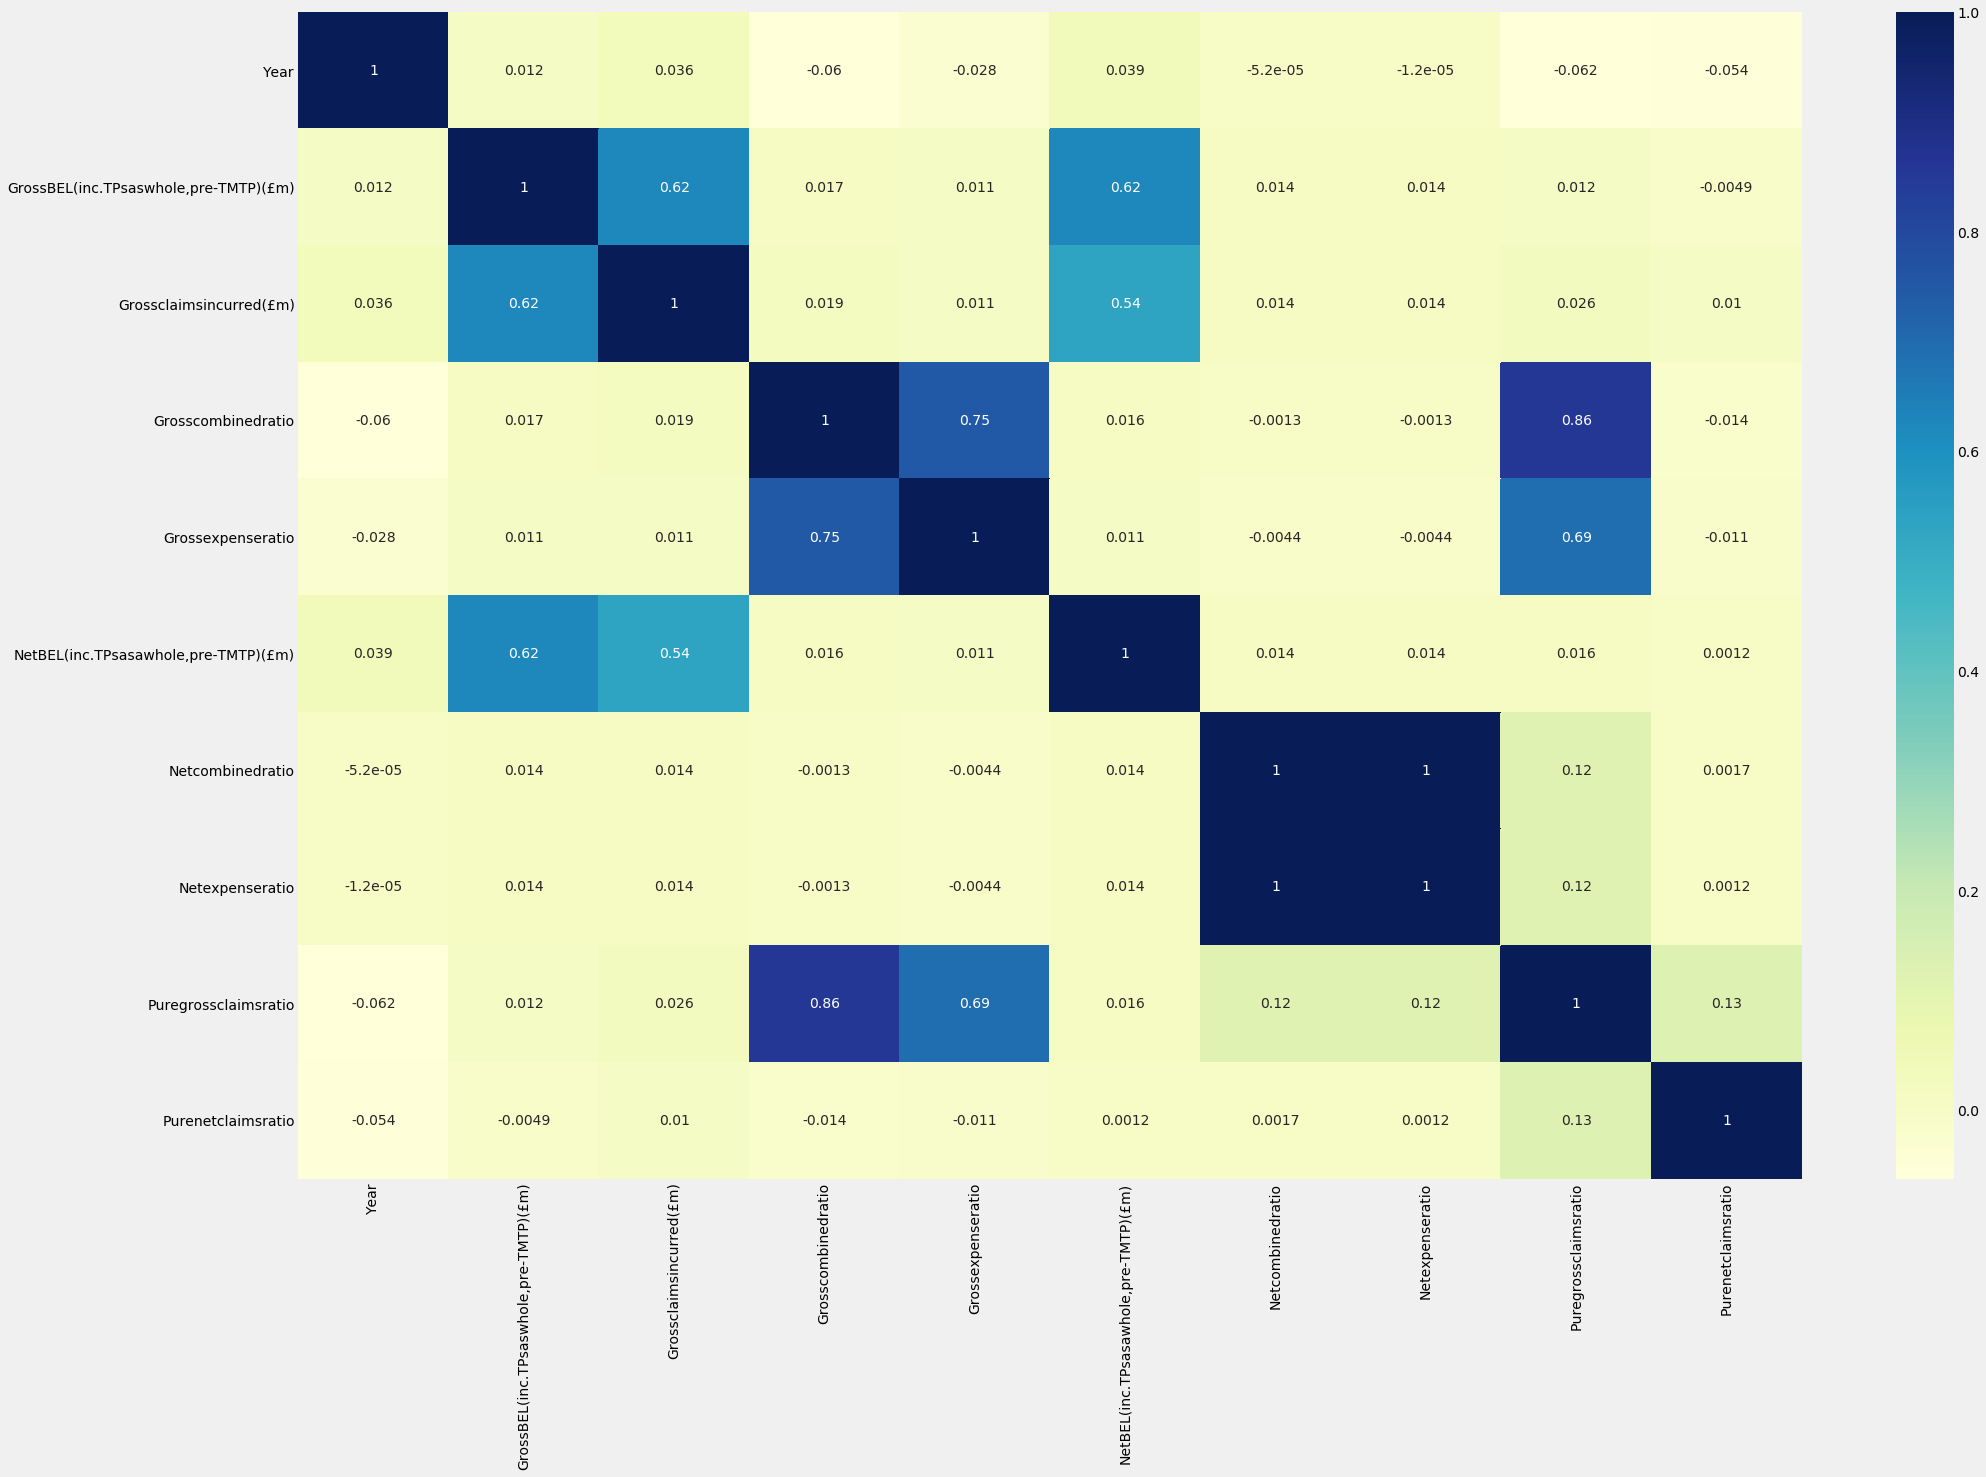

In [231]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df4_long.corr(),annot=True,cmap="YlGnBu")

Dropping Netexpenseratio as it is perfectly correlated with Netcombined ratio. Dropping Puregrossclaims ratio as it is highly correlated with Grosscombinedratio.

In [232]:
df4_long_2020_c = df4_long_2020.copy()

In [233]:
df4_long_2020_c = df4_long_2020_c.drop(['Netexpenseratio','Puregrossclaimsratio','Year'],axis=1)

In [234]:
df4_long_2020_c = df4_long_2020_c.set_index('Firm')

In [235]:
df4_long_2020_c.columns

Index(['GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)', 'Grossclaimsincurred(£m)',
       'Grosscombinedratio', 'Grossexpenseratio',
       'NetBEL(inc.TPsasawhole,pre-TMTP)(£m)', 'Netcombinedratio',
       'Purenetclaimsratio'],
      dtype='object')

#### Performing K-means clustering on this data

Using MinMaxScaler() 

In [236]:
scaler = preprocessing.MinMaxScaler()
df4_long_2020_c_scaled = scaler.fit_transform(df4_long_2020_c)

In [237]:
df4_long_2020_c_scaled = pd.DataFrame(df4_long_2020_c_scaled, columns=df4_long_2020_c.columns, index = df4_long_2020_c.index)

In [238]:
df4_long_2020_c_scaled.head()

GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  Grossclaimsincurred(£m)  \
Firm                                                                       
Firm 326                               0.001806                 0.023450   
Firm 327                               0.001806                 0.023450   
Firm 328                               0.010573                 0.054156   
Firm 329                               0.350691                 0.105391   
Firm 330                               0.001806                 0.023450   

          Grosscombinedratio  Grossexpenseratio  \
Firm                                              
Firm 326            0.999640           0.003884   
Firm 327            0.999640           0.003884   
Firm 328            0.999690           0.004333   
Firm 329            0.999643           0.006491   
Firm 330            0.999640           0.003884   

          NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  \
Firm                                                               
Firm 326                              0.003590          0.957425   
Firm 327                              0.003590          0.957425   
Firm 328                              0.054893          0.957671   
Firm 329                              0.161630          0.957803   
Firm 330                              0.003590          0.957425   

          Purenetclaimsratio  
Firm                          
Firm 326            0.789568  
Firm 327            0.789568  
Firm 328            0.789807  
Firm 329            0.789752  
Firm 330            0.789568

In [239]:
kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 101,
   }

sse = []

for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(df4_long_2020_c_scaled)
            sse.append(kmeans.inertia_)

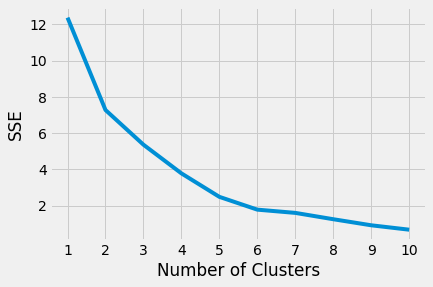

In [240]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The graph shows an elbow point at 4, 5 and 6 clusters, but does not completely flatten. However, it is not a clear elbow, making the choice of the number of clusters a subjective decision. 

In [241]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

In [242]:
# Using the silhouette coefficient
silhouette_coefficients = []
for k in range(2, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(df4_long_2020_c_scaled)
     score = silhouette_score(df4_long_2020_c_scaled, kmeans.labels_)
     silhouette_coefficients.append(score)

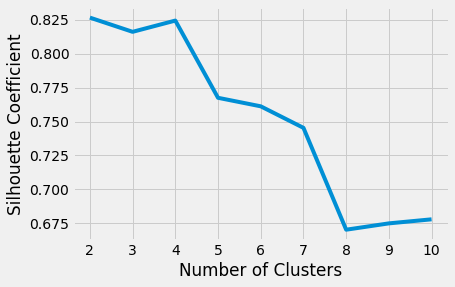

In [243]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

The best choice for k is 4 as it has a high silhouette score.

In [244]:
# Fitting the k-means algorithm to our data
kmeans = KMeans(
     init="random",
     n_clusters=4,
     n_init=10,
     max_iter=300,
     random_state=101)

kmeans.fit(df4_long_2020_c_scaled)

KMeans(init='random', n_clusters=4, random_state=101)

The kmeans.inertia_ gives us the lowest SSE value i.e. the lower the model inertia, the better the fit. An inertia of 3.78 indicates a good fit. 

In [245]:
kmeans.inertia_

3.7801053445496646

In [246]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[0.03101691, 0.04454979, 0.99967835, 0.00527515, 0.02693146,
        0.95785152, 0.79140699],
       [0.49617434, 0.51303821, 0.99972222, 0.00620831, 0.43244795,
        0.95815991, 0.78979807],
       [0.00552016, 0.02163755, 0.        , 1.        , 0.00782856,
        1.        , 0.81834594],
       [0.00346959, 0.02321112, 0.99944915, 0.2312299 , 0.00570679,
        0.        , 0.        ]])

In [247]:
# The number of iterations required to converge
kmeans.n_iter_

5

In [248]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0])

Our data is multivariate i.e. it has many dimensions. The best way to plot the clusters would be by reducing it to two dimensions using Principal Component Analysis (PCA) and then plotting it. 

In [249]:
df4_long_2020_c_scaled['clusters'] = kmeans.fit_predict(df4_long_2020_c_scaled)

In [250]:
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df4_long_2020_c_scaled)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'],index=df4_long_2020_c_scaled.index)

In [251]:
results['clusters'] = df4_long_2020_c_scaled['clusters']

In [252]:
results['clusters'].value_counts()

0    120
1      9
3      1
2      1
Name: clusters, dtype: int64

In [253]:
fig = px.scatter(results,x='pca1',y='pca2',color='clusters')
fig.show()

In [258]:
df4_long_2020_c['clusters'] = df4_long_2020_c_scaled['clusters']

In [259]:
km_firms = (df4_long_2020_c[(df4_long_2020_c['clusters']==1) | (df4_long_2020_c['clusters']==2) | (df4_long_2020_c['clusters']==3)]).index

In [260]:
print(km_firms)

Index(['Firm 337', 'Firm 349', 'Firm 359', 'Firm 362', 'Firm 387', 'Firm 418',
       'Firm 427', 'Firm 428', 'Firm 429', 'Firm 449', 'Firm 451'],
      dtype='object', name='Firm')


In [261]:
len(km_firms)

11

#### Identifying anomalies using Isolation Forest

In [262]:
model=IsolationForest(n_estimators=100,max_samples=100,contamination=float(0.10),max_features=5,random_state=101)

In [263]:
df4_long_2020_c_scaled = df4_long_2020_c_scaled.drop('clusters',axis=1)

In [264]:
model.fit(df4_long_2020_c_scaled)

IsolationForest(contamination=0.1, max_features=5, max_samples=100,
                random_state=101)

In [265]:
df4_long_2020_c_scaled['scores']=model.decision_function(df4_long_2020_c_scaled)

In [266]:
df4_long_2020_c_scaled['anomaly']=model.predict(df4_long_2020_c_scaled.drop('scores',axis=1))

In [267]:
df4_long_2020_c_scaled['anomaly'].value_counts()

 1    118
-1     13
Name: anomaly, dtype: int64

In [268]:
df4_long_2020_c_scaled[df4_long_2020_c_scaled['anomaly']==-1]

GrossBEL(inc.TPsaswhole,pre-TMTP)(£m)  Grossclaimsincurred(£m)  \
Firm                                                                       
Firm 337                               0.590641                 0.643569   
Firm 347                               0.008439                 0.274989   
Firm 359                               0.284970                 0.114097   
Firm 362                               0.283064                 0.282922   
Firm 364                               0.027026                 0.000000   
Firm 387                               0.036447                 0.877680   
Firm 403                               0.291759                 0.069271   
Firm 418                               0.003470                 0.023211   
Firm 427                               1.000000                 1.000000   
Firm 428                               0.570869                 0.479431   
Firm 449                               0.005520                 0.021638   
Firm 451                               0.933797                 0.827078   
Firm 455                               0.053988                 0.111743   

          Grosscombinedratio  Grossexpenseratio  \
Firm                                              
Firm 337            0.999694           0.008119   
Firm 347            0.999816           0.004629   
Firm 359            0.999783           0.003910   
Firm 362            0.999753           0.004398   
Firm 364            0.999896           0.000000   
Firm 387            0.999795           0.006577   
Firm 403            0.999990           0.004041   
Firm 418            0.999449           0.231230   
Firm 427            0.999755           0.005860   
Firm 428            0.999685           0.006790   
Firm 449            0.000000           1.000000   
Firm 451            0.999663           0.007563   
Firm 455            1.000000           0.010024   

          NetBEL(inc.TPsasawhole,pre-TMTP)(£m)  Netcombinedratio  \
Firm                                                               
Firm 337                              0.338791          0.958835   
Firm 347                              0.301539          0.958309   
Firm 359                              1.000000          0.958001   
Firm 362                              0.695620          0.958430   
Firm 364                              0.022515          0.963261   
Firm 387                              0.414513          0.957443   
Firm 403                              0.289027          0.959352   
Firm 418                              0.005707          0.000000   
Firm 427                              0.049381          0.958678   
Firm 428                              0.185288          0.957878   
Firm 449                              0.007829          1.000000   
Firm 451                              0.785084          0.957787   
Firm 455                              0.039756          0.956877   

          Purenetclaimsratio    scores  anomaly  
Firm                                             
Firm 337            0.789711 -0.102399       -1  
Firm 347            0.789869 -0.031957       -1  
Firm 359            0.789724 -0.104361       -1  
Firm 362            0.789902 -0.090818       -1  
Firm 364            1.000000 -0.104944       -1  
Firm 387            0.789870 -0.114619       -1  
Firm 403            0.789759 -0.076743       -1  
Firm 418            0.000000 -0.222943       -1  
Firm 427            0.789735 -0.142147       -1  
Firm 428            0.789862 -0.065438       -1  
Firm 449            0.818346 -0.275537       -1  
Firm 451            0.789810 -0.196362       -1  
Firm 455            0.789315 -0.027866       -1

In [269]:
if_firms = (df4_long_2020_c_scaled[df4_long_2020_c_scaled['anomaly']==-1]).index

In [270]:
print(if_firms)

Index(['Firm 337', 'Firm 347', 'Firm 359', 'Firm 362', 'Firm 364', 'Firm 387',
       'Firm 403', 'Firm 418', 'Firm 427', 'Firm 428', 'Firm 449', 'Firm 451',
       'Firm 455'],
      dtype='object', name='Firm')


#### Checking the intersection of the outliers pointed out by K-means and Isolation Forest

In [271]:
print(list(np.intersect1d(if_firms, km_firms)) )

['Firm 337', 'Firm 359', 'Firm 362', 'Firm 387', 'Firm 418', 'Firm 427', 'Firm 428', 'Firm 449', 'Firm 451']


We should note here that the firms obtained as outliers through the unsupervised machine learning algorithms are in line with those flagged in the graphical representations. While this is just a small subsample, the same analysis can be scaled to a large number of firms and the number of clusters in k-means or the contamination parameter in isolation forest can be adjusted accordingly. 

# Summary and Conclusions - Analysis of the remaining 131 Firms in the Underwriting Dataset

The Underwriting dataset (data frame 2) has 131 firms that were not present in the general dataset. Hence, the metrics available for these firms are limited. However, I have tried to highlight the firms to be investigated here using a few methods, with the dataset being limited to the year 2020.

A graphical analysis of these variables shows that Firm 449 has an outlying value of -12,033.4 for its Gross combined ratio. Similarly, Firm 418 seems to have anomalous values for the Pure net claims ratio and the net combined ratio. Therefore, the supervisors should pay keen attention to these firms. A bivariate scatter plot of the Gross Best Estimate Liability vs. Net Best Estimate Liability for the Year 2020 shows that firms whose GrossBEL(inc.TPsaswhole,pre-TMTP)(£m) or NetBEL(inc.TPsasawhole,pre-TMTP)(£m) is greater than 1000, should be focused on. The 15 firms flagged here include Firm 329, Firm 337, Firm 347, Firm 349, Firm 351, Firm 359, Firm 362, Firm 387, Firm 393, Firm 397, Firm 403, Firm 427, Firm 428, Firm 429, Firm 451.

In order to perform machine learning techniques i.e. k-means clustering and isolation forest on this dataset, similar considerations for correlated variables and the choice of scaler are used. The final variables in the dataset are GrossBEL(inc.TPsaswhole,pre-TMTP)(£m), Grossclaimsincurred(£m), Grosscombinedratio, Grossexpenseratio, NetBEL(inc.TPsasawhole,pre-TMTP)(£m), Netcombinedratio and Purenetclaimsratio. K-means clustering gives us good results with an inertia of 3.78 for a value of k as 4. Out of the 131 firms in the input data, there are 11 anomalous firms that are clustered into 3 clusters. These are Firm 337, Firm 349, Firm 359, Firm 362, Firm 387, Firm 418, Firm 427, Firm 428, Firm 429, Firm 449, Firm 451. We see a major overlap with the firms highlighted through the graphical analyses. An isolation forest model fit to this data flags 13 firms (out of 131) as anomalies. These are Firm 337, Firm 347, Firm 359, Firm 362, Firm 364, Firm 387, Firm 403, Firm 418, Firm 427, Firm 428, Firm 449, Firm 451, Firm 455. Again, we see a major overlap of 9 firms (out of 11) with the k-means clustering algorithm.

We should note here that the firms obtained as outliers through the unsupervised machine learning algorithms are in line with those flagged in the graphical analyses. While this is just a small subsample, the same analysis can be scaled to a larger number of firms and the number of clusters in k-means or the contamination parameter in isolation forest can be adjusted accordingly.